In [1]:
import os
import re
import numpy
import matplotlib.pyplot as plot
from collections import Counter
import pickle
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input #as process_input_inception
# from tensorflow.keras.applications.vgg16 import preprocess_input as process_input_vgg
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

/home/sauban/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sauban/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sauban/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sauban/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:

BASE_PATH = os.path.abspath("/home/sauban/campus/ml/projects/05_image_captioning")

#Source: https://www.kaggle.com/hsankesara/flickr-image-dataset
#Source: http://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b
# change this if using Flickr30k dataset
IMAGES_PATH = os.path.join(BASE_PATH, "data/flickr8k/Flickr_Data/Images")
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, "data/flickr8k/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
TEST_IMAGES_PATH = os.path.join(BASE_PATH, "data/flickr8k/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
RAW_CAPTION_PATH = os.path.join(BASE_PATH, "data/flickr8k/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
VOCABULARY_PATH = os.path.join(BASE_PATH, "data/flickr8k/vocabulary.pkl")


In [3]:
# Source: https://github.com/stanfordnlp/GloVe
GLOVE_WORD_EMBEDDINGS_PATH = os.path.join(BASE_PATH, "data/glove.6B/glove.6B.100d.txt")


In [4]:
# Paths to save files for future use (change names to reflect the models or datasets used)
PROCESSED_CAPTIONS_PATH = os.path.join(BASE_PATH, "data/preprocessed_captions.pkl")
WORD_TO_INDEX_PATH = os.path.join(BASE_PATH, "data/word_to_index.pkl")
INDEX_TO_WORD_PATH = os.path.join(BASE_PATH, "data/word_to_index.pkl")
ENCODINGS_PATH = os.path.join(BASE_PATH, "data/encodings.pkl")
WORD_EMBEDDINGS_PATH = os.path.join(BASE_PATH, "data/embeddings/g_word_embeddings_100d.pkl")
TEST_RESULTS_PATH = os.path.join(BASE_PATH, "res-inception-lstm-all-glove.pkl")

In [5]:
# Paths to load the saved models from (change names to reflect the models or datasets used)
MODEL_PATH = os.path.join(BASE_PATH, "inception-lstm-model.h5")
MODEL_HISTORY_PATH = os.path.join(BASE_PATH, "inception-lstm-flickr8k-glove300d-history.pkl")


In [6]:
MIN_WORD_FREQ = 5

In [7]:
# Data Cleaning
#### Extracting captions from Flickr8k dataset
captions = {}
with open(RAW_CAPTION_PATH, "r") as file:
    for line in file.readlines():
        splits = re.compile("#\d+").split(line)
        image_name, caption = splits
        caption = re.sub(r"\n+|\t+|\s{2,}", "", caption)
        if not captions.get(image_name, 0):
            captions[image_name] = []
        captions[image_name].append(caption)


In [8]:
def wordFilter(word):
    if not re.match(r"^[a-z]+$", word):
        return False
    if len(word) == 1 and word != "a":
        return False
    return True


In [9]:
words = []
max_length = 0
for _, _captions in captions.items():
    for i in range(len(_captions)):
        caption = _captions[i]
        caption = caption.lower()
        _words = caption.split(" ")
        _words = list(filter(wordFilter, _words))
        max_length = max(max_length, len(_words))
        _captions[i] = ' '.join(_words)
        _captions[i] = '<start> ' + _captions[i] + ' <end>'
        words.extend(_words)
word_freq = Counter(words)
max_length +=2


In [10]:
### Remove words with frequency less than 5

vocabulary = []
for word, freq in word_freq.items():
    if(freq >= MIN_WORD_FREQ):
        vocabulary.append(word)
vocabulary.append('<start>')
vocabulary.append('<end>')
vocabulary.append('<unk>')
vocabulary.sort()
vocabulary.insert(0, '<pad>')



In [11]:
with open(PROCESSED_CAPTIONS_PATH, "wb") as file:
    pickle.dump(captions, file)

with open(VOCABULARY_PATH, "wb") as file:
    pickle.dump(vocabulary, file)


In [12]:
word_to_index = {}
index_to_word = {}

index = 0
for word in vocabulary:
    word_to_index[word] = index
    index_to_word[index] = word
    index += 1

In [13]:

with open(WORD_TO_INDEX_PATH, "wb") as file:
    pickle.dump(word_to_index, file)
with open(INDEX_TO_WORD_PATH, "wb") as file:
    pickle.dump(index_to_word, file)


In [14]:
## Extract Image Encodings
#### Loading training examples from Flickr_8k.trainImages.txt

with open(TRAIN_IMAGES_PATH, "r") as file:
    train_images = file.read().strip().split("\n")



In [15]:
#### Building the inception model
backend.clear_session()
inceptionv3 = InceptionV3(weights="imagenet")
# inceptionv3.summary()
input_layer = inceptionv3.layers[0].input
output_layer = inceptionv3.layers[-1].input
inception_model = Model(inputs=input_layer, outputs=output_layer)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
def get_encodings(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = numpy.expand_dims(img, axis = 0)
    _encodings = inception_model.predict(img)[0]
    return _encodings

In [17]:
%%time
progress = tqdm(total=len(train_images), desc="Encoded", position=0)
encodings = {}
for train_image in train_images:
    _encodings = get_encodings(os.path.join(IMAGES_PATH, train_image))
    encodings[train_image] = _encodings
    progress.update(1)
    

Encoded:   0%|          | 0/6000 [00:00<?, ?it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 3/6000 [00:01<47:05,  2.12it/s]  

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:   0%|          | 5/6000 [00:01<28:26,  3.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:   0%|          | 6/6000 [00:01<23:06,  4.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:   0%|          | 8/6000 [00:01<16:49,  5.94it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:   0%|          | 10/6000 [00:01<13:43,  7.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:   0%|          | 11/6000 [00:01<13:30,  7.39it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 12/6000 [00:02<17:00,  5.87it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 13/6000 [00:02<19:06,  5.22it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 14/6000 [00:02<20:55,  4.77it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 15/6000 [00:02<22:06,  4.51it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 16/6000 [00:03<22:17,  4.47it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 17/6000 [00:03<23:00,  4.34it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 18/6000 [00:03<23:33,  4.23it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 19/6000 [00:03<23:45,  4.20it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 20/6000 [00:04<24:02,  4.15it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 21/6000 [00:04<23:58,  4.16it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 22/6000 [00:04<24:13,  4.11it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 23/6000 [00:04<24:11,  4.12it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 24/6000 [00:05<24:11,  4.12it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 25/6000 [00:05<24:12,  4.11it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 26/6000 [00:05<24:11,  4.12it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 27/6000 [00:05<24:16,  4.10it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 28/6000 [00:06<24:14,  4.11it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 29/6000 [00:06<24:16,  4.10it/s]

(1, 299, 299, 3)


Encoded:   0%|          | 30/6000 [00:06<23:54,  4.16it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 31/6000 [00:06<24:34,  4.05it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 32/6000 [00:07<25:53,  3.84it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 33/6000 [00:07<26:44,  3.72it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 34/6000 [00:07<26:50,  3.70it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 35/6000 [00:07<27:16,  3.64it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 36/6000 [00:08<28:57,  3.43it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 37/6000 [00:08<27:24,  3.63it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 38/6000 [00:08<26:34,  3.74it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 39/6000 [00:09<29:28,  3.37it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 40/6000 [00:09<27:36,  3.60it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 41/6000 [00:09<26:52,  3.70it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 42/6000 [00:09<26:54,  3.69it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 43/6000 [00:10<28:00,  3.54it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 44/6000 [00:10<28:59,  3.42it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 45/6000 [00:10<29:24,  3.38it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 46/6000 [00:11<29:44,  3.34it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 47/6000 [00:11<29:25,  3.37it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 48/6000 [00:11<29:42,  3.34it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 49/6000 [00:12<29:23,  3.38it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 50/6000 [00:12<29:59,  3.31it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 51/6000 [00:12<30:47,  3.22it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 52/6000 [00:12<30:45,  3.22it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 53/6000 [00:13<28:29,  3.48it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 54/6000 [00:13<27:21,  3.62it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 55/6000 [00:13<26:21,  3.76it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 56/6000 [00:13<25:24,  3.90it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 57/6000 [00:14<25:16,  3.92it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 58/6000 [00:14<24:38,  4.02it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 59/6000 [00:14<24:13,  4.09it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 60/6000 [00:14<24:14,  4.08it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 61/6000 [00:15<24:19,  4.07it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 62/6000 [00:15<24:12,  4.09it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 63/6000 [00:15<25:57,  3.81it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 64/6000 [00:15<25:55,  3.82it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 65/6000 [00:16<25:02,  3.95it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 66/6000 [00:16<24:25,  4.05it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 67/6000 [00:16<24:04,  4.11it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 68/6000 [00:16<23:52,  4.14it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 69/6000 [00:17<24:17,  4.07it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 70/6000 [00:17<26:33,  3.72it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 71/6000 [00:17<26:37,  3.71it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 72/6000 [00:18<27:09,  3.64it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 73/6000 [00:18<26:03,  3.79it/s]

(1, 299, 299, 3)


Encoded:   1%|          | 74/6000 [00:18<25:11,  3.92it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 75/6000 [00:18<24:39,  4.00it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 76/6000 [00:19<24:21,  4.05it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 77/6000 [00:19<24:04,  4.10it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 78/6000 [00:19<23:44,  4.16it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 79/6000 [00:19<23:35,  4.18it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 80/6000 [00:19<23:22,  4.22it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 81/6000 [00:20<23:57,  4.12it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 82/6000 [00:20<23:56,  4.12it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 83/6000 [00:20<23:34,  4.18it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 84/6000 [00:20<23:36,  4.18it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 85/6000 [00:21<25:30,  3.86it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 86/6000 [00:21<24:41,  3.99it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 87/6000 [00:21<24:13,  4.07it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 88/6000 [00:21<24:02,  4.10it/s]

(1, 299, 299, 3)


Encoded:   1%|▏         | 89/6000 [00:22<23:54,  4.12it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 90/6000 [00:22<23:49,  4.13it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 91/6000 [00:22<23:31,  4.19it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 92/6000 [00:22<23:24,  4.21it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 93/6000 [00:23<23:21,  4.21it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 94/6000 [00:23<23:16,  4.23it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 95/6000 [00:23<23:18,  4.22it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 96/6000 [00:23<23:28,  4.19it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 97/6000 [00:24<23:15,  4.23it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 98/6000 [00:24<23:15,  4.23it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 99/6000 [00:24<23:06,  4.26it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 100/6000 [00:24<23:24,  4.20it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 101/6000 [00:25<24:05,  4.08it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 102/6000 [00:25<23:42,  4.14it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 103/6000 [00:25<23:37,  4.16it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 104/6000 [00:25<24:01,  4.09it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 105/6000 [00:26<24:14,  4.05it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 106/6000 [00:26<24:16,  4.05it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 107/6000 [00:26<24:40,  3.98it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 108/6000 [00:26<26:18,  3.73it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 109/6000 [00:27<27:53,  3.52it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 110/6000 [00:27<28:06,  3.49it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 111/6000 [00:27<28:57,  3.39it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 112/6000 [00:27<27:32,  3.56it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 113/6000 [00:28<26:22,  3.72it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 114/6000 [00:28<25:27,  3.85it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 115/6000 [00:28<25:08,  3.90it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 116/6000 [00:28<25:30,  3.85it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 117/6000 [00:29<25:49,  3.80it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 118/6000 [00:29<25:11,  3.89it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 119/6000 [00:29<24:35,  3.99it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 120/6000 [00:29<24:31,  4.00it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 121/6000 [00:30<24:03,  4.07it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 122/6000 [00:30<24:31,  3.99it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 123/6000 [00:30<25:49,  3.79it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 124/6000 [00:31<25:15,  3.88it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 125/6000 [00:31<24:44,  3.96it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 126/6000 [00:31<24:22,  4.02it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 127/6000 [00:31<24:15,  4.03it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 128/6000 [00:32<24:39,  3.97it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 129/6000 [00:32<24:42,  3.96it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 130/6000 [00:32<24:46,  3.95it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 131/6000 [00:32<24:52,  3.93it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 132/6000 [00:33<24:27,  4.00it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 133/6000 [00:33<23:58,  4.08it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 134/6000 [00:33<23:48,  4.11it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 135/6000 [00:33<23:32,  4.15it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 136/6000 [00:33<23:19,  4.19it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 137/6000 [00:34<23:30,  4.16it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 138/6000 [00:34<23:43,  4.12it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 139/6000 [00:34<23:50,  4.10it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 140/6000 [00:34<23:49,  4.10it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 141/6000 [00:35<23:59,  4.07it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 142/6000 [00:35<24:33,  3.98it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 143/6000 [00:35<26:26,  3.69it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 144/6000 [00:36<29:26,  3.31it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 145/6000 [00:36<28:02,  3.48it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 146/6000 [00:36<26:43,  3.65it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 147/6000 [00:36<26:18,  3.71it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 148/6000 [00:37<25:19,  3.85it/s]

(1, 299, 299, 3)


Encoded:   2%|▏         | 149/6000 [00:37<26:53,  3.63it/s]

(1, 299, 299, 3)


Encoded:   2%|▎         | 150/6000 [00:37<28:24,  3.43it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 151/6000 [00:38<27:53,  3.50it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 152/6000 [00:38<28:46,  3.39it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 153/6000 [00:38<29:34,  3.30it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 154/6000 [00:38<27:57,  3.49it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 155/6000 [00:39<26:46,  3.64it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 156/6000 [00:39<25:50,  3.77it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 157/6000 [00:39<25:01,  3.89it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 158/6000 [00:39<24:15,  4.01it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 159/6000 [00:40<23:45,  4.10it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 160/6000 [00:40<23:33,  4.13it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 161/6000 [00:40<23:23,  4.16it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 162/6000 [00:40<23:24,  4.16it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 163/6000 [00:41<23:36,  4.12it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 164/6000 [00:41<23:40,  4.11it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 165/6000 [00:41<23:35,  4.12it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 166/6000 [00:41<24:05,  4.04it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 167/6000 [00:42<24:10,  4.02it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 168/6000 [00:42<24:19,  4.00it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 169/6000 [00:42<24:24,  3.98it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 170/6000 [00:42<23:53,  4.07it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 171/6000 [00:43<23:40,  4.10it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 172/6000 [00:43<23:27,  4.14it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 173/6000 [00:43<23:13,  4.18it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 174/6000 [00:43<23:06,  4.20it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 175/6000 [00:44<23:00,  4.22it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 176/6000 [00:44<22:54,  4.24it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 177/6000 [00:44<22:49,  4.25it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 178/6000 [00:44<23:01,  4.21it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 179/6000 [00:44<22:55,  4.23it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 180/6000 [00:45<22:57,  4.22it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 181/6000 [00:45<22:57,  4.22it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 182/6000 [00:45<22:55,  4.23it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 183/6000 [00:45<22:50,  4.24it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 184/6000 [00:46<22:51,  4.24it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 185/6000 [00:46<22:48,  4.25it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 186/6000 [00:46<22:41,  4.27it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 187/6000 [00:46<22:38,  4.28it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 188/6000 [00:47<22:48,  4.25it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 189/6000 [00:47<22:42,  4.26it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 190/6000 [00:47<22:41,  4.27it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 191/6000 [00:47<22:54,  4.23it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 192/6000 [00:48<22:50,  4.24it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 193/6000 [00:48<22:49,  4.24it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 194/6000 [00:48<22:48,  4.24it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 195/6000 [00:48<22:35,  4.28it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 196/6000 [00:48<22:43,  4.26it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 197/6000 [00:49<23:03,  4.19it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 198/6000 [00:49<23:08,  4.18it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 199/6000 [00:49<23:36,  4.10it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 200/6000 [00:49<23:58,  4.03it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 201/6000 [00:50<23:40,  4.08it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 202/6000 [00:50<23:39,  4.08it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 203/6000 [00:50<23:23,  4.13it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 204/6000 [00:50<23:16,  4.15it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 205/6000 [00:51<23:14,  4.16it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 206/6000 [00:51<23:01,  4.20it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 207/6000 [00:51<23:01,  4.19it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 208/6000 [00:51<22:56,  4.21it/s]

(1, 299, 299, 3)


Encoded:   3%|▎         | 209/6000 [00:52<22:50,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 210/6000 [00:52<22:42,  4.25it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 211/6000 [00:52<22:40,  4.25it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 212/6000 [00:52<22:47,  4.23it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 213/6000 [00:53<22:54,  4.21it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 214/6000 [00:53<22:58,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 215/6000 [00:53<22:53,  4.21it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 216/6000 [00:53<22:51,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 217/6000 [00:53<22:55,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 218/6000 [00:54<22:47,  4.23it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 219/6000 [00:54<22:37,  4.26it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 220/6000 [00:54<22:47,  4.23it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 221/6000 [00:54<22:50,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 222/6000 [00:55<22:57,  4.19it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 223/6000 [00:55<22:52,  4.21it/s]

(1, 299, 299, 3)


Encoded:   4%|▎         | 224/6000 [00:55<22:49,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 225/6000 [00:55<22:48,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 226/6000 [00:56<23:00,  4.18it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 227/6000 [00:56<23:31,  4.09it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 228/6000 [00:56<23:43,  4.05it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 229/6000 [00:56<23:38,  4.07it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 230/6000 [00:57<23:33,  4.08it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 231/6000 [00:57<23:23,  4.11it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 232/6000 [00:57<23:25,  4.10it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 233/6000 [00:57<24:09,  3.98it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 234/6000 [00:58<23:56,  4.01it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 235/6000 [00:58<24:18,  3.95it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 236/6000 [00:58<24:44,  3.88it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 237/6000 [00:58<24:03,  3.99it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 238/6000 [00:59<24:16,  3.96it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 239/6000 [00:59<25:00,  3.84it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 240/6000 [00:59<24:12,  3.97it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 241/6000 [00:59<23:48,  4.03it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 242/6000 [01:00<23:43,  4.04it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 243/6000 [01:00<24:08,  3.98it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 244/6000 [01:00<23:37,  4.06it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 245/6000 [01:00<23:21,  4.11it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 246/6000 [01:01<23:21,  4.11it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 247/6000 [01:01<23:07,  4.15it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 248/6000 [01:01<23:15,  4.12it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 249/6000 [01:01<23:07,  4.14it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 250/6000 [01:02<23:10,  4.13it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 251/6000 [01:02<22:58,  4.17it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 252/6000 [01:02<23:11,  4.13it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 253/6000 [01:02<23:10,  4.13it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 254/6000 [01:03<23:20,  4.10it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 255/6000 [01:03<23:11,  4.13it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 256/6000 [01:03<23:02,  4.15it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 257/6000 [01:03<22:57,  4.17it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 258/6000 [01:03<22:48,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 259/6000 [01:04<22:46,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 260/6000 [01:04<22:50,  4.19it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 261/6000 [01:04<22:45,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 262/6000 [01:04<22:45,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 263/6000 [01:05<22:52,  4.18it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 264/6000 [01:05<22:44,  4.20it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 265/6000 [01:05<22:40,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 266/6000 [01:05<22:43,  4.21it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 267/6000 [01:06<22:38,  4.22it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 268/6000 [01:06<22:35,  4.23it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 269/6000 [01:06<22:31,  4.24it/s]

(1, 299, 299, 3)


Encoded:   4%|▍         | 270/6000 [01:06<22:32,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 271/6000 [01:07<22:32,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 272/6000 [01:07<22:46,  4.19it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 273/6000 [01:07<22:38,  4.22it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 274/6000 [01:07<22:35,  4.22it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 275/6000 [01:08<22:38,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 276/6000 [01:08<22:31,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 277/6000 [01:08<22:25,  4.25it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 278/6000 [01:08<22:28,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 279/6000 [01:08<22:33,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 280/6000 [01:09<22:35,  4.22it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 281/6000 [01:09<22:31,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 282/6000 [01:09<22:26,  4.25it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 283/6000 [01:09<22:38,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 284/6000 [01:10<22:42,  4.20it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 285/6000 [01:10<22:33,  4.22it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 286/6000 [01:10<22:20,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 287/6000 [01:10<22:28,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 288/6000 [01:11<22:25,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 289/6000 [01:11<22:21,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 290/6000 [01:11<22:21,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 291/6000 [01:11<22:30,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 292/6000 [01:12<22:34,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 293/6000 [01:12<22:30,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 294/6000 [01:12<22:35,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 295/6000 [01:12<22:28,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 296/6000 [01:12<22:41,  4.19it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 297/6000 [01:13<22:33,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 298/6000 [01:13<22:27,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▍         | 299/6000 [01:13<22:20,  4.25it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 300/6000 [01:13<22:27,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 301/6000 [01:14<22:37,  4.20it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 302/6000 [01:14<22:38,  4.20it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 303/6000 [01:14<22:33,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 304/6000 [01:14<22:21,  4.25it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 305/6000 [01:15<22:17,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 306/6000 [01:15<22:17,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 307/6000 [01:15<22:27,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 308/6000 [01:15<22:26,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 309/6000 [01:16<22:30,  4.21it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 310/6000 [01:16<22:20,  4.25it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 311/6000 [01:16<22:15,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 312/6000 [01:16<22:12,  4.27it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 313/6000 [01:16<22:13,  4.27it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 314/6000 [01:17<22:08,  4.28it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 315/6000 [01:17<22:07,  4.28it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 316/6000 [01:17<22:12,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 317/6000 [01:17<22:20,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 318/6000 [01:18<22:16,  4.25it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 319/6000 [01:18<22:22,  4.23it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 320/6000 [01:18<22:20,  4.24it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 321/6000 [01:18<22:14,  4.26it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 322/6000 [01:19<22:53,  4.14it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 323/6000 [01:19<22:37,  4.18it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 324/6000 [01:19<22:51,  4.14it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 325/6000 [01:19<22:56,  4.12it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 326/6000 [01:20<23:03,  4.10it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 327/6000 [01:20<22:57,  4.12it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 328/6000 [01:20<22:45,  4.15it/s]

(1, 299, 299, 3)


Encoded:   5%|▌         | 329/6000 [01:20<22:33,  4.19it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 330/6000 [01:21<22:32,  4.19it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 331/6000 [01:21<22:17,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 332/6000 [01:21<22:16,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 333/6000 [01:21<22:49,  4.14it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 334/6000 [01:22<22:33,  4.18it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 335/6000 [01:22<22:21,  4.22it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 336/6000 [01:22<22:25,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 337/6000 [01:22<22:13,  4.25it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 338/6000 [01:22<22:11,  4.25it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 339/6000 [01:23<22:16,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 340/6000 [01:23<22:16,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 341/6000 [01:23<22:23,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 342/6000 [01:23<22:17,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 343/6000 [01:24<22:15,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 344/6000 [01:24<22:14,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 345/6000 [01:24<22:13,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 346/6000 [01:24<22:18,  4.22it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 347/6000 [01:25<22:28,  4.19it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 348/6000 [01:25<22:16,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 349/6000 [01:25<22:34,  4.17it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 350/6000 [01:25<22:25,  4.20it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 351/6000 [01:26<22:33,  4.17it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 352/6000 [01:26<22:24,  4.20it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 353/6000 [01:26<22:16,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 354/6000 [01:26<22:16,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 355/6000 [01:26<22:19,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 356/6000 [01:27<22:20,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 357/6000 [01:27<22:23,  4.20it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 358/6000 [01:27<22:20,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 359/6000 [01:27<22:19,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 360/6000 [01:28<22:10,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 361/6000 [01:28<22:04,  4.26it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 362/6000 [01:28<22:05,  4.25it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 363/6000 [01:28<22:07,  4.25it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 364/6000 [01:29<22:06,  4.25it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 365/6000 [01:29<22:04,  4.25it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 366/6000 [01:29<22:07,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 367/6000 [01:29<22:07,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 368/6000 [01:30<22:27,  4.18it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 369/6000 [01:30<23:05,  4.06it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 370/6000 [01:30<22:45,  4.12it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 371/6000 [01:30<22:33,  4.16it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 372/6000 [01:31<22:45,  4.12it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 373/6000 [01:31<22:27,  4.18it/s]

(1, 299, 299, 3)


Encoded:   6%|▌         | 374/6000 [01:31<22:17,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 375/6000 [01:31<22:08,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 376/6000 [01:31<22:01,  4.26it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 377/6000 [01:32<22:07,  4.24it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 378/6000 [01:32<21:59,  4.26it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 379/6000 [01:32<22:12,  4.22it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 380/6000 [01:32<22:08,  4.23it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 381/6000 [01:33<22:33,  4.15it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 382/6000 [01:33<22:22,  4.18it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 383/6000 [01:33<22:12,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 384/6000 [01:33<22:21,  4.19it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 385/6000 [01:34<22:20,  4.19it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 386/6000 [01:34<22:14,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 387/6000 [01:34<22:15,  4.20it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 388/6000 [01:34<22:19,  4.19it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 389/6000 [01:35<22:12,  4.21it/s]

(1, 299, 299, 3)


Encoded:   6%|▋         | 390/6000 [01:35<22:16,  4.20it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 391/6000 [01:35<22:14,  4.20it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 392/6000 [01:35<22:06,  4.23it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 393/6000 [01:36<22:05,  4.23it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 394/6000 [01:36<22:11,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 395/6000 [01:36<22:20,  4.18it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 396/6000 [01:36<22:18,  4.19it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 397/6000 [01:36<22:11,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 398/6000 [01:37<22:18,  4.19it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 399/6000 [01:37<22:30,  4.15it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 400/6000 [01:37<22:24,  4.17it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 401/6000 [01:37<22:08,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 402/6000 [01:38<22:11,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 403/6000 [01:38<22:05,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 404/6000 [01:38<22:01,  4.24it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 405/6000 [01:38<21:59,  4.24it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 406/6000 [01:39<22:04,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 407/6000 [01:39<22:05,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 408/6000 [01:39<21:54,  4.25it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 409/6000 [01:39<22:11,  4.20it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 410/6000 [01:40<22:08,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 411/6000 [01:40<22:24,  4.16it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 412/6000 [01:40<22:06,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 413/6000 [01:40<22:05,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 414/6000 [01:41<22:17,  4.18it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 415/6000 [01:41<22:19,  4.17it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 416/6000 [01:41<22:18,  4.17it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 417/6000 [01:41<22:12,  4.19it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 418/6000 [01:41<21:59,  4.23it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 419/6000 [01:42<21:56,  4.24it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 420/6000 [01:42<22:02,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 421/6000 [01:42<22:06,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 422/6000 [01:42<21:47,  4.27it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 423/6000 [01:43<22:05,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 424/6000 [01:43<22:47,  4.08it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 425/6000 [01:43<22:27,  4.14it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 426/6000 [01:43<22:12,  4.18it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 427/6000 [01:44<22:20,  4.16it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 428/6000 [01:44<22:08,  4.19it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 429/6000 [01:44<22:07,  4.20it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 430/6000 [01:44<22:07,  4.20it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 431/6000 [01:45<22:03,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 432/6000 [01:45<22:02,  4.21it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 433/6000 [01:45<21:54,  4.24it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 434/6000 [01:45<21:48,  4.25it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 435/6000 [01:46<21:49,  4.25it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 436/6000 [01:46<21:45,  4.26it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 437/6000 [01:46<21:45,  4.26it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 438/6000 [01:46<21:46,  4.26it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 439/6000 [01:46<21:51,  4.24it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 440/6000 [01:47<21:58,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 441/6000 [01:47<21:55,  4.23it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 442/6000 [01:47<21:47,  4.25it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 443/6000 [01:47<21:41,  4.27it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 444/6000 [01:48<21:53,  4.23it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 445/6000 [01:48<21:56,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 446/6000 [01:48<22:01,  4.20it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 447/6000 [01:48<21:54,  4.22it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 448/6000 [01:49<21:51,  4.23it/s]

(1, 299, 299, 3)


Encoded:   7%|▋         | 449/6000 [01:49<22:00,  4.20it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 450/6000 [01:49<21:58,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 451/6000 [01:49<21:59,  4.20it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 452/6000 [01:50<22:11,  4.17it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 453/6000 [01:50<21:53,  4.22it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 454/6000 [01:50<21:55,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 455/6000 [01:50<22:37,  4.09it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 456/6000 [01:51<22:17,  4.14it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 457/6000 [01:51<22:09,  4.17it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 458/6000 [01:51<21:49,  4.23it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 459/6000 [01:51<21:52,  4.22it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 460/6000 [01:51<21:54,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 461/6000 [01:52<21:47,  4.24it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 462/6000 [01:52<21:37,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 463/6000 [01:52<21:24,  4.31it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 464/6000 [01:52<21:30,  4.29it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 465/6000 [01:53<21:35,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 466/6000 [01:53<21:38,  4.26it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 467/6000 [01:53<21:42,  4.25it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 468/6000 [01:53<21:42,  4.25it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 469/6000 [01:54<21:36,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 470/6000 [01:54<21:48,  4.23it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 471/6000 [01:54<21:47,  4.23it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 472/6000 [01:54<21:52,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 473/6000 [01:55<21:51,  4.22it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 474/6000 [01:55<21:49,  4.22it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 475/6000 [01:55<21:52,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 476/6000 [01:55<21:39,  4.25it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 477/6000 [01:55<21:45,  4.23it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 478/6000 [01:56<21:42,  4.24it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 479/6000 [01:56<21:48,  4.22it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 480/6000 [01:56<21:52,  4.20it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 481/6000 [01:56<21:52,  4.20it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 482/6000 [01:57<21:59,  4.18it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 483/6000 [01:57<21:43,  4.23it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 484/6000 [01:57<21:33,  4.26it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 485/6000 [01:57<21:31,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 486/6000 [01:58<21:31,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 487/6000 [01:58<21:30,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 488/6000 [01:58<21:26,  4.28it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 489/6000 [01:58<21:28,  4.28it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 490/6000 [01:59<21:31,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 491/6000 [01:59<21:33,  4.26it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 492/6000 [01:59<21:35,  4.25it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 493/6000 [01:59<21:28,  4.27it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 494/6000 [01:59<21:26,  4.28it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 495/6000 [02:00<21:25,  4.28it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 496/6000 [02:00<21:47,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 497/6000 [02:00<21:41,  4.23it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 498/6000 [02:00<21:34,  4.25it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 499/6000 [02:01<21:38,  4.24it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 500/6000 [02:01<21:43,  4.22it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 501/6000 [02:01<21:44,  4.21it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 502/6000 [02:01<21:37,  4.24it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 503/6000 [02:02<21:31,  4.26it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 504/6000 [02:02<21:22,  4.29it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 505/6000 [02:02<21:30,  4.26it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 506/6000 [02:02<21:51,  4.19it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 507/6000 [02:03<22:04,  4.15it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 508/6000 [02:03<21:50,  4.19it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 509/6000 [02:03<21:45,  4.20it/s]

(1, 299, 299, 3)


Encoded:   8%|▊         | 510/6000 [02:03<21:40,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 511/6000 [02:03<21:41,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 512/6000 [02:04<21:42,  4.21it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 513/6000 [02:04<21:38,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 514/6000 [02:04<21:46,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 515/6000 [02:04<21:44,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 516/6000 [02:05<21:45,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 517/6000 [02:05<21:39,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 518/6000 [02:05<21:32,  4.24it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 519/6000 [02:05<21:34,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 520/6000 [02:06<21:43,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 521/6000 [02:06<21:35,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 522/6000 [02:06<21:26,  4.26it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 523/6000 [02:06<21:44,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▊         | 524/6000 [02:07<21:45,  4.19it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 525/6000 [02:07<21:40,  4.21it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 526/6000 [02:07<21:38,  4.21it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 527/6000 [02:07<21:43,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 528/6000 [02:08<21:49,  4.18it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 529/6000 [02:08<21:41,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 530/6000 [02:08<21:32,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 531/6000 [02:08<21:28,  4.24it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 532/6000 [02:08<21:28,  4.24it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 533/6000 [02:09<21:27,  4.25it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 534/6000 [02:09<21:24,  4.25it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 535/6000 [02:09<21:31,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 536/6000 [02:09<21:32,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 537/6000 [02:10<21:31,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 538/6000 [02:10<21:30,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 539/6000 [02:10<21:33,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 540/6000 [02:10<21:32,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 541/6000 [02:11<21:37,  4.21it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 542/6000 [02:11<21:31,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 543/6000 [02:11<21:33,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 544/6000 [02:11<21:26,  4.24it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 545/6000 [02:12<21:22,  4.25it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 546/6000 [02:12<21:14,  4.28it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 547/6000 [02:12<21:16,  4.27it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 548/6000 [02:12<21:11,  4.29it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 549/6000 [02:12<21:10,  4.29it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 550/6000 [02:13<21:15,  4.27it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 551/6000 [02:13<21:21,  4.25it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 552/6000 [02:13<21:27,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 553/6000 [02:13<21:13,  4.28it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 554/6000 [02:14<21:51,  4.15it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 555/6000 [02:14<21:36,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 556/6000 [02:14<21:39,  4.19it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 557/6000 [02:14<21:42,  4.18it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 558/6000 [02:15<22:08,  4.10it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 559/6000 [02:15<21:58,  4.13it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 560/6000 [02:15<21:40,  4.18it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 561/6000 [02:15<21:42,  4.17it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 562/6000 [02:16<21:36,  4.20it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 563/6000 [02:16<21:27,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 564/6000 [02:16<21:27,  4.22it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 565/6000 [02:16<21:24,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 566/6000 [02:17<21:23,  4.23it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 567/6000 [02:17<21:28,  4.21it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 568/6000 [02:17<21:20,  4.24it/s]

(1, 299, 299, 3)


Encoded:   9%|▉         | 569/6000 [02:17<21:18,  4.25it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 570/6000 [02:17<21:19,  4.24it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 571/6000 [02:18<21:20,  4.24it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 572/6000 [02:18<21:04,  4.29it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 573/6000 [02:18<20:50,  4.34it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 574/6000 [02:18<20:56,  4.32it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 575/6000 [02:19<21:37,  4.18it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 576/6000 [02:19<21:37,  4.18it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 577/6000 [02:19<21:32,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 578/6000 [02:19<21:23,  4.22it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 579/6000 [02:20<21:42,  4.16it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 580/6000 [02:20<21:43,  4.16it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 581/6000 [02:20<21:34,  4.19it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 582/6000 [02:20<21:28,  4.21it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 583/6000 [02:21<21:26,  4.21it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 584/6000 [02:21<21:20,  4.23it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 585/6000 [02:21<21:21,  4.23it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 586/6000 [02:21<21:30,  4.19it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 587/6000 [02:21<21:41,  4.16it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 588/6000 [02:22<21:30,  4.19it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 589/6000 [02:22<21:33,  4.18it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 590/6000 [02:22<21:23,  4.21it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 591/6000 [02:22<21:57,  4.11it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 592/6000 [02:23<21:51,  4.12it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 593/6000 [02:23<21:41,  4.15it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 594/6000 [02:23<21:28,  4.19it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 595/6000 [02:23<21:24,  4.21it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 596/6000 [02:24<21:22,  4.21it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 597/6000 [02:24<21:19,  4.22it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 598/6000 [02:24<21:24,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|▉         | 599/6000 [02:24<21:24,  4.21it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 600/6000 [02:25<21:36,  4.17it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 601/6000 [02:25<21:17,  4.22it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 602/6000 [02:25<21:18,  4.22it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 603/6000 [02:25<21:31,  4.18it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 604/6000 [02:26<21:54,  4.10it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 605/6000 [02:26<21:41,  4.15it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 606/6000 [02:26<21:24,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 607/6000 [02:26<21:22,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 608/6000 [02:27<21:39,  4.15it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 609/6000 [02:27<21:39,  4.15it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 610/6000 [02:27<21:28,  4.18it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 611/6000 [02:27<21:21,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 612/6000 [02:27<21:22,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 613/6000 [02:28<21:31,  4.17it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 614/6000 [02:28<21:22,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 615/6000 [02:28<21:16,  4.22it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 616/6000 [02:28<21:05,  4.26it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 617/6000 [02:29<21:06,  4.25it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 618/6000 [02:29<21:26,  4.18it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 619/6000 [02:29<21:36,  4.15it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 620/6000 [02:29<21:29,  4.17it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 621/6000 [02:30<21:31,  4.16it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 622/6000 [02:30<22:38,  3.96it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 623/6000 [02:30<22:11,  4.04it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 624/6000 [02:30<21:57,  4.08it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 625/6000 [02:31<21:53,  4.09it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 626/6000 [02:31<21:38,  4.14it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 627/6000 [02:31<21:39,  4.13it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 628/6000 [02:31<21:28,  4.17it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 629/6000 [02:32<21:17,  4.20it/s]

(1, 299, 299, 3)


Encoded:  10%|█         | 630/6000 [02:32<21:03,  4.25it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 631/6000 [02:32<21:04,  4.25it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 632/6000 [02:32<21:13,  4.21it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 633/6000 [02:32<21:06,  4.24it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 634/6000 [02:33<21:01,  4.25it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 635/6000 [02:33<20:50,  4.29it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 636/6000 [02:33<21:00,  4.26it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 637/6000 [02:33<21:02,  4.25it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 638/6000 [02:34<21:08,  4.23it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 639/6000 [02:34<21:12,  4.21it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 640/6000 [02:34<21:01,  4.25it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 641/6000 [02:34<21:05,  4.23it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 642/6000 [02:35<20:57,  4.26it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 643/6000 [02:35<20:57,  4.26it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 644/6000 [02:35<20:56,  4.26it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 645/6000 [02:35<20:48,  4.29it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 646/6000 [02:36<20:50,  4.28it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 647/6000 [02:36<21:12,  4.21it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 648/6000 [02:36<21:05,  4.23it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 649/6000 [02:36<21:05,  4.23it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 650/6000 [02:37<21:38,  4.12it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 651/6000 [02:37<21:27,  4.16it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 652/6000 [02:37<21:31,  4.14it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 653/6000 [02:37<21:23,  4.16it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 654/6000 [02:37<21:06,  4.22it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 655/6000 [02:38<20:58,  4.25it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 656/6000 [02:38<21:29,  4.14it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 657/6000 [02:38<22:43,  3.92it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 658/6000 [02:39<24:02,  3.70it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 659/6000 [02:39<24:45,  3.60it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 660/6000 [02:39<25:07,  3.54it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 661/6000 [02:39<23:51,  3.73it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 662/6000 [02:40<23:17,  3.82it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 663/6000 [02:40<23:26,  3.79it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 664/6000 [02:40<24:32,  3.62it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 665/6000 [02:40<24:47,  3.59it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 666/6000 [02:41<24:36,  3.61it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 667/6000 [02:41<24:18,  3.66it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 668/6000 [02:41<23:25,  3.79it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 669/6000 [02:42<23:04,  3.85it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 670/6000 [02:42<24:46,  3.59it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 671/6000 [02:42<23:43,  3.74it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 672/6000 [02:42<24:31,  3.62it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 673/6000 [02:43<24:35,  3.61it/s]

(1, 299, 299, 3)


Encoded:  11%|█         | 674/6000 [02:43<24:51,  3.57it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 675/6000 [02:43<24:45,  3.59it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 676/6000 [02:43<25:02,  3.54it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 677/6000 [02:44<24:41,  3.59it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 678/6000 [02:44<24:37,  3.60it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 679/6000 [02:44<24:48,  3.57it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 680/6000 [02:45<24:49,  3.57it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 681/6000 [02:45<25:04,  3.53it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 682/6000 [02:45<24:43,  3.58it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 683/6000 [02:45<24:27,  3.62it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 684/6000 [02:46<24:52,  3.56it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 685/6000 [02:46<24:47,  3.57it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 686/6000 [02:46<24:15,  3.65it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 687/6000 [02:47<23:25,  3.78it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 688/6000 [02:47<23:03,  3.84it/s]

(1, 299, 299, 3)


Encoded:  11%|█▏        | 689/6000 [02:47<23:19,  3.80it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 690/6000 [02:47<24:27,  3.62it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 691/6000 [02:48<25:15,  3.50it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 692/6000 [02:48<25:23,  3.48it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 693/6000 [02:48<25:44,  3.44it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 694/6000 [02:48<24:54,  3.55it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 695/6000 [02:49<24:14,  3.65it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 696/6000 [02:49<25:30,  3.47it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 697/6000 [02:49<25:49,  3.42it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 698/6000 [02:50<26:03,  3.39it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 699/6000 [02:50<24:31,  3.60it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 700/6000 [02:50<23:37,  3.74it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 701/6000 [02:50<23:05,  3.82it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 702/6000 [02:51<22:45,  3.88it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 703/6000 [02:51<22:36,  3.91it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 704/6000 [02:51<22:21,  3.95it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 705/6000 [02:51<22:15,  3.96it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 706/6000 [02:52<22:11,  3.98it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 707/6000 [02:52<22:58,  3.84it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 708/6000 [02:52<22:50,  3.86it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 709/6000 [02:52<22:33,  3.91it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 710/6000 [02:53<22:15,  3.96it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 711/6000 [02:53<22:13,  3.97it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 712/6000 [02:53<22:06,  3.99it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 713/6000 [02:53<22:08,  3.98it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 714/6000 [02:54<22:14,  3.96it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 715/6000 [02:54<22:04,  3.99it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 716/6000 [02:54<21:52,  4.02it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 717/6000 [02:54<21:51,  4.03it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 718/6000 [02:55<21:45,  4.05it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 719/6000 [02:55<23:20,  3.77it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 720/6000 [02:55<24:50,  3.54it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 721/6000 [02:56<24:57,  3.53it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 722/6000 [02:56<24:39,  3.57it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 723/6000 [02:56<25:30,  3.45it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 724/6000 [02:56<25:36,  3.43it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 725/6000 [02:57<24:36,  3.57it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 726/6000 [02:57<23:49,  3.69it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 727/6000 [02:57<23:24,  3.75it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 728/6000 [02:58<25:46,  3.41it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 729/6000 [02:58<26:19,  3.34it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 730/6000 [02:58<25:05,  3.50it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 731/6000 [02:58<25:40,  3.42it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 732/6000 [02:59<26:09,  3.36it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 733/6000 [02:59<26:52,  3.27it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 734/6000 [02:59<26:43,  3.28it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 735/6000 [03:00<25:29,  3.44it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 736/6000 [03:00<25:01,  3.51it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 737/6000 [03:00<25:34,  3.43it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 738/6000 [03:00<24:23,  3.60it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 739/6000 [03:01<23:54,  3.67it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 740/6000 [03:01<23:09,  3.79it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 741/6000 [03:01<23:05,  3.79it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 742/6000 [03:01<22:36,  3.88it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 743/6000 [03:02<22:14,  3.94it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 744/6000 [03:02<22:15,  3.94it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 745/6000 [03:02<22:15,  3.93it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 746/6000 [03:02<22:05,  3.96it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 747/6000 [03:03<22:07,  3.96it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 748/6000 [03:03<22:18,  3.92it/s]

(1, 299, 299, 3)


Encoded:  12%|█▏        | 749/6000 [03:03<22:27,  3.90it/s]

(1, 299, 299, 3)


Encoded:  12%|█▎        | 750/6000 [03:04<22:24,  3.90it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 751/6000 [03:04<22:30,  3.89it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 752/6000 [03:04<22:36,  3.87it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 753/6000 [03:04<22:05,  3.96it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 754/6000 [03:05<21:34,  4.05it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 755/6000 [03:05<21:10,  4.13it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 756/6000 [03:05<21:19,  4.10it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 757/6000 [03:05<21:19,  4.10it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 758/6000 [03:06<21:56,  3.98it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 759/6000 [03:06<23:05,  3.78it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 760/6000 [03:06<23:48,  3.67it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 761/6000 [03:06<23:38,  3.69it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 762/6000 [03:07<23:11,  3.76it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 763/6000 [03:07<22:48,  3.83it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 764/6000 [03:07<22:22,  3.90it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 765/6000 [03:07<23:10,  3.76it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 766/6000 [03:08<24:54,  3.50it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 767/6000 [03:08<23:55,  3.65it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 768/6000 [03:08<23:41,  3.68it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 769/6000 [03:09<23:31,  3.71it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 770/6000 [03:09<24:01,  3.63it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 771/6000 [03:09<24:10,  3.61it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 772/6000 [03:09<24:27,  3.56it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 773/6000 [03:10<24:06,  3.61it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 774/6000 [03:10<23:50,  3.65it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 775/6000 [03:10<23:46,  3.66it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 776/6000 [03:10<23:21,  3.73it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 777/6000 [03:11<23:30,  3.70it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 778/6000 [03:11<23:06,  3.77it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 779/6000 [03:11<22:49,  3.81it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 780/6000 [03:12<23:35,  3.69it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 781/6000 [03:12<23:17,  3.73it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 782/6000 [03:12<22:49,  3.81it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 783/6000 [03:12<22:14,  3.91it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 784/6000 [03:13<22:08,  3.93it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 785/6000 [03:13<22:02,  3.94it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 786/6000 [03:13<22:05,  3.93it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 787/6000 [03:13<22:08,  3.92it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 788/6000 [03:14<22:34,  3.85it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 789/6000 [03:14<23:04,  3.76it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 790/6000 [03:14<22:49,  3.80it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 791/6000 [03:14<22:41,  3.82it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 792/6000 [03:15<22:28,  3.86it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 793/6000 [03:15<22:04,  3.93it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 794/6000 [03:15<21:54,  3.96it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 795/6000 [03:15<21:52,  3.97it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 796/6000 [03:16<21:56,  3.95it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 797/6000 [03:16<21:47,  3.98it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 798/6000 [03:16<22:58,  3.77it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 799/6000 [03:16<23:56,  3.62it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 800/6000 [03:17<23:57,  3.62it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 801/6000 [03:17<23:23,  3.70it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 802/6000 [03:17<23:30,  3.69it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 803/6000 [03:18<23:33,  3.68it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 804/6000 [03:18<23:02,  3.76it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 805/6000 [03:18<25:46,  3.36it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 806/6000 [03:18<24:21,  3.55it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 807/6000 [03:19<23:34,  3.67it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 808/6000 [03:19<22:55,  3.77it/s]

(1, 299, 299, 3)


Encoded:  13%|█▎        | 809/6000 [03:19<25:08,  3.44it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 810/6000 [03:19<24:35,  3.52it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 811/6000 [03:20<24:09,  3.58it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 812/6000 [03:20<24:02,  3.60it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 813/6000 [03:20<23:44,  3.64it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 814/6000 [03:21<23:48,  3.63it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 815/6000 [03:21<23:14,  3.72it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 816/6000 [03:21<22:41,  3.81it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 817/6000 [03:21<22:18,  3.87it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 818/6000 [03:22<22:04,  3.91it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 819/6000 [03:22<21:51,  3.95it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 820/6000 [03:22<21:42,  3.98it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 821/6000 [03:22<22:09,  3.90it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 822/6000 [03:23<22:35,  3.82it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 823/6000 [03:23<22:23,  3.85it/s]

(1, 299, 299, 3)


Encoded:  14%|█▎        | 824/6000 [03:23<22:16,  3.87it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 825/6000 [03:23<21:53,  3.94it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 826/6000 [03:24<21:59,  3.92it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 827/6000 [03:24<22:19,  3.86it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 828/6000 [03:24<22:02,  3.91it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 829/6000 [03:24<21:33,  4.00it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 830/6000 [03:25<21:26,  4.02it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 831/6000 [03:25<21:01,  4.10it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 832/6000 [03:25<20:39,  4.17it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 833/6000 [03:25<20:35,  4.18it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 834/6000 [03:26<20:44,  4.15it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 835/6000 [03:26<20:52,  4.12it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 836/6000 [03:26<20:24,  4.22it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 837/6000 [03:26<20:17,  4.24it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 838/6000 [03:27<20:08,  4.27it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 839/6000 [03:27<19:55,  4.32it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 840/6000 [03:27<20:08,  4.27it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 841/6000 [03:27<20:11,  4.26it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 842/6000 [03:27<20:04,  4.28it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 843/6000 [03:28<20:03,  4.28it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 844/6000 [03:28<20:06,  4.27it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 845/6000 [03:28<19:58,  4.30it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 846/6000 [03:28<19:55,  4.31it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 847/6000 [03:29<20:02,  4.28it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 848/6000 [03:29<19:55,  4.31it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 849/6000 [03:29<19:58,  4.30it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 850/6000 [03:29<19:55,  4.31it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 851/6000 [03:30<19:55,  4.31it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 852/6000 [03:30<20:09,  4.25it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 853/6000 [03:30<19:56,  4.30it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 854/6000 [03:30<20:11,  4.25it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 855/6000 [03:31<23:16,  3.68it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 856/6000 [03:31<22:52,  3.75it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 857/6000 [03:31<21:50,  3.93it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 858/6000 [03:31<21:18,  4.02it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 859/6000 [03:32<21:03,  4.07it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 860/6000 [03:32<20:40,  4.14it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 861/6000 [03:32<20:14,  4.23it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 862/6000 [03:32<20:38,  4.15it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 864/6000 [03:33<20:11,  4.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  14%|█▍        | 865/6000 [03:33<20:07,  4.25it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 866/6000 [03:33<19:55,  4.30it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 867/6000 [03:33<19:48,  4.32it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 868/6000 [03:34<19:49,  4.32it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 869/6000 [03:34<19:32,  4.38it/s]

(1, 299, 299, 3)


Encoded:  14%|█▍        | 870/6000 [03:34<19:44,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 871/6000 [03:34<19:50,  4.31it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 872/6000 [03:35<19:56,  4.28it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 873/6000 [03:35<20:03,  4.26it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 874/6000 [03:35<20:08,  4.24it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 875/6000 [03:35<20:05,  4.25it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 876/6000 [03:36<20:19,  4.20it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 877/6000 [03:36<20:10,  4.23it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 878/6000 [03:36<20:00,  4.27it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 879/6000 [03:36<20:09,  4.23it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 880/6000 [03:36<20:01,  4.26it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 881/6000 [03:37<19:52,  4.29it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 882/6000 [03:37<20:00,  4.26it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 883/6000 [03:37<19:50,  4.30it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 884/6000 [03:37<19:42,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 885/6000 [03:38<19:38,  4.34it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 886/6000 [03:38<19:38,  4.34it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 888/6000 [03:38<19:29,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  15%|█▍        | 889/6000 [03:39<19:28,  4.37it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 890/6000 [03:39<19:32,  4.36it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 891/6000 [03:39<19:25,  4.38it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 892/6000 [03:39<19:34,  4.35it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 893/6000 [03:39<19:30,  4.36it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 894/6000 [03:40<19:40,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 895/6000 [03:40<19:42,  4.32it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 896/6000 [03:40<19:50,  4.29it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 897/6000 [03:40<19:42,  4.32it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 898/6000 [03:41<19:37,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▍        | 899/6000 [03:41<19:38,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 900/6000 [03:41<19:31,  4.35it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 901/6000 [03:41<19:33,  4.34it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 902/6000 [03:42<19:38,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 903/6000 [03:42<19:30,  4.35it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 904/6000 [03:42<19:24,  4.38it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 905/6000 [03:42<19:26,  4.37it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 906/6000 [03:42<19:24,  4.37it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 907/6000 [03:43<19:34,  4.34it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 908/6000 [03:43<19:36,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 909/6000 [03:43<19:42,  4.31it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 910/6000 [03:43<19:36,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 911/6000 [03:44<19:39,  4.31it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 912/6000 [03:44<19:34,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 913/6000 [03:44<19:30,  4.35it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 914/6000 [03:44<19:32,  4.34it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 915/6000 [03:45<19:34,  4.33it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 916/6000 [03:45<19:32,  4.34it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 918/6000 [03:45<19:15,  4.40it/s]

(1, 299, 299, 3)


Encoded:  15%|█▌        | 920/6000 [03:45<14:00,  6.05it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  15%|█▌        | 921/6000 [03:46<12:36,  6.72it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  15%|█▌        | 924/6000 [03:46<10:36,  7.97it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  15%|█▌        | 926/6000 [03:46<09:45,  8.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 930/6000 [03:46<08:58,  9.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 933/6000 [03:47<08:48,  9.58it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 935/6000 [03:47<08:30,  9.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 937/6000 [03:47<08:35,  9.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 939/6000 [03:47<09:27,  8.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 942/6000 [03:48<09:00,  9.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 945/6000 [03:48<08:44,  9.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 947/6000 [03:48<09:07,  9.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 948/6000 [03:48<12:08,  6.93it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 950/6000 [03:49<15:41,  5.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 951/6000 [03:49<16:38,  5.06it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 952/6000 [03:49<17:44,  4.74it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 953/6000 [03:50<18:18,  4.60it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 955/6000 [03:50<18:42,  4.49it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 956/6000 [03:50<18:49,  4.47it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 957/6000 [03:51<19:01,  4.42it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 958/6000 [03:51<21:07,  3.98it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 959/6000 [03:51<23:33,  3.57it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 960/6000 [03:51<23:11,  3.62it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 962/6000 [03:52<21:24,  3.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  16%|█▌        | 963/6000 [03:52<20:38,  4.07it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 964/6000 [03:52<20:17,  4.14it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 965/6000 [03:53<20:02,  4.19it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 966/6000 [03:53<19:46,  4.24it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 967/6000 [03:53<19:46,  4.24it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 968/6000 [03:53<19:38,  4.27it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 969/6000 [03:54<19:39,  4.26it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 970/6000 [03:54<19:26,  4.31it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 971/6000 [03:54<19:36,  4.28it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 972/6000 [03:54<19:28,  4.30it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 973/6000 [03:54<19:32,  4.29it/s]

(1, 299, 299, 3)


Encoded:  16%|█▌        | 974/6000 [03:55<19:24,  4.31it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 975/6000 [03:55<19:19,  4.33it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 976/6000 [03:55<19:18,  4.34it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 977/6000 [03:55<19:26,  4.30it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 978/6000 [03:56<19:21,  4.32it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 979/6000 [03:56<19:23,  4.31it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 980/6000 [03:56<19:16,  4.34it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 981/6000 [03:56<19:13,  4.35it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 982/6000 [03:57<19:16,  4.34it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 983/6000 [03:57<19:27,  4.30it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 984/6000 [03:57<19:25,  4.30it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 985/6000 [03:57<19:21,  4.32it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 986/6000 [03:57<19:23,  4.31it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 987/6000 [03:58<19:12,  4.35it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 988/6000 [03:58<19:08,  4.36it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 989/6000 [03:58<19:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  16%|█▋        | 990/6000 [03:58<19:12,  4.35it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 991/6000 [03:59<19:26,  4.30it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 993/6000 [03:59<19:10,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 994/6000 [03:59<19:08,  4.36it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 995/6000 [04:00<19:12,  4.34it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 996/6000 [04:00<19:40,  4.24it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 998/6000 [04:00<19:28,  4.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1001/6000 [04:01<13:56,  5.98it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1004/6000 [04:01<10:52,  7.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1007/6000 [04:01<09:29,  8.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1010/6000 [04:02<09:04,  9.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1011/6000 [04:02<08:58,  9.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1014/6000 [04:02<08:46,  9.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1016/6000 [04:02<09:02,  9.19it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1017/6000 [04:02<10:08,  8.19it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1018/6000 [04:03<13:04,  6.35it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1019/6000 [04:03<14:59,  5.54it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1021/6000 [04:03<16:53,  4.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1022/6000 [04:03<17:30,  4.74it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1023/6000 [04:04<18:00,  4.61it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1024/6000 [04:04<18:18,  4.53it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1025/6000 [04:04<18:21,  4.52it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1026/6000 [04:04<18:30,  4.48it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1027/6000 [04:05<18:39,  4.44it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1028/6000 [04:05<18:49,  4.40it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1029/6000 [04:05<18:53,  4.39it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1030/6000 [04:05<19:00,  4.36it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1031/6000 [04:06<19:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1032/6000 [04:06<19:06,  4.33it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1033/6000 [04:06<19:12,  4.31it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1034/6000 [04:06<18:59,  4.36it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1035/6000 [04:06<18:53,  4.38it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1037/6000 [04:07<18:44,  4.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  17%|█▋        | 1038/6000 [04:07<18:42,  4.42it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1039/6000 [04:07<18:50,  4.39it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1040/6000 [04:08<19:00,  4.35it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1041/6000 [04:08<19:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1042/6000 [04:08<18:56,  4.36it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1043/6000 [04:08<18:50,  4.39it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1044/6000 [04:09<19:00,  4.35it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1045/6000 [04:09<18:54,  4.37it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1046/6000 [04:09<18:45,  4.40it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1047/6000 [04:09<18:45,  4.40it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1048/6000 [04:09<18:54,  4.37it/s]

(1, 299, 299, 3)


Encoded:  17%|█▋        | 1049/6000 [04:10<18:52,  4.37it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1050/6000 [04:10<18:50,  4.38it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1051/6000 [04:10<19:05,  4.32it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1052/6000 [04:10<19:01,  4.34it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1054/6000 [04:11<18:57,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  18%|█▊        | 1055/6000 [04:11<18:50,  4.38it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1056/6000 [04:11<18:47,  4.39it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1057/6000 [04:12<18:44,  4.40it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1058/6000 [04:12<18:43,  4.40it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1059/6000 [04:12<18:46,  4.39it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1060/6000 [04:12<18:49,  4.37it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1061/6000 [04:12<18:51,  4.37it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1062/6000 [04:13<19:05,  4.31it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1063/6000 [04:13<19:53,  4.14it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1064/6000 [04:13<19:31,  4.21it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1065/6000 [04:13<19:19,  4.26it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1066/6000 [04:14<19:21,  4.25it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1067/6000 [04:14<19:07,  4.30it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1068/6000 [04:14<18:58,  4.33it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1069/6000 [04:14<18:51,  4.36it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1070/6000 [04:15<19:04,  4.31it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1071/6000 [04:15<19:07,  4.30it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1072/6000 [04:15<18:54,  4.34it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1073/6000 [04:15<19:05,  4.30it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1074/6000 [04:15<19:38,  4.18it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1075/6000 [04:16<19:55,  4.12it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1076/6000 [04:16<19:57,  4.11it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1077/6000 [04:16<19:56,  4.11it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1078/6000 [04:16<19:38,  4.18it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1079/6000 [04:17<19:23,  4.23it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1080/6000 [04:17<19:08,  4.28it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1081/6000 [04:17<19:00,  4.31it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1082/6000 [04:17<18:59,  4.31it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1083/6000 [04:18<18:49,  4.36it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1085/6000 [04:18<18:36,  4.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  18%|█▊        | 1086/6000 [04:18<18:40,  4.39it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1087/6000 [04:19<18:45,  4.37it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1088/6000 [04:19<18:43,  4.37it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1089/6000 [04:19<19:17,  4.24it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1090/6000 [04:19<19:18,  4.24it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1091/6000 [04:19<19:03,  4.29it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1092/6000 [04:20<18:59,  4.31it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1093/6000 [04:20<19:12,  4.26it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1094/6000 [04:20<18:59,  4.31it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1095/6000 [04:20<18:53,  4.33it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1096/6000 [04:21<21:16,  3.84it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1097/6000 [04:21<20:49,  3.92it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1098/6000 [04:21<20:24,  4.00it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1099/6000 [04:21<20:39,  3.95it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1100/6000 [04:22<20:01,  4.08it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1101/6000 [04:22<20:20,  4.01it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1102/6000 [04:22<19:55,  4.10it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1103/6000 [04:22<19:36,  4.16it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1104/6000 [04:23<19:16,  4.23it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1105/6000 [04:23<19:02,  4.28it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1106/6000 [04:23<19:00,  4.29it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1107/6000 [04:23<18:47,  4.34it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1108/6000 [04:24<18:50,  4.33it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1109/6000 [04:24<18:46,  4.34it/s]

(1, 299, 299, 3)


Encoded:  18%|█▊        | 1110/6000 [04:24<18:37,  4.37it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1111/6000 [04:24<18:41,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1112/6000 [04:24<19:09,  4.25it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1113/6000 [04:25<19:00,  4.28it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1114/6000 [04:25<19:03,  4.27it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1115/6000 [04:25<18:59,  4.29it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1116/6000 [04:25<19:07,  4.26it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1117/6000 [04:26<19:05,  4.26it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1118/6000 [04:26<18:53,  4.31it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1119/6000 [04:26<19:38,  4.14it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1120/6000 [04:26<19:35,  4.15it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1121/6000 [04:27<19:16,  4.22it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1122/6000 [04:27<19:02,  4.27it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1123/6000 [04:27<19:00,  4.28it/s]

(1, 299, 299, 3)


Encoded:  19%|█▊        | 1124/6000 [04:27<18:55,  4.30it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1125/6000 [04:28<18:49,  4.32it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1126/6000 [04:28<18:39,  4.35it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1127/6000 [04:28<18:38,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1128/6000 [04:28<18:39,  4.35it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1129/6000 [04:28<18:34,  4.37it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1131/6000 [04:29<18:26,  4.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  19%|█▉        | 1132/6000 [04:29<18:32,  4.38it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1133/6000 [04:29<18:34,  4.37it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1135/6000 [04:30<18:35,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  19%|█▉        | 1136/6000 [04:30<18:39,  4.35it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1137/6000 [04:30<18:45,  4.32it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1138/6000 [04:31<19:03,  4.25it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1139/6000 [04:31<19:16,  4.20it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1140/6000 [04:31<19:06,  4.24it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1141/6000 [04:31<19:03,  4.25it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1142/6000 [04:31<19:00,  4.26it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1143/6000 [04:32<18:59,  4.26it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1144/6000 [04:32<18:51,  4.29it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1145/6000 [04:32<19:07,  4.23it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1146/6000 [04:32<19:01,  4.25it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1147/6000 [04:33<18:57,  4.27it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1148/6000 [04:33<18:51,  4.29it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1149/6000 [04:33<18:39,  4.33it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1150/6000 [04:33<18:32,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1151/6000 [04:34<18:42,  4.32it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1152/6000 [04:34<18:32,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1153/6000 [04:34<18:31,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1154/6000 [04:34<18:30,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1155/6000 [04:34<18:30,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1156/6000 [04:35<18:38,  4.33it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1157/6000 [04:35<18:28,  4.37it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1158/6000 [04:35<18:29,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1159/6000 [04:35<18:35,  4.34it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1160/6000 [04:36<18:40,  4.32it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1161/6000 [04:36<18:30,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1162/6000 [04:36<18:30,  4.36it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1163/6000 [04:36<18:44,  4.30it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1164/6000 [04:37<19:03,  4.23it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1165/6000 [04:37<21:55,  3.67it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1166/6000 [04:37<24:30,  3.29it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1167/6000 [04:38<23:29,  3.43it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1168/6000 [04:38<22:00,  3.66it/s]

(1, 299, 299, 3)


Encoded:  19%|█▉        | 1169/6000 [04:38<20:56,  3.85it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1170/6000 [04:38<20:24,  3.94it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1171/6000 [04:38<20:07,  4.00it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1172/6000 [04:39<19:38,  4.10it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1173/6000 [04:39<19:16,  4.18it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1174/6000 [04:39<18:58,  4.24it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1175/6000 [04:39<18:39,  4.31it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1176/6000 [04:40<18:35,  4.33it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1178/6000 [04:40<18:18,  4.39it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1179/6000 [04:40<18:13,  4.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  20%|█▉        | 1180/6000 [04:41<18:33,  4.33it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1181/6000 [04:41<18:40,  4.30it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1183/6000 [04:41<18:27,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  20%|█▉        | 1184/6000 [04:41<18:29,  4.34it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1185/6000 [04:42<18:24,  4.36it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1186/6000 [04:42<18:25,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1187/6000 [04:42<18:21,  4.37it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1188/6000 [04:42<18:22,  4.37it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1189/6000 [04:43<18:26,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1190/6000 [04:43<18:28,  4.34it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1192/6000 [04:43<18:15,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  20%|█▉        | 1193/6000 [04:44<18:25,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1194/6000 [04:44<18:27,  4.34it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1195/6000 [04:44<18:18,  4.37it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1196/6000 [04:44<18:39,  4.29it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1197/6000 [04:44<18:39,  4.29it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1198/6000 [04:45<18:36,  4.30it/s]

(1, 299, 299, 3)


Encoded:  20%|█▉        | 1199/6000 [04:45<18:24,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1200/6000 [04:45<18:30,  4.32it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1201/6000 [04:45<18:46,  4.26it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1202/6000 [04:46<20:53,  3.83it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1203/6000 [04:46<20:47,  3.85it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1204/6000 [04:46<20:14,  3.95it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1205/6000 [04:47<22:00,  3.63it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1206/6000 [04:47<20:52,  3.83it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1207/6000 [04:47<20:01,  3.99it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1208/6000 [04:47<19:33,  4.08it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1209/6000 [04:47<19:07,  4.18it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1210/6000 [04:48<18:51,  4.23it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1211/6000 [04:48<18:34,  4.30it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1212/6000 [04:48<18:25,  4.33it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1213/6000 [04:48<18:20,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1214/6000 [04:49<18:37,  4.28it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1215/6000 [04:49<18:38,  4.28it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1216/6000 [04:49<18:32,  4.30it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1217/6000 [04:49<18:26,  4.32it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1218/6000 [04:50<18:23,  4.33it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1219/6000 [04:50<18:22,  4.34it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1220/6000 [04:50<18:14,  4.37it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1221/6000 [04:50<18:21,  4.34it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1222/6000 [04:50<18:23,  4.33it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1223/6000 [04:51<18:33,  4.29it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1224/6000 [04:51<18:22,  4.33it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1225/6000 [04:51<18:19,  4.34it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1226/6000 [04:51<18:17,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1227/6000 [04:52<18:17,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1228/6000 [04:52<18:15,  4.35it/s]

(1, 299, 299, 3)


Encoded:  20%|██        | 1229/6000 [04:52<18:17,  4.35it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1231/6000 [04:52<17:08,  4.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1234/6000 [04:53<11:14,  7.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1237/6000 [04:53<09:26,  8.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1239/6000 [04:53<09:22,  8.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1241/6000 [04:54<09:04,  8.75it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1244/6000 [04:54<08:27,  9.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1246/6000 [04:54<08:12,  9.65it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1249/6000 [04:54<08:33,  9.26it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1252/6000 [04:55<08:19,  9.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1254/6000 [04:55<08:21,  9.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1257/6000 [04:55<08:13,  9.61it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1259/6000 [04:55<08:14,  9.60it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  21%|██        | 1260/6000 [04:56<09:14,  8.55it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1261/6000 [04:56<12:00,  6.58it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1262/6000 [04:56<13:59,  5.64it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1263/6000 [04:56<15:14,  5.18it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1264/6000 [04:56<16:01,  4.93it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1265/6000 [04:57<18:04,  4.37it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1266/6000 [04:57<18:32,  4.25it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1267/6000 [04:57<18:45,  4.21it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1268/6000 [04:57<18:47,  4.20it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1269/6000 [04:58<18:51,  4.18it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1270/6000 [04:58<19:33,  4.03it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1271/6000 [04:58<19:31,  4.04it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1272/6000 [04:58<19:24,  4.06it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1273/6000 [04:59<19:59,  3.94it/s]

(1, 299, 299, 3)


Encoded:  21%|██        | 1274/6000 [04:59<19:51,  3.97it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1275/6000 [04:59<19:38,  4.01it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1276/6000 [04:59<19:19,  4.07it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1277/6000 [05:00<19:14,  4.09it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1278/6000 [05:00<19:08,  4.11it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1279/6000 [05:00<18:55,  4.16it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1280/6000 [05:00<19:03,  4.13it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1281/6000 [05:01<19:41,  3.99it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1282/6000 [05:01<20:35,  3.82it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1283/6000 [05:01<21:06,  3.72it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1284/6000 [05:02<21:23,  3.67it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1285/6000 [05:02<21:28,  3.66it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1286/6000 [05:02<21:39,  3.63it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1287/6000 [05:02<20:51,  3.77it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1288/6000 [05:03<20:17,  3.87it/s]

(1, 299, 299, 3)


Encoded:  21%|██▏       | 1289/6000 [05:03<19:43,  3.98it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1290/6000 [05:03<19:26,  4.04it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1291/6000 [05:03<19:17,  4.07it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1292/6000 [05:04<19:13,  4.08it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1293/6000 [05:04<19:07,  4.10it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1294/6000 [05:04<19:09,  4.09it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1295/6000 [05:04<19:16,  4.07it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1296/6000 [05:05<20:01,  3.91it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1297/6000 [05:05<19:46,  3.96it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1298/6000 [05:05<19:06,  4.10it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1299/6000 [05:05<18:41,  4.19it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1300/6000 [05:05<18:41,  4.19it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1301/6000 [05:06<18:25,  4.25it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1302/6000 [05:06<18:17,  4.28it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1303/6000 [05:06<18:07,  4.32it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1304/6000 [05:06<18:17,  4.28it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1305/6000 [05:07<18:30,  4.23it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1306/6000 [05:07<18:16,  4.28it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1307/6000 [05:07<18:07,  4.32it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1308/6000 [05:07<18:04,  4.33it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1309/6000 [05:08<18:05,  4.32it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1310/6000 [05:08<17:54,  4.36it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1311/6000 [05:08<18:10,  4.30it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1312/6000 [05:08<18:27,  4.23it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1313/6000 [05:09<18:14,  4.28it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1314/6000 [05:09<18:19,  4.26it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1315/6000 [05:09<18:10,  4.30it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1316/6000 [05:09<18:07,  4.31it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1317/6000 [05:09<18:41,  4.18it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1318/6000 [05:10<19:01,  4.10it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1319/6000 [05:10<18:42,  4.17it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1320/6000 [05:10<18:25,  4.23it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1321/6000 [05:10<18:14,  4.28it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1322/6000 [05:11<18:06,  4.31it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1323/6000 [05:11<17:59,  4.33it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1324/6000 [05:11<17:56,  4.34it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1325/6000 [05:11<17:55,  4.35it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1326/6000 [05:12<17:54,  4.35it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1327/6000 [05:12<18:36,  4.18it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1328/6000 [05:12<18:47,  4.14it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1329/6000 [05:12<19:34,  3.98it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1330/6000 [05:13<19:10,  4.06it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1331/6000 [05:13<18:49,  4.13it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1332/6000 [05:13<18:30,  4.21it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1333/6000 [05:13<18:23,  4.23it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1334/6000 [05:13<18:09,  4.28it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1335/6000 [05:14<18:03,  4.30it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1336/6000 [05:14<17:54,  4.34it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1337/6000 [05:14<17:55,  4.34it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1338/6000 [05:14<17:51,  4.35it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1340/6000 [05:15<17:53,  4.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  22%|██▏       | 1341/6000 [05:15<17:53,  4.34it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1342/6000 [05:15<17:50,  4.35it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1344/6000 [05:16<17:41,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  22%|██▏       | 1345/6000 [05:16<17:36,  4.41it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1346/6000 [05:16<17:41,  4.38it/s]

(1, 299, 299, 3)


Encoded:  22%|██▏       | 1348/6000 [05:17<17:45,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  22%|██▏       | 1349/6000 [05:17<17:42,  4.38it/s]

(1, 299, 299, 3)


Encoded:  22%|██▎       | 1350/6000 [05:17<17:43,  4.37it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1352/6000 [05:18<17:44,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  23%|██▎       | 1353/6000 [05:18<18:31,  4.18it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1354/6000 [05:18<18:17,  4.23it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1355/6000 [05:18<18:06,  4.28it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1356/6000 [05:19<18:42,  4.14it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1357/6000 [05:19<19:01,  4.07it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1358/6000 [05:19<18:41,  4.14it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1359/6000 [05:19<18:23,  4.20it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1360/6000 [05:20<18:23,  4.21it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1361/6000 [05:20<18:15,  4.24it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1362/6000 [05:20<18:07,  4.27it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1363/6000 [05:20<17:59,  4.29it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1364/6000 [05:20<17:58,  4.30it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1365/6000 [05:21<18:06,  4.27it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1366/6000 [05:21<18:04,  4.27it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1367/6000 [05:21<17:57,  4.30it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1368/6000 [05:21<17:54,  4.31it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1370/6000 [05:22<17:37,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  23%|██▎       | 1371/6000 [05:22<17:39,  4.37it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1372/6000 [05:22<17:29,  4.41it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1373/6000 [05:23<17:44,  4.35it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1374/6000 [05:23<17:44,  4.35it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1375/6000 [05:23<17:44,  4.35it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1377/6000 [05:23<17:38,  4.37it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1378/6000 [05:24<17:27,  4.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  23%|██▎       | 1379/6000 [05:24<17:32,  4.39it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1380/6000 [05:24<17:33,  4.38it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1381/6000 [05:24<17:42,  4.35it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1382/6000 [05:25<17:50,  4.31it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1383/6000 [05:25<18:09,  4.24it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1384/6000 [05:25<18:24,  4.18it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1385/6000 [05:25<18:11,  4.23it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1386/6000 [05:26<18:02,  4.26it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1387/6000 [05:26<17:51,  4.30it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1388/6000 [05:26<17:46,  4.33it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1389/6000 [05:26<17:40,  4.35it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1390/6000 [05:26<17:34,  4.37it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1391/6000 [05:27<17:35,  4.36it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1392/6000 [05:27<17:41,  4.34it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1393/6000 [05:27<17:51,  4.30it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1394/6000 [05:27<17:44,  4.33it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1395/6000 [05:28<17:48,  4.31it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1397/6000 [05:28<17:41,  4.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  23%|██▎       | 1398/6000 [05:28<17:43,  4.33it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1399/6000 [05:29<17:52,  4.29it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1400/6000 [05:29<18:08,  4.23it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1401/6000 [05:29<18:04,  4.24it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1402/6000 [05:29<17:55,  4.28it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1403/6000 [05:29<17:47,  4.31it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1404/6000 [05:30<17:43,  4.32it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1405/6000 [05:30<17:40,  4.33it/s]

(1, 299, 299, 3)


Encoded:  23%|██▎       | 1407/6000 [05:30<17:38,  4.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  23%|██▎       | 1409/6000 [05:31<17:51,  4.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  24%|██▎       | 1410/6000 [05:31<17:44,  4.31it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1411/6000 [05:31<17:40,  4.33it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1412/6000 [05:32<17:52,  4.28it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1413/6000 [05:32<17:45,  4.30it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1414/6000 [05:32<17:40,  4.33it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1415/6000 [05:32<18:02,  4.23it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1416/6000 [05:33<17:48,  4.29it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1417/6000 [05:33<17:41,  4.32it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1418/6000 [05:33<17:46,  4.30it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1420/6000 [05:33<17:45,  4.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  24%|██▎       | 1421/6000 [05:34<17:50,  4.28it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1422/6000 [05:34<18:15,  4.18it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1423/6000 [05:34<18:32,  4.11it/s]

(1, 299, 299, 3)


Encoded:  24%|██▎       | 1424/6000 [05:34<18:13,  4.18it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1425/6000 [05:35<18:01,  4.23it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1426/6000 [05:35<17:48,  4.28it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1427/6000 [05:35<17:39,  4.32it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1428/6000 [05:35<17:32,  4.34it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1429/6000 [05:36<17:29,  4.35it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1430/6000 [05:36<17:31,  4.35it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1431/6000 [05:36<18:15,  4.17it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1432/6000 [05:36<18:03,  4.22it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1433/6000 [05:37<17:53,  4.26it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1434/6000 [05:37<17:43,  4.29it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1435/6000 [05:37<18:06,  4.20it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1436/6000 [05:37<18:34,  4.10it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1437/6000 [05:37<18:33,  4.10it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1438/6000 [05:38<18:35,  4.09it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1439/6000 [05:38<18:14,  4.17it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1440/6000 [05:38<17:58,  4.23it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1441/6000 [05:38<17:43,  4.29it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1442/6000 [05:39<17:38,  4.31it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1443/6000 [05:39<17:31,  4.33it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1444/6000 [05:39<17:30,  4.34it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1445/6000 [05:39<17:24,  4.36it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1446/6000 [05:40<17:28,  4.34it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1447/6000 [05:40<17:25,  4.35it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1448/6000 [05:40<17:24,  4.36it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1450/6000 [05:40<17:28,  4.34it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1451/6000 [05:41<17:17,  4.39it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1452/6000 [05:41<17:17,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  24%|██▍       | 1453/6000 [05:41<17:22,  4.36it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1454/6000 [05:41<17:19,  4.37it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1455/6000 [05:42<17:18,  4.38it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1456/6000 [05:42<17:19,  4.37it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1457/6000 [05:42<17:15,  4.39it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1458/6000 [05:42<17:14,  4.39it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1459/6000 [05:43<17:24,  4.35it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1460/6000 [05:43<17:25,  4.34it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1461/6000 [05:43<17:16,  4.38it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1462/6000 [05:43<17:18,  4.37it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1463/6000 [05:43<17:22,  4.35it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1464/6000 [05:44<17:27,  4.33it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1465/6000 [05:44<17:20,  4.36it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1466/6000 [05:44<17:16,  4.37it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1467/6000 [05:44<17:17,  4.37it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1468/6000 [05:45<17:18,  4.37it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1469/6000 [05:45<17:18,  4.36it/s]

(1, 299, 299, 3)


Encoded:  24%|██▍       | 1470/6000 [05:45<17:22,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1471/6000 [05:45<17:17,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1472/6000 [05:46<17:22,  4.34it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1473/6000 [05:46<17:17,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1474/6000 [05:46<17:19,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1475/6000 [05:46<17:14,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1476/6000 [05:46<17:11,  4.38it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1478/6000 [05:47<17:16,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  25%|██▍       | 1480/6000 [05:47<17:07,  4.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  25%|██▍       | 1481/6000 [05:48<17:07,  4.40it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1482/6000 [05:48<17:09,  4.39it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1483/6000 [05:48<17:06,  4.40it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1484/6000 [05:48<17:11,  4.38it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1485/6000 [05:48<17:14,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1486/6000 [05:49<17:17,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1487/6000 [05:49<17:10,  4.38it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1488/6000 [05:49<17:16,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1489/6000 [05:49<17:11,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1490/6000 [05:50<17:14,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1491/6000 [05:50<17:12,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1492/6000 [05:50<17:19,  4.34it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1493/6000 [05:50<17:34,  4.27it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1494/6000 [05:51<17:27,  4.30it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1496/6000 [05:51<17:18,  4.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  25%|██▍       | 1497/6000 [05:51<17:18,  4.33it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1498/6000 [05:51<17:22,  4.32it/s]

(1, 299, 299, 3)


Encoded:  25%|██▍       | 1499/6000 [05:52<17:14,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1500/6000 [05:52<17:22,  4.32it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1501/6000 [05:52<17:13,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1502/6000 [05:52<17:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1503/6000 [05:53<17:16,  4.34it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1504/6000 [05:53<17:12,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1505/6000 [05:53<17:13,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1506/6000 [05:53<17:13,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1507/6000 [05:54<16:59,  4.41it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1508/6000 [05:54<17:02,  4.39it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1509/6000 [05:54<17:04,  4.38it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1510/6000 [05:54<17:12,  4.35it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1511/6000 [05:54<17:09,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1512/6000 [05:55<17:06,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1513/6000 [05:55<17:06,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1514/6000 [05:55<17:04,  4.38it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1515/6000 [05:55<16:57,  4.41it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1516/6000 [05:56<17:06,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1517/6000 [05:56<17:07,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1518/6000 [05:56<17:04,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1519/6000 [05:56<17:03,  4.38it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1521/6000 [05:57<17:03,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  25%|██▌       | 1522/6000 [05:57<17:07,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1523/6000 [05:57<17:07,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1524/6000 [05:57<17:03,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1525/6000 [05:58<17:06,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1526/6000 [05:58<17:06,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1527/6000 [05:58<17:04,  4.37it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1528/6000 [05:58<17:06,  4.36it/s]

(1, 299, 299, 3)


Encoded:  25%|██▌       | 1529/6000 [05:59<17:04,  4.36it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1530/6000 [05:59<16:56,  4.40it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1532/6000 [05:59<16:50,  4.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  26%|██▌       | 1533/6000 [05:59<16:56,  4.39it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1534/6000 [06:00<16:59,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1536/6000 [06:00<16:50,  4.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  26%|██▌       | 1537/6000 [06:00<16:53,  4.40it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1538/6000 [06:01<16:56,  4.39it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1539/6000 [06:01<17:08,  4.34it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1540/6000 [06:01<17:00,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1541/6000 [06:01<16:58,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1542/6000 [06:02<17:17,  4.30it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1543/6000 [06:02<17:08,  4.33it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1544/6000 [06:02<17:14,  4.31it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1545/6000 [06:02<17:22,  4.27it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1546/6000 [06:02<17:18,  4.29it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1547/6000 [06:03<17:20,  4.28it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1548/6000 [06:03<17:16,  4.30it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1549/6000 [06:03<17:04,  4.34it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1550/6000 [06:03<16:55,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1552/6000 [06:04<16:58,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  26%|██▌       | 1553/6000 [06:04<16:54,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1554/6000 [06:04<16:56,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1555/6000 [06:05<16:55,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1556/6000 [06:05<16:58,  4.36it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1557/6000 [06:05<17:05,  4.33it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1558/6000 [06:05<17:06,  4.33it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1559/6000 [06:05<17:08,  4.32it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1560/6000 [06:06<17:08,  4.32it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1561/6000 [06:06<17:17,  4.28it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1562/6000 [06:06<17:04,  4.33it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1563/6000 [06:06<17:03,  4.34it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1564/6000 [06:07<16:55,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1565/6000 [06:07<16:52,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1566/6000 [06:07<16:48,  4.40it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1567/6000 [06:07<16:45,  4.41it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1568/6000 [06:08<16:43,  4.42it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1569/6000 [06:08<16:45,  4.41it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1570/6000 [06:08<16:46,  4.40it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1571/6000 [06:08<16:51,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1572/6000 [06:08<16:47,  4.39it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1573/6000 [06:09<16:47,  4.39it/s]

(1, 299, 299, 3)


Encoded:  26%|██▌       | 1574/6000 [06:09<16:44,  4.41it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1575/6000 [06:09<16:48,  4.39it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1576/6000 [06:09<17:20,  4.25it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1577/6000 [06:10<17:06,  4.31it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1578/6000 [06:10<17:03,  4.32it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1579/6000 [06:10<17:00,  4.33it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1580/6000 [06:10<16:50,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1581/6000 [06:11<16:53,  4.36it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1582/6000 [06:11<16:57,  4.34it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1583/6000 [06:11<16:51,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1584/6000 [06:11<16:46,  4.39it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1585/6000 [06:11<16:47,  4.38it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1586/6000 [06:12<16:51,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1587/6000 [06:12<16:42,  4.40it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1588/6000 [06:12<16:50,  4.37it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1589/6000 [06:12<16:51,  4.36it/s]

(1, 299, 299, 3)


Encoded:  26%|██▋       | 1590/6000 [06:13<17:10,  4.28it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1591/6000 [06:13<17:05,  4.30it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1592/6000 [06:13<17:00,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1593/6000 [06:13<17:00,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1594/6000 [06:14<16:56,  4.34it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1595/6000 [06:14<16:57,  4.33it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1596/6000 [06:14<16:53,  4.34it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1597/6000 [06:14<16:48,  4.36it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1598/6000 [06:14<16:47,  4.37it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1599/6000 [06:15<16:47,  4.37it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1600/6000 [06:15<16:55,  4.33it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1602/6000 [06:15<16:53,  4.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  27%|██▋       | 1604/6000 [06:16<16:48,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  27%|██▋       | 1605/6000 [06:16<16:49,  4.35it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1606/6000 [06:16<16:52,  4.34it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1607/6000 [06:17<17:12,  4.25it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1608/6000 [06:17<17:03,  4.29it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1609/6000 [06:17<16:53,  4.33it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1610/6000 [06:17<16:56,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1611/6000 [06:17<16:46,  4.36it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1612/6000 [06:18<16:43,  4.37it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1613/6000 [06:18<16:43,  4.37it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1614/6000 [06:18<16:36,  4.40it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1615/6000 [06:18<16:34,  4.41it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1616/6000 [06:19<16:35,  4.41it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1617/6000 [06:19<16:33,  4.41it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1618/6000 [06:19<16:28,  4.43it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1619/6000 [06:19<16:32,  4.41it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1620/6000 [06:19<16:32,  4.41it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1621/6000 [06:20<16:53,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1622/6000 [06:20<16:48,  4.34it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1624/6000 [06:20<16:42,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  27%|██▋       | 1625/6000 [06:21<16:52,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1626/6000 [06:21<16:50,  4.33it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1627/6000 [06:21<16:42,  4.36it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1628/6000 [06:21<16:50,  4.33it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1629/6000 [06:22<16:46,  4.34it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1630/6000 [06:22<16:38,  4.38it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1631/6000 [06:22<16:32,  4.40it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1632/6000 [06:22<16:27,  4.42it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1633/6000 [06:22<16:28,  4.42it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1634/6000 [06:23<16:34,  4.39it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1635/6000 [06:23<16:25,  4.43it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1636/6000 [06:23<16:28,  4.42it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1637/6000 [06:23<16:33,  4.39it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1638/6000 [06:24<16:36,  4.38it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1640/6000 [06:24<16:23,  4.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  27%|██▋       | 1641/6000 [06:24<16:24,  4.43it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1642/6000 [06:25<17:14,  4.21it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1643/6000 [06:25<17:06,  4.25it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1644/6000 [06:25<17:03,  4.26it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1645/6000 [06:25<16:52,  4.30it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1646/6000 [06:25<16:48,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1647/6000 [06:26<16:47,  4.32it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1648/6000 [06:26<16:41,  4.34it/s]

(1, 299, 299, 3)


Encoded:  27%|██▋       | 1649/6000 [06:26<16:42,  4.34it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1650/6000 [06:26<16:42,  4.34it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1651/6000 [06:27<16:52,  4.30it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1652/6000 [06:27<16:50,  4.30it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1653/6000 [06:27<16:43,  4.33it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1654/6000 [06:27<16:41,  4.34it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1655/6000 [06:28<16:41,  4.34it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1656/6000 [06:28<16:46,  4.32it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1657/6000 [06:28<16:40,  4.34it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1658/6000 [06:28<16:41,  4.34it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1659/6000 [06:28<16:32,  4.37it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1660/6000 [06:29<16:33,  4.37it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1661/6000 [06:29<16:30,  4.38it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1662/6000 [06:29<16:44,  4.32it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1663/6000 [06:29<17:03,  4.24it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1664/6000 [06:30<18:19,  3.94it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1665/6000 [06:30<18:23,  3.93it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1666/6000 [06:30<18:05,  3.99it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1667/6000 [06:30<18:07,  3.98it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1668/6000 [06:31<18:40,  3.87it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1669/6000 [06:31<19:07,  3.77it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1670/6000 [06:31<18:54,  3.82it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1671/6000 [06:32<20:13,  3.57it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1672/6000 [06:32<20:56,  3.44it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1673/6000 [06:32<22:22,  3.22it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1674/6000 [06:33<25:17,  2.85it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1675/6000 [06:33<23:59,  3.00it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1676/6000 [06:33<23:27,  3.07it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1677/6000 [06:34<22:52,  3.15it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1678/6000 [06:34<22:39,  3.18it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1679/6000 [06:34<21:24,  3.36it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1680/6000 [06:34<20:59,  3.43it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1681/6000 [06:35<20:52,  3.45it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1682/6000 [06:35<20:27,  3.52it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1683/6000 [06:35<19:43,  3.65it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1684/6000 [06:35<19:24,  3.71it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1685/6000 [06:36<18:50,  3.82it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1686/6000 [06:36<18:42,  3.84it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1687/6000 [06:36<18:55,  3.80it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1688/6000 [06:37<20:01,  3.59it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1689/6000 [06:37<20:43,  3.47it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1690/6000 [06:37<21:20,  3.37it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1691/6000 [06:37<21:09,  3.39it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1692/6000 [06:38<21:16,  3.37it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1693/6000 [06:38<21:00,  3.42it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1694/6000 [06:38<20:40,  3.47it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1695/6000 [06:39<20:48,  3.45it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1696/6000 [06:39<19:43,  3.64it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1697/6000 [06:39<19:18,  3.71it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1698/6000 [06:39<19:10,  3.74it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1699/6000 [06:40<19:03,  3.76it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1700/6000 [06:40<18:43,  3.83it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1701/6000 [06:40<19:13,  3.73it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1702/6000 [06:40<19:40,  3.64it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1703/6000 [06:41<19:50,  3.61it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1704/6000 [06:41<20:28,  3.50it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1705/6000 [06:41<20:58,  3.41it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1706/6000 [06:42<20:10,  3.55it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1707/6000 [06:42<19:39,  3.64it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1708/6000 [06:42<20:05,  3.56it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1709/6000 [06:43<20:39,  3.46it/s]

(1, 299, 299, 3)


Encoded:  28%|██▊       | 1710/6000 [06:43<20:01,  3.57it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1711/6000 [06:43<20:04,  3.56it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1712/6000 [06:43<20:00,  3.57it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1713/6000 [06:44<19:59,  3.57it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1714/6000 [06:44<19:48,  3.61it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1715/6000 [06:44<20:39,  3.46it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1716/6000 [06:44<20:06,  3.55it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1717/6000 [06:45<20:33,  3.47it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1718/6000 [06:45<21:38,  3.30it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1719/6000 [06:45<20:48,  3.43it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1720/6000 [06:46<20:15,  3.52it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1721/6000 [06:46<19:43,  3.61it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1722/6000 [06:46<20:35,  3.46it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1723/6000 [06:46<20:24,  3.49it/s]

(1, 299, 299, 3)


Encoded:  29%|██▊       | 1724/6000 [06:47<20:20,  3.50it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1725/6000 [06:47<19:39,  3.62it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1726/6000 [06:47<19:25,  3.67it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1727/6000 [06:48<18:52,  3.77it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1728/6000 [06:48<18:46,  3.79it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1729/6000 [06:48<18:22,  3.87it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1730/6000 [06:48<18:16,  3.89it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1731/6000 [06:49<18:21,  3.88it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1732/6000 [06:49<18:26,  3.86it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1733/6000 [06:49<19:16,  3.69it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1734/6000 [06:49<19:42,  3.61it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1735/6000 [06:50<19:59,  3.56it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1736/6000 [06:50<20:48,  3.41it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1737/6000 [06:50<23:37,  3.01it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1738/6000 [06:51<23:22,  3.04it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1739/6000 [06:51<22:51,  3.11it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1740/6000 [06:51<21:51,  3.25it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1741/6000 [06:52<22:11,  3.20it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1742/6000 [06:52<21:12,  3.35it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1743/6000 [06:52<20:57,  3.39it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1744/6000 [06:52<20:05,  3.53it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1745/6000 [06:53<19:10,  3.70it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1746/6000 [06:53<18:12,  3.89it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1748/6000 [06:53<17:47,  3.98it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  29%|██▉       | 1749/6000 [06:54<17:21,  4.08it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1750/6000 [06:54<18:03,  3.92it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1751/6000 [06:54<17:33,  4.03it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1752/6000 [06:54<17:11,  4.12it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1753/6000 [06:55<16:59,  4.17it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1754/6000 [06:55<16:43,  4.23it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1755/6000 [06:55<16:38,  4.25it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1756/6000 [06:55<16:24,  4.31it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1757/6000 [06:56<16:39,  4.24it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1758/6000 [06:56<16:31,  4.28it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1759/6000 [06:56<16:42,  4.23it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1760/6000 [06:56<16:48,  4.20it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1761/6000 [06:57<17:17,  4.09it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1762/6000 [06:57<18:00,  3.92it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1763/6000 [06:57<19:15,  3.67it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1764/6000 [06:57<19:45,  3.57it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1765/6000 [06:58<20:38,  3.42it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1766/6000 [06:58<20:44,  3.40it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1767/6000 [06:58<20:17,  3.48it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1768/6000 [06:59<20:51,  3.38it/s]

(1, 299, 299, 3)


Encoded:  29%|██▉       | 1769/6000 [06:59<20:39,  3.41it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1770/6000 [06:59<21:20,  3.30it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1771/6000 [07:00<21:16,  3.31it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1772/6000 [07:00<21:28,  3.28it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1773/6000 [07:00<22:26,  3.14it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1774/6000 [07:01<21:33,  3.27it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1775/6000 [07:01<21:46,  3.23it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1776/6000 [07:01<20:41,  3.40it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1777/6000 [07:01<19:56,  3.53it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1778/6000 [07:02<19:20,  3.64it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1779/6000 [07:02<18:52,  3.73it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1780/6000 [07:02<18:44,  3.75it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1781/6000 [07:02<18:35,  3.78it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1782/6000 [07:03<18:29,  3.80it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1783/6000 [07:03<18:46,  3.74it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1784/6000 [07:03<18:46,  3.74it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1785/6000 [07:03<19:54,  3.53it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1786/6000 [07:04<20:15,  3.47it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1787/6000 [07:04<19:43,  3.56it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1788/6000 [07:04<19:22,  3.62it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1789/6000 [07:05<19:05,  3.68it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1790/6000 [07:05<18:48,  3.73it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1791/6000 [07:05<18:59,  3.69it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1792/6000 [07:05<18:35,  3.77it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1793/6000 [07:06<18:10,  3.86it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1794/6000 [07:06<18:24,  3.81it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1795/6000 [07:06<18:02,  3.88it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1796/6000 [07:06<17:56,  3.90it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1797/6000 [07:07<18:15,  3.84it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1798/6000 [07:07<18:15,  3.84it/s]

(1, 299, 299, 3)


Encoded:  30%|██▉       | 1799/6000 [07:07<18:29,  3.79it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1800/6000 [07:07<18:21,  3.81it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1801/6000 [07:08<18:41,  3.74it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1802/6000 [07:08<18:38,  3.75it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1803/6000 [07:08<18:14,  3.84it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1804/6000 [07:08<18:07,  3.86it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1805/6000 [07:09<17:29,  4.00it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1806/6000 [07:09<17:01,  4.11it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1808/6000 [07:09<16:26,  4.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  30%|███       | 1809/6000 [07:10<16:12,  4.31it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1810/6000 [07:10<16:08,  4.32it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1811/6000 [07:10<16:00,  4.36it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1812/6000 [07:10<16:15,  4.29it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1813/6000 [07:11<16:20,  4.27it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1814/6000 [07:11<16:17,  4.28it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1815/6000 [07:11<16:11,  4.31it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1816/6000 [07:11<16:06,  4.33it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1817/6000 [07:11<16:08,  4.32it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1818/6000 [07:12<16:05,  4.33it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1819/6000 [07:12<16:00,  4.35it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1820/6000 [07:12<16:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1821/6000 [07:12<16:03,  4.34it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1823/6000 [07:13<16:06,  4.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  30%|███       | 1824/6000 [07:13<16:10,  4.30it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1825/6000 [07:13<16:02,  4.34it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1826/6000 [07:14<15:59,  4.35it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1827/6000 [07:14<15:54,  4.37it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1828/6000 [07:14<15:56,  4.36it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1829/6000 [07:14<15:54,  4.37it/s]

(1, 299, 299, 3)


Encoded:  30%|███       | 1830/6000 [07:14<16:02,  4.33it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1831/6000 [07:15<16:05,  4.32it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1832/6000 [07:15<15:59,  4.34it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1833/6000 [07:15<16:03,  4.33it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1834/6000 [07:15<15:58,  4.35it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1835/6000 [07:16<16:07,  4.31it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1836/6000 [07:16<16:06,  4.31it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1837/6000 [07:16<16:07,  4.30it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1838/6000 [07:16<16:12,  4.28it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1839/6000 [07:17<16:12,  4.28it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1840/6000 [07:17<16:16,  4.26it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1841/6000 [07:17<17:43,  3.91it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1843/6000 [07:18<17:17,  4.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  31%|███       | 1844/6000 [07:18<16:51,  4.11it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1845/6000 [07:18<16:36,  4.17it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1846/6000 [07:18<16:19,  4.24it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1847/6000 [07:19<16:10,  4.28it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1848/6000 [07:19<16:01,  4.32it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1850/6000 [07:19<15:59,  4.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  31%|███       | 1852/6000 [07:20<16:03,  4.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  31%|███       | 1853/6000 [07:20<15:50,  4.36it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1854/6000 [07:20<15:53,  4.35it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1855/6000 [07:20<15:52,  4.35it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1856/6000 [07:21<16:05,  4.29it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1857/6000 [07:21<15:59,  4.32it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1858/6000 [07:21<16:02,  4.30it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1859/6000 [07:21<15:59,  4.32it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1860/6000 [07:22<16:02,  4.30it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1861/6000 [07:22<15:54,  4.34it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1862/6000 [07:22<15:48,  4.36it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1863/6000 [07:22<15:47,  4.37it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1864/6000 [07:22<15:41,  4.39it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1865/6000 [07:23<15:42,  4.39it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1866/6000 [07:23<15:41,  4.39it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1867/6000 [07:23<15:45,  4.37it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1868/6000 [07:23<15:43,  4.38it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1869/6000 [07:24<15:47,  4.36it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1871/6000 [07:24<15:43,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  31%|███       | 1872/6000 [07:24<15:37,  4.40it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1873/6000 [07:25<16:05,  4.28it/s]

(1, 299, 299, 3)


Encoded:  31%|███       | 1874/6000 [07:25<15:58,  4.30it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1875/6000 [07:25<15:55,  4.32it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1876/6000 [07:25<15:53,  4.33it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1877/6000 [07:25<15:49,  4.34it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1878/6000 [07:26<16:02,  4.28it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1879/6000 [07:26<15:51,  4.33it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1880/6000 [07:26<15:56,  4.31it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1881/6000 [07:26<15:52,  4.32it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1882/6000 [07:27<15:57,  4.30it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1884/6000 [07:27<15:44,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  31%|███▏      | 1885/6000 [07:27<15:40,  4.37it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1886/6000 [07:28<15:48,  4.34it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1887/6000 [07:28<15:40,  4.38it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1888/6000 [07:28<15:40,  4.37it/s]

(1, 299, 299, 3)


Encoded:  31%|███▏      | 1889/6000 [07:28<15:40,  4.37it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1890/6000 [07:28<15:37,  4.38it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1891/6000 [07:29<15:37,  4.38it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1892/6000 [07:29<15:37,  4.38it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1893/6000 [07:29<15:41,  4.36it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1894/6000 [07:29<15:38,  4.38it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1895/6000 [07:30<15:49,  4.32it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1896/6000 [07:30<15:51,  4.31it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1897/6000 [07:30<15:56,  4.29it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1898/6000 [07:30<15:56,  4.29it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1899/6000 [07:31<16:10,  4.23it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1900/6000 [07:31<16:05,  4.25it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1901/6000 [07:31<15:58,  4.28it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1902/6000 [07:31<15:58,  4.27it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1903/6000 [07:31<15:51,  4.31it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1904/6000 [07:32<15:49,  4.31it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1905/6000 [07:32<15:42,  4.34it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1906/6000 [07:32<15:58,  4.27it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1907/6000 [07:32<15:45,  4.33it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1908/6000 [07:33<15:51,  4.30it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1909/6000 [07:33<15:45,  4.33it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1910/6000 [07:33<15:46,  4.32it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1911/6000 [07:33<15:47,  4.32it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1913/6000 [07:34<15:40,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  32%|███▏      | 1914/6000 [07:34<16:16,  4.18it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1915/6000 [07:34<16:09,  4.21it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1916/6000 [07:34<16:02,  4.24it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1917/6000 [07:35<15:57,  4.26it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1918/6000 [07:35<15:47,  4.31it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1919/6000 [07:35<15:44,  4.32it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1920/6000 [07:35<15:40,  4.34it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1921/6000 [07:36<15:34,  4.37it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1922/6000 [07:36<15:37,  4.35it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1923/6000 [07:36<15:35,  4.36it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1924/6000 [07:36<15:37,  4.35it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1925/6000 [07:37<15:37,  4.35it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1926/6000 [07:37<15:40,  4.33it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1927/6000 [07:37<15:40,  4.33it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1928/6000 [07:37<15:33,  4.36it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1929/6000 [07:37<15:29,  4.38it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1930/6000 [07:38<15:27,  4.39it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1931/6000 [07:38<15:32,  4.36it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1932/6000 [07:38<15:33,  4.36it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1933/6000 [07:38<15:27,  4.39it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1934/6000 [07:39<15:29,  4.37it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1935/6000 [07:39<15:29,  4.37it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1936/6000 [07:39<15:34,  4.35it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1937/6000 [07:39<15:39,  4.33it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1938/6000 [07:40<15:45,  4.29it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1939/6000 [07:40<15:44,  4.30it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1940/6000 [07:40<15:45,  4.30it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1941/6000 [07:40<15:41,  4.31it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1942/6000 [07:40<15:33,  4.35it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1944/6000 [07:41<15:28,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  32%|███▏      | 1946/6000 [07:41<15:11,  4.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  32%|███▏      | 1947/6000 [07:42<15:22,  4.39it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1948/6000 [07:42<15:23,  4.39it/s]

(1, 299, 299, 3)


Encoded:  32%|███▏      | 1949/6000 [07:42<15:16,  4.42it/s]

(1, 299, 299, 3)


Encoded:  32%|███▎      | 1950/6000 [07:42<15:14,  4.43it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1951/6000 [07:42<15:22,  4.39it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1952/6000 [07:43<15:26,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1953/6000 [07:43<15:31,  4.34it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1954/6000 [07:43<15:30,  4.35it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1955/6000 [07:43<15:23,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1956/6000 [07:44<15:39,  4.31it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1958/6000 [07:44<15:26,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  33%|███▎      | 1959/6000 [07:44<15:27,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1961/6000 [07:45<15:29,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  33%|███▎      | 1962/6000 [07:45<15:24,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1963/6000 [07:45<15:15,  4.41it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1964/6000 [07:45<15:17,  4.40it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1965/6000 [07:46<15:17,  4.40it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1966/6000 [07:46<15:23,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1967/6000 [07:46<15:20,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1968/6000 [07:46<15:25,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1969/6000 [07:47<15:22,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1970/6000 [07:47<15:29,  4.33it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1971/6000 [07:47<15:25,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1972/6000 [07:47<15:28,  4.34it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1974/6000 [07:48<15:28,  4.33it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1975/6000 [07:48<15:20,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  33%|███▎      | 1976/6000 [07:48<15:19,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1977/6000 [07:48<15:18,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1978/6000 [07:49<15:26,  4.34it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1979/6000 [07:49<15:24,  4.35it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1980/6000 [07:49<15:24,  4.35it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1981/6000 [07:49<15:21,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1982/6000 [07:50<15:27,  4.33it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1984/6000 [07:50<15:22,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  33%|███▎      | 1985/6000 [07:50<15:21,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1986/6000 [07:51<15:19,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1987/6000 [07:51<15:19,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1988/6000 [07:51<15:19,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1989/6000 [07:51<15:12,  4.40it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1990/6000 [07:51<15:18,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1991/6000 [07:52<15:18,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1992/6000 [07:52<15:18,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1993/6000 [07:52<15:19,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1994/6000 [07:52<15:24,  4.33it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1995/6000 [07:53<15:33,  4.29it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1996/6000 [07:53<15:28,  4.31it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1997/6000 [07:53<15:27,  4.32it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1998/6000 [07:53<15:19,  4.35it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 1999/6000 [07:54<15:19,  4.35it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2000/6000 [07:54<15:17,  4.36it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2002/6000 [07:54<15:19,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  33%|███▎      | 2003/6000 [07:54<15:14,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2004/6000 [07:55<15:12,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2005/6000 [07:55<15:13,  4.37it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2006/6000 [07:55<15:12,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2007/6000 [07:55<15:11,  4.38it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2008/6000 [07:56<15:19,  4.34it/s]

(1, 299, 299, 3)


Encoded:  33%|███▎      | 2009/6000 [07:56<15:16,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2010/6000 [07:56<15:16,  4.35it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2011/6000 [07:56<15:14,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2012/6000 [07:57<15:12,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2013/6000 [07:57<15:15,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2014/6000 [07:57<15:06,  4.40it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2015/6000 [07:57<15:09,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2016/6000 [07:57<15:13,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2017/6000 [07:58<15:10,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2018/6000 [07:58<15:06,  4.39it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2020/6000 [07:58<15:07,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▎      | 2021/6000 [07:59<15:13,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2022/6000 [07:59<15:07,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2023/6000 [07:59<15:10,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▎      | 2024/6000 [07:59<15:10,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2025/6000 [07:59<15:04,  4.40it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2026/6000 [08:00<15:00,  4.41it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2027/6000 [08:00<14:59,  4.42it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2028/6000 [08:00<15:03,  4.40it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2029/6000 [08:00<15:08,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2031/6000 [08:01<14:56,  4.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▍      | 2032/6000 [08:01<15:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2033/6000 [08:01<15:16,  4.33it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2034/6000 [08:02<15:11,  4.35it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2035/6000 [08:02<15:10,  4.35it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2036/6000 [08:02<15:11,  4.35it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2037/6000 [08:02<15:31,  4.26it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2038/6000 [08:02<15:22,  4.29it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2039/6000 [08:03<15:31,  4.25it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2040/6000 [08:03<15:24,  4.28it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2042/6000 [08:03<15:13,  4.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▍      | 2044/6000 [08:04<15:09,  4.35it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2045/6000 [08:04<15:02,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▍      | 2046/6000 [08:04<15:03,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2048/6000 [08:05<14:58,  4.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▍      | 2049/6000 [08:05<15:00,  4.39it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2050/6000 [08:05<15:23,  4.28it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2051/6000 [08:05<15:24,  4.27it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2052/6000 [08:06<15:18,  4.30it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2053/6000 [08:06<15:11,  4.33it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2055/6000 [08:06<15:03,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▍      | 2056/6000 [08:07<15:03,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2057/6000 [08:07<15:07,  4.34it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2058/6000 [08:07<15:00,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2059/6000 [08:07<15:01,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2060/6000 [08:08<15:00,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2061/6000 [08:08<15:03,  4.36it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2062/6000 [08:08<15:06,  4.34it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2063/6000 [08:08<15:11,  4.32it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2064/6000 [08:08<15:05,  4.35it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2065/6000 [08:09<15:00,  4.37it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2067/6000 [08:09<14:57,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  34%|███▍      | 2068/6000 [08:09<14:57,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2069/6000 [08:10<14:58,  4.38it/s]

(1, 299, 299, 3)


Encoded:  34%|███▍      | 2070/6000 [08:10<15:00,  4.37it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2071/6000 [08:10<14:55,  4.39it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2072/6000 [08:10<14:55,  4.38it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2073/6000 [08:11<15:02,  4.35it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2074/6000 [08:11<14:59,  4.36it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2075/6000 [08:11<14:59,  4.36it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2076/6000 [08:11<15:03,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2077/6000 [08:11<15:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2078/6000 [08:12<15:05,  4.33it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2079/6000 [08:12<15:03,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2080/6000 [08:12<15:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2081/6000 [08:12<15:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2082/6000 [08:13<15:07,  4.32it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2083/6000 [08:13<15:01,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2084/6000 [08:13<15:07,  4.32it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2085/6000 [08:13<15:03,  4.33it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2086/6000 [08:14<15:01,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2088/6000 [08:14<14:55,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  35%|███▍      | 2089/6000 [08:14<14:49,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2090/6000 [08:14<14:47,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2091/6000 [08:15<14:50,  4.39it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2092/6000 [08:15<14:51,  4.38it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2093/6000 [08:15<14:49,  4.39it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2094/6000 [08:15<14:49,  4.39it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2095/6000 [08:16<14:59,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2096/6000 [08:16<15:04,  4.31it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2097/6000 [08:16<14:57,  4.35it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2098/6000 [08:16<14:57,  4.35it/s]

(1, 299, 299, 3)


Encoded:  35%|███▍      | 2099/6000 [08:16<14:59,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2100/6000 [08:17<15:10,  4.28it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2101/6000 [08:17<15:07,  4.30it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2102/6000 [08:17<14:59,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2103/6000 [08:17<14:59,  4.33it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2104/6000 [08:18<14:53,  4.36it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2105/6000 [08:18<14:45,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2106/6000 [08:18<14:49,  4.38it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2107/6000 [08:18<14:45,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2108/6000 [08:19<14:45,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2109/6000 [08:19<14:52,  4.36it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2110/6000 [08:19<14:50,  4.37it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2111/6000 [08:19<14:44,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2112/6000 [08:19<14:56,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2114/6000 [08:20<14:47,  4.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  35%|███▌      | 2116/6000 [08:20<14:50,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  35%|███▌      | 2117/6000 [08:21<14:54,  4.34it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2118/6000 [08:21<14:49,  4.36it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2119/6000 [08:21<14:48,  4.37it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2120/6000 [08:21<14:42,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2121/6000 [08:22<14:49,  4.36it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2122/6000 [08:22<14:42,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2123/6000 [08:22<14:39,  4.41it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2124/6000 [08:22<14:36,  4.42it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2125/6000 [08:22<14:36,  4.42it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2126/6000 [08:23<14:41,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2127/6000 [08:23<14:39,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2128/6000 [08:23<14:39,  4.40it/s]

(1, 299, 299, 3)


Encoded:  35%|███▌      | 2129/6000 [08:23<14:45,  4.37it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2130/6000 [08:24<14:55,  4.32it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2131/6000 [08:24<14:56,  4.32it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2132/6000 [08:24<14:57,  4.31it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2133/6000 [08:24<14:59,  4.30it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2134/6000 [08:25<15:20,  4.20it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2135/6000 [08:25<15:14,  4.23it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2136/6000 [08:25<15:17,  4.21it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2138/6000 [08:25<14:57,  4.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▌      | 2139/6000 [08:26<14:57,  4.30it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2140/6000 [08:26<14:52,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2141/6000 [08:26<14:50,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2142/6000 [08:26<14:41,  4.38it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2143/6000 [08:27<14:55,  4.31it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2144/6000 [08:27<14:50,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2145/6000 [08:27<14:45,  4.35it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2146/6000 [08:27<14:46,  4.35it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2147/6000 [08:28<14:45,  4.35it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2148/6000 [08:28<14:46,  4.35it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2149/6000 [08:28<14:48,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2150/6000 [08:28<14:46,  4.34it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2152/6000 [08:29<14:44,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▌      | 2153/6000 [08:29<14:48,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2154/6000 [08:29<14:50,  4.32it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2155/6000 [08:29<14:37,  4.38it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2156/6000 [08:30<14:36,  4.39it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2157/6000 [08:30<14:35,  4.39it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2158/6000 [08:30<14:32,  4.40it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2159/6000 [08:30<14:36,  4.38it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2161/6000 [08:31<14:34,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▌      | 2162/6000 [08:31<14:38,  4.37it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2163/6000 [08:31<14:50,  4.31it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2164/6000 [08:31<14:42,  4.35it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2166/6000 [08:32<14:39,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▌      | 2168/6000 [08:32<14:46,  4.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▌      | 2169/6000 [08:33<14:45,  4.32it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2170/6000 [08:33<14:44,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2171/6000 [08:33<14:43,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2172/6000 [08:33<14:45,  4.32it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2173/6000 [08:34<14:47,  4.31it/s]

(1, 299, 299, 3)


Encoded:  36%|███▌      | 2174/6000 [08:34<14:54,  4.28it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2175/6000 [08:34<14:46,  4.32it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2177/6000 [08:34<14:30,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▋      | 2179/6000 [08:35<14:37,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▋      | 2180/6000 [08:35<14:36,  4.36it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2181/6000 [08:35<14:39,  4.34it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2182/6000 [08:36<14:41,  4.33it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2183/6000 [08:36<14:34,  4.37it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2184/6000 [08:36<14:36,  4.36it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2185/6000 [08:36<14:39,  4.34it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2187/6000 [08:37<14:28,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  36%|███▋      | 2188/6000 [08:37<14:31,  4.38it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2189/6000 [08:37<14:35,  4.35it/s]

(1, 299, 299, 3)


Encoded:  36%|███▋      | 2190/6000 [08:37<14:33,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2191/6000 [08:38<14:35,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2192/6000 [08:38<14:39,  4.33it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2193/6000 [08:38<14:39,  4.33it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2194/6000 [08:38<14:34,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2196/6000 [08:39<14:31,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  37%|███▋      | 2197/6000 [08:39<14:24,  4.40it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2198/6000 [08:39<14:27,  4.38it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2199/6000 [08:39<14:33,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2201/6000 [08:40<14:25,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  37%|███▋      | 2202/6000 [08:40<14:28,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2203/6000 [08:40<14:25,  4.39it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2204/6000 [08:41<14:18,  4.42it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2205/6000 [08:41<14:21,  4.41it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2206/6000 [08:41<14:25,  4.38it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2207/6000 [08:41<14:47,  4.28it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2208/6000 [08:42<14:40,  4.31it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2209/6000 [08:42<14:41,  4.30it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2211/6000 [08:42<14:27,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  37%|███▋      | 2212/6000 [08:42<14:26,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2213/6000 [08:43<14:28,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2214/6000 [08:43<14:25,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2215/6000 [08:43<14:29,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2216/6000 [08:43<14:28,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2217/6000 [08:44<14:25,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2218/6000 [08:44<14:25,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2219/6000 [08:44<14:26,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2220/6000 [08:44<14:30,  4.34it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2221/6000 [08:45<14:35,  4.32it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2222/6000 [08:45<14:29,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2223/6000 [08:45<14:30,  4.34it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2224/6000 [08:45<14:31,  4.34it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2225/6000 [08:45<14:26,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2226/6000 [08:46<14:24,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2227/6000 [08:46<14:27,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2228/6000 [08:46<14:22,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2229/6000 [08:46<14:24,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2230/6000 [08:47<14:29,  4.33it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2231/6000 [08:47<14:25,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2232/6000 [08:47<14:29,  4.33it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2233/6000 [08:47<14:22,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2234/6000 [08:48<14:23,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2235/6000 [08:48<14:22,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2236/6000 [08:48<14:23,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2237/6000 [08:48<14:26,  4.34it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2238/6000 [08:48<14:21,  4.37it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2239/6000 [08:49<14:18,  4.38it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2240/6000 [08:49<14:57,  4.19it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2241/6000 [08:49<14:44,  4.25it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2242/6000 [08:49<14:36,  4.29it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2243/6000 [08:50<14:35,  4.29it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2244/6000 [08:50<14:30,  4.31it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2245/6000 [08:50<14:27,  4.33it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2246/6000 [08:50<14:20,  4.36it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2247/6000 [08:51<14:25,  4.33it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2248/6000 [08:51<14:22,  4.35it/s]

(1, 299, 299, 3)


Encoded:  37%|███▋      | 2249/6000 [08:51<14:22,  4.35it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2251/6000 [08:51<14:12,  4.40it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2252/6000 [08:52<14:22,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  38%|███▊      | 2253/6000 [08:52<14:22,  4.34it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2254/6000 [08:52<14:27,  4.32it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2255/6000 [08:52<14:21,  4.34it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2256/6000 [08:53<14:18,  4.36it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2257/6000 [08:53<14:15,  4.38it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2258/6000 [08:53<14:15,  4.37it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2259/6000 [08:53<14:15,  4.37it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2260/6000 [08:54<14:11,  4.39it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2261/6000 [08:54<14:10,  4.39it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2262/6000 [08:54<14:12,  4.39it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2263/6000 [08:54<14:08,  4.40it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2264/6000 [08:54<14:04,  4.42it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2265/6000 [08:55<14:11,  4.38it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2266/6000 [08:55<14:11,  4.38it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2268/6000 [08:55<14:13,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  38%|███▊      | 2269/6000 [08:56<14:24,  4.32it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2270/6000 [08:56<14:26,  4.31it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2271/6000 [08:56<14:29,  4.29it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2272/6000 [08:56<14:31,  4.28it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2273/6000 [08:57<14:34,  4.26it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2274/6000 [08:57<14:47,  4.20it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2275/6000 [08:57<14:51,  4.18it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2276/6000 [08:57<14:51,  4.18it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2277/6000 [08:57<14:57,  4.15it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2278/6000 [08:58<14:56,  4.15it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2279/6000 [08:58<15:02,  4.12it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2280/6000 [08:58<14:58,  4.14it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2281/6000 [08:58<14:53,  4.16it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2282/6000 [08:59<14:58,  4.14it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2283/6000 [08:59<14:54,  4.16it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2284/6000 [08:59<14:53,  4.16it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2285/6000 [08:59<14:59,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2286/6000 [09:00<15:02,  4.12it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2287/6000 [09:00<14:59,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2288/6000 [09:00<14:55,  4.14it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2289/6000 [09:00<14:53,  4.16it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2290/6000 [09:01<14:56,  4.14it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2291/6000 [09:01<14:59,  4.12it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2292/6000 [09:01<14:59,  4.12it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2293/6000 [09:01<15:09,  4.08it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2294/6000 [09:02<15:03,  4.10it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2295/6000 [09:02<14:56,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2296/6000 [09:02<15:11,  4.06it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2297/6000 [09:02<15:07,  4.08it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2298/6000 [09:03<15:02,  4.10it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2299/6000 [09:03<14:55,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2300/6000 [09:03<14:51,  4.15it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2301/6000 [09:03<14:51,  4.15it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2302/6000 [09:04<14:52,  4.14it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2303/6000 [09:04<14:54,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2304/6000 [09:04<14:53,  4.14it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2305/6000 [09:04<14:55,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2306/6000 [09:05<14:55,  4.13it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2307/6000 [09:05<15:01,  4.10it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2308/6000 [09:05<14:59,  4.11it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2309/6000 [09:05<15:00,  4.10it/s]

(1, 299, 299, 3)


Encoded:  38%|███▊      | 2310/6000 [09:05<14:58,  4.11it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2311/6000 [09:06<14:52,  4.13it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2312/6000 [09:06<14:50,  4.14it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2313/6000 [09:06<14:50,  4.14it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2314/6000 [09:06<14:50,  4.14it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2315/6000 [09:07<14:55,  4.12it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2316/6000 [09:07<14:49,  4.14it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2317/6000 [09:07<14:46,  4.15it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2318/6000 [09:07<14:45,  4.16it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2319/6000 [09:08<14:41,  4.18it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2320/6000 [09:08<14:46,  4.15it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2321/6000 [09:08<14:46,  4.15it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2322/6000 [09:08<14:53,  4.12it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2323/6000 [09:09<14:48,  4.14it/s]

(1, 299, 299, 3)


Encoded:  39%|███▊      | 2324/6000 [09:09<14:50,  4.13it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2325/6000 [09:09<14:47,  4.14it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2326/6000 [09:09<14:56,  4.10it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2327/6000 [09:10<15:13,  4.02it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2328/6000 [09:10<15:19,  3.99it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2329/6000 [09:10<14:55,  4.10it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2330/6000 [09:10<14:39,  4.17it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2331/6000 [09:11<14:24,  4.24it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2332/6000 [09:11<14:20,  4.26it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2333/6000 [09:11<14:18,  4.27it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2334/6000 [09:11<14:15,  4.29it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2335/6000 [09:11<14:15,  4.28it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2336/6000 [09:12<14:10,  4.31it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2337/6000 [09:12<14:06,  4.33it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2338/6000 [09:12<13:59,  4.36it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2339/6000 [09:12<13:58,  4.37it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2340/6000 [09:13<13:59,  4.36it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2341/6000 [09:13<14:04,  4.33it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2342/6000 [09:13<14:04,  4.33it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2343/6000 [09:13<14:01,  4.35it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2344/6000 [09:14<14:00,  4.35it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2345/6000 [09:14<14:00,  4.35it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2346/6000 [09:14<13:57,  4.36it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2347/6000 [09:14<13:53,  4.38it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2348/6000 [09:14<13:54,  4.38it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2349/6000 [09:15<14:20,  4.24it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2351/6000 [09:15<14:01,  4.33it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2352/6000 [09:15<13:57,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  39%|███▉      | 2353/6000 [09:16<14:01,  4.34it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2354/6000 [09:16<13:57,  4.36it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2355/6000 [09:16<13:54,  4.37it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2356/6000 [09:16<13:55,  4.36it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2357/6000 [09:17<14:00,  4.33it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2358/6000 [09:17<14:04,  4.31it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2359/6000 [09:17<14:05,  4.30it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2360/6000 [09:17<14:07,  4.30it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2361/6000 [09:17<14:01,  4.32it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2362/6000 [09:18<13:58,  4.34it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2363/6000 [09:18<13:52,  4.37it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2364/6000 [09:18<13:52,  4.37it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2365/6000 [09:18<13:54,  4.35it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2366/6000 [09:19<13:56,  4.34it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2367/6000 [09:19<14:00,  4.32it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2368/6000 [09:19<14:03,  4.30it/s]

(1, 299, 299, 3)


Encoded:  39%|███▉      | 2369/6000 [09:19<14:02,  4.31it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2370/6000 [09:20<14:14,  4.25it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2371/6000 [09:20<14:12,  4.26it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2372/6000 [09:20<14:14,  4.25it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2373/6000 [09:20<14:11,  4.26it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2374/6000 [09:21<14:12,  4.25it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2375/6000 [09:21<14:03,  4.30it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2376/6000 [09:21<13:59,  4.32it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2377/6000 [09:21<13:57,  4.33it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2378/6000 [09:21<13:52,  4.35it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2379/6000 [09:22<13:56,  4.33it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2380/6000 [09:22<13:49,  4.36it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2381/6000 [09:22<13:42,  4.40it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2382/6000 [09:22<14:00,  4.30it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2383/6000 [09:23<14:04,  4.28it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2384/6000 [09:23<14:02,  4.29it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2385/6000 [09:23<13:58,  4.31it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2386/6000 [09:23<13:56,  4.32it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2387/6000 [09:24<13:57,  4.31it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2388/6000 [09:24<13:59,  4.30it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2389/6000 [09:24<13:56,  4.32it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2390/6000 [09:24<13:59,  4.30it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2391/6000 [09:24<14:04,  4.27it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2392/6000 [09:25<14:09,  4.25it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2393/6000 [09:25<14:01,  4.29it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2394/6000 [09:25<13:53,  4.33it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2395/6000 [09:25<13:54,  4.32it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2396/6000 [09:26<13:49,  4.34it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2397/6000 [09:26<13:49,  4.34it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2398/6000 [09:26<13:47,  4.35it/s]

(1, 299, 299, 3)


Encoded:  40%|███▉      | 2399/6000 [09:26<13:44,  4.37it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2400/6000 [09:27<13:47,  4.35it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2401/6000 [09:27<13:50,  4.33it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2402/6000 [09:27<13:44,  4.36it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2403/6000 [09:27<13:45,  4.36it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2404/6000 [09:27<13:46,  4.35it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2406/6000 [09:28<13:35,  4.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  40%|████      | 2407/6000 [09:28<13:42,  4.37it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2408/6000 [09:28<13:49,  4.33it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2409/6000 [09:29<13:51,  4.32it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2410/6000 [09:29<14:10,  4.22it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2411/6000 [09:29<14:03,  4.25it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2412/6000 [09:29<14:01,  4.26it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2413/6000 [09:30<14:08,  4.23it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2414/6000 [09:30<14:10,  4.22it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2415/6000 [09:30<14:02,  4.25it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2416/6000 [09:30<14:16,  4.19it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2417/6000 [09:31<14:26,  4.14it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2418/6000 [09:31<14:46,  4.04it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2419/6000 [09:31<14:44,  4.05it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2420/6000 [09:31<14:52,  4.01it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2421/6000 [09:32<14:56,  3.99it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2422/6000 [09:32<14:56,  3.99it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2423/6000 [09:32<15:18,  3.90it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2424/6000 [09:32<15:10,  3.93it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2425/6000 [09:33<15:07,  3.94it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2426/6000 [09:33<15:12,  3.92it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2427/6000 [09:33<14:50,  4.01it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2428/6000 [09:33<14:58,  3.97it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2429/6000 [09:34<14:54,  3.99it/s]

(1, 299, 299, 3)


Encoded:  40%|████      | 2430/6000 [09:34<14:31,  4.10it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2431/6000 [09:34<15:06,  3.94it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2432/6000 [09:34<15:37,  3.80it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2433/6000 [09:35<15:44,  3.78it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2434/6000 [09:35<15:26,  3.85it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2435/6000 [09:35<15:14,  3.90it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2436/6000 [09:35<15:33,  3.82it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2437/6000 [09:36<15:16,  3.89it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2438/6000 [09:36<14:49,  4.00it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2439/6000 [09:36<14:37,  4.06it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2440/6000 [09:36<15:09,  3.91it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2441/6000 [09:37<15:21,  3.86it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2442/6000 [09:37<15:21,  3.86it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2443/6000 [09:37<15:25,  3.84it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2444/6000 [09:37<15:12,  3.90it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2445/6000 [09:38<15:02,  3.94it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2446/6000 [09:38<15:03,  3.93it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2447/6000 [09:38<15:13,  3.89it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2448/6000 [09:38<15:15,  3.88it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2449/6000 [09:39<14:51,  3.98it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2450/6000 [09:39<14:28,  4.09it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2451/6000 [09:39<14:06,  4.19it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2452/6000 [09:39<14:22,  4.11it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2453/6000 [09:40<14:27,  4.09it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2454/6000 [09:40<14:08,  4.18it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2455/6000 [09:40<14:29,  4.08it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2456/6000 [09:40<14:31,  4.07it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2457/6000 [09:41<15:08,  3.90it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2458/6000 [09:41<15:27,  3.82it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2459/6000 [09:41<15:17,  3.86it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2460/6000 [09:41<15:19,  3.85it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2461/6000 [09:42<16:53,  3.49it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2462/6000 [09:42<16:05,  3.67it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2463/6000 [09:42<15:56,  3.70it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2464/6000 [09:43<16:09,  3.65it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2465/6000 [09:43<16:21,  3.60it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2466/6000 [09:43<16:01,  3.68it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2467/6000 [09:43<15:35,  3.78it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2468/6000 [09:44<16:11,  3.64it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2469/6000 [09:44<16:08,  3.65it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2470/6000 [09:44<15:42,  3.74it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2471/6000 [09:44<15:15,  3.85it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2472/6000 [09:45<14:51,  3.96it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2473/6000 [09:45<14:53,  3.95it/s]

(1, 299, 299, 3)


Encoded:  41%|████      | 2474/6000 [09:45<14:40,  4.00it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2475/6000 [09:45<14:48,  3.97it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2476/6000 [09:46<14:51,  3.95it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2477/6000 [09:46<14:55,  3.93it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2478/6000 [09:46<15:42,  3.74it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2479/6000 [09:46<15:28,  3.79it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2480/6000 [09:47<15:23,  3.81it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2481/6000 [09:47<15:53,  3.69it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2482/6000 [09:47<15:44,  3.72it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2483/6000 [09:48<15:11,  3.86it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2484/6000 [09:48<15:12,  3.85it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2485/6000 [09:48<15:51,  3.69it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2486/6000 [09:48<16:01,  3.66it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2487/6000 [09:49<16:04,  3.64it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2488/6000 [09:49<16:11,  3.62it/s]

(1, 299, 299, 3)


Encoded:  41%|████▏     | 2489/6000 [09:49<16:07,  3.63it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2490/6000 [09:49<15:39,  3.74it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2491/6000 [09:50<15:42,  3.72it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2492/6000 [09:50<15:24,  3.79it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2493/6000 [09:50<14:40,  3.98it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2494/6000 [09:50<14:34,  4.01it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2495/6000 [09:51<14:52,  3.93it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2496/6000 [09:51<15:02,  3.88it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2497/6000 [09:51<15:05,  3.87it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2498/6000 [09:51<14:44,  3.96it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2499/6000 [09:52<15:08,  3.85it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2500/6000 [09:52<15:09,  3.85it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2501/6000 [09:52<15:32,  3.75it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2502/6000 [09:53<15:12,  3.83it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2503/6000 [09:53<15:19,  3.80it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2504/6000 [09:53<15:28,  3.77it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2505/6000 [09:53<15:10,  3.84it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2506/6000 [09:54<15:12,  3.83it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2507/6000 [09:54<14:53,  3.91it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2508/6000 [09:54<15:00,  3.88it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2509/6000 [09:54<15:26,  3.77it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2510/6000 [09:55<15:14,  3.82it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2511/6000 [09:55<15:02,  3.87it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2512/6000 [09:55<15:06,  3.85it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2513/6000 [09:55<15:27,  3.76it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2514/6000 [09:56<15:36,  3.72it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2515/6000 [09:56<15:18,  3.80it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2516/6000 [09:56<14:48,  3.92it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2517/6000 [09:56<14:17,  4.06it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2518/6000 [09:57<14:01,  4.14it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2519/6000 [09:57<13:46,  4.21it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2520/6000 [09:57<14:07,  4.11it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2521/6000 [09:57<13:49,  4.19it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2522/6000 [09:58<13:40,  4.24it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2523/6000 [09:58<13:30,  4.29it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2524/6000 [09:58<13:23,  4.33it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2525/6000 [09:58<13:16,  4.36it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2526/6000 [09:58<13:18,  4.35it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2527/6000 [09:59<13:15,  4.36it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2528/6000 [09:59<13:16,  4.36it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2529/6000 [09:59<13:16,  4.36it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2530/6000 [09:59<13:16,  4.35it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2531/6000 [10:00<13:16,  4.35it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2532/6000 [10:00<13:21,  4.33it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2533/6000 [10:00<13:22,  4.32it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2534/6000 [10:00<13:23,  4.31it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2535/6000 [10:01<13:26,  4.30it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2536/6000 [10:01<13:24,  4.31it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2537/6000 [10:01<13:20,  4.32it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2538/6000 [10:01<13:18,  4.34it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2539/6000 [10:01<13:33,  4.25it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2540/6000 [10:02<13:25,  4.29it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2541/6000 [10:02<13:18,  4.33it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2542/6000 [10:02<13:26,  4.29it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2543/6000 [10:02<13:20,  4.32it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2544/6000 [10:03<13:18,  4.33it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2545/6000 [10:03<13:09,  4.38it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2546/6000 [10:03<13:10,  4.37it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2547/6000 [10:03<13:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2548/6000 [10:04<13:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  42%|████▏     | 2549/6000 [10:04<13:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  42%|████▎     | 2550/6000 [10:04<13:15,  4.34it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2552/6000 [10:04<13:13,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  43%|████▎     | 2553/6000 [10:05<13:12,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2554/6000 [10:05<13:09,  4.36it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2555/6000 [10:05<13:12,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2556/6000 [10:05<13:06,  4.38it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2557/6000 [10:06<13:23,  4.29it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2558/6000 [10:06<13:19,  4.31it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2559/6000 [10:06<13:13,  4.34it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2560/6000 [10:06<13:12,  4.34it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2561/6000 [10:07<13:16,  4.32it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2562/6000 [10:07<13:22,  4.28it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2563/6000 [10:07<13:19,  4.30it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2564/6000 [10:07<13:14,  4.32it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2565/6000 [10:07<13:09,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2566/6000 [10:08<13:09,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2567/6000 [10:08<13:13,  4.33it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2568/6000 [10:08<13:12,  4.33it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2569/6000 [10:08<13:09,  4.34it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2570/6000 [10:09<13:11,  4.33it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2571/6000 [10:09<13:15,  4.31it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2572/6000 [10:09<13:11,  4.33it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2573/6000 [10:09<13:18,  4.29it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2574/6000 [10:10<13:29,  4.23it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2575/6000 [10:10<13:37,  4.19it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2576/6000 [10:10<13:28,  4.23it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2577/6000 [10:10<13:22,  4.27it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2578/6000 [10:11<13:29,  4.23it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2579/6000 [10:11<13:32,  4.21it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2580/6000 [10:11<13:26,  4.24it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2582/6000 [10:11<13:15,  4.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  43%|████▎     | 2583/6000 [10:12<13:11,  4.32it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2584/6000 [10:12<13:06,  4.34it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2585/6000 [10:12<13:05,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2586/6000 [10:12<13:05,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2587/6000 [10:13<13:07,  4.34it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2588/6000 [10:13<13:04,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2589/6000 [10:13<13:04,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2590/6000 [10:13<13:02,  4.36it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2591/6000 [10:14<13:02,  4.36it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2592/6000 [10:14<13:03,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2593/6000 [10:14<13:00,  4.37it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2595/6000 [10:14<12:55,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  43%|████▎     | 2596/6000 [10:15<13:11,  4.30it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2597/6000 [10:15<13:10,  4.30it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2598/6000 [10:15<13:09,  4.31it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2599/6000 [10:15<13:13,  4.29it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2601/6000 [10:16<13:19,  4.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  43%|████▎     | 2603/6000 [10:16<13:05,  4.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  43%|████▎     | 2604/6000 [10:17<13:18,  4.25it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2605/6000 [10:17<13:11,  4.29it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2606/6000 [10:17<13:04,  4.32it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2607/6000 [10:17<12:59,  4.35it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2608/6000 [10:17<13:04,  4.33it/s]

(1, 299, 299, 3)


Encoded:  43%|████▎     | 2609/6000 [10:18<12:58,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2610/6000 [10:18<12:58,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2612/6000 [10:18<12:46,  4.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  44%|████▎     | 2613/6000 [10:19<12:49,  4.40it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2614/6000 [10:19<12:54,  4.37it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2615/6000 [10:19<12:51,  4.39it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2616/6000 [10:19<13:00,  4.34it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2617/6000 [10:20<12:57,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2618/6000 [10:20<13:02,  4.32it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2619/6000 [10:20<13:03,  4.31it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2620/6000 [10:20<13:02,  4.32it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2621/6000 [10:20<13:04,  4.31it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2622/6000 [10:21<13:00,  4.33it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2623/6000 [10:21<12:58,  4.34it/s]

(1, 299, 299, 3)


Encoded:  44%|████▎     | 2624/6000 [10:21<12:54,  4.36it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2625/6000 [10:21<12:49,  4.39it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2626/6000 [10:22<12:49,  4.39it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2627/6000 [10:22<12:56,  4.34it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2628/6000 [10:22<12:53,  4.36it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2629/6000 [10:22<12:54,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2630/6000 [10:23<12:55,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2631/6000 [10:23<12:53,  4.36it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2632/6000 [10:23<12:54,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2634/6000 [10:23<12:44,  4.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  44%|████▍     | 2635/6000 [10:24<12:50,  4.37it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2636/6000 [10:24<12:43,  4.40it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2637/6000 [10:24<12:52,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2638/6000 [10:24<12:49,  4.37it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2639/6000 [10:25<13:06,  4.28it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2640/6000 [10:25<12:57,  4.32it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2641/6000 [10:25<12:58,  4.31it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2642/6000 [10:25<12:54,  4.34it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2643/6000 [10:26<12:50,  4.36it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2644/6000 [10:26<12:46,  4.38it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2645/6000 [10:26<12:36,  4.43it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2646/6000 [10:26<12:41,  4.41it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2647/6000 [10:26<12:41,  4.40it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2648/6000 [10:27<12:40,  4.41it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2649/6000 [10:27<12:37,  4.42it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2651/6000 [10:27<12:34,  4.44it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  44%|████▍     | 2652/6000 [10:28<12:39,  4.41it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2653/6000 [10:28<12:52,  4.33it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2654/6000 [10:28<12:55,  4.32it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2655/6000 [10:28<12:52,  4.33it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2656/6000 [10:28<12:46,  4.36it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2657/6000 [10:29<12:50,  4.34it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2658/6000 [10:29<12:48,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2659/6000 [10:29<12:48,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2660/6000 [10:29<12:44,  4.37it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2661/6000 [10:30<12:53,  4.32it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2663/6000 [10:30<12:46,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2664/6000 [10:30<12:42,  4.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  44%|████▍     | 2665/6000 [10:31<12:43,  4.37it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2666/6000 [10:31<12:45,  4.35it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2667/6000 [10:31<12:42,  4.37it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2668/6000 [10:31<12:37,  4.40it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2669/6000 [10:31<12:34,  4.41it/s]

(1, 299, 299, 3)


Encoded:  44%|████▍     | 2670/6000 [10:32<12:45,  4.35it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2671/6000 [10:32<12:42,  4.37it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2672/6000 [10:32<12:59,  4.27it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2673/6000 [10:32<12:57,  4.28it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2674/6000 [10:33<13:00,  4.26it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2675/6000 [10:33<12:56,  4.28it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2676/6000 [10:33<12:52,  4.31it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2678/6000 [10:34<12:43,  4.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  45%|████▍     | 2679/6000 [10:34<12:41,  4.36it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2681/6000 [10:34<13:13,  4.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  45%|████▍     | 2682/6000 [10:35<13:05,  4.22it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2683/6000 [10:35<12:57,  4.27it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2684/6000 [10:35<12:52,  4.30it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2686/6000 [10:35<12:39,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  45%|████▍     | 2687/6000 [10:36<12:39,  4.36it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2689/6000 [10:36<12:33,  4.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  45%|████▍     | 2690/6000 [10:36<12:39,  4.36it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2691/6000 [10:37<12:35,  4.38it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2692/6000 [10:37<12:34,  4.38it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2693/6000 [10:37<12:31,  4.40it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2694/6000 [10:37<12:33,  4.39it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2695/6000 [10:37<12:35,  4.37it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2697/6000 [10:38<12:37,  4.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  45%|████▍     | 2698/6000 [10:38<12:37,  4.36it/s]

(1, 299, 299, 3)


Encoded:  45%|████▍     | 2699/6000 [10:38<12:41,  4.33it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2700/6000 [10:39<12:55,  4.26it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2701/6000 [10:39<13:07,  4.19it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2702/6000 [10:39<13:11,  4.16it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2703/6000 [10:39<13:15,  4.14it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2704/6000 [10:40<13:14,  4.15it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2705/6000 [10:40<13:00,  4.22it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2706/6000 [10:40<12:52,  4.26it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2707/6000 [10:40<12:45,  4.30it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2708/6000 [10:41<12:48,  4.28it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2709/6000 [10:41<12:41,  4.32it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2710/6000 [10:41<12:41,  4.32it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2711/6000 [10:41<12:42,  4.31it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2712/6000 [10:41<12:40,  4.32it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2713/6000 [10:42<12:38,  4.34it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2714/6000 [10:42<12:27,  4.40it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2715/6000 [10:42<12:28,  4.39it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2716/6000 [10:42<12:30,  4.37it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2717/6000 [10:43<12:41,  4.31it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2718/6000 [10:43<12:36,  4.34it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2719/6000 [10:43<12:36,  4.34it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2720/6000 [10:43<12:35,  4.34it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2721/6000 [10:44<12:39,  4.32it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2722/6000 [10:44<12:34,  4.35it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2723/6000 [10:44<12:33,  4.35it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2724/6000 [10:44<12:27,  4.38it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2725/6000 [10:44<12:26,  4.39it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2726/6000 [10:45<12:22,  4.41it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2727/6000 [10:45<12:23,  4.40it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2728/6000 [10:45<12:26,  4.38it/s]

(1, 299, 299, 3)


Encoded:  45%|████▌     | 2729/6000 [10:45<12:28,  4.37it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2730/6000 [10:46<12:28,  4.37it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2732/6000 [10:46<12:20,  4.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  46%|████▌     | 2733/6000 [10:46<12:20,  4.41it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2734/6000 [10:46<12:21,  4.40it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2735/6000 [10:47<12:23,  4.39it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2736/6000 [10:47<12:58,  4.19it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2737/6000 [10:47<13:19,  4.08it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2738/6000 [10:47<13:32,  4.02it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2739/6000 [10:48<13:38,  3.98it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2740/6000 [10:48<13:22,  4.06it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2741/6000 [10:48<13:19,  4.08it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2742/6000 [10:48<13:01,  4.17it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2743/6000 [10:49<12:59,  4.18it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2744/6000 [10:49<12:57,  4.19it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2745/6000 [10:49<12:51,  4.22it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2746/6000 [10:49<13:03,  4.16it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2747/6000 [10:50<13:26,  4.03it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2748/6000 [10:50<13:17,  4.08it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2749/6000 [10:50<13:04,  4.15it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2750/6000 [10:50<13:12,  4.10it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2751/6000 [10:51<14:10,  3.82it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2752/6000 [10:51<14:23,  3.76it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2753/6000 [10:51<14:15,  3.80it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2754/6000 [10:51<14:02,  3.85it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2755/6000 [10:52<13:47,  3.92it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2756/6000 [10:52<13:35,  3.98it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2757/6000 [10:52<13:38,  3.96it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2758/6000 [10:52<13:38,  3.96it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2759/6000 [10:53<13:38,  3.96it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2760/6000 [10:53<13:35,  3.97it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2761/6000 [10:53<13:52,  3.89it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2762/6000 [10:54<13:45,  3.92it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2763/6000 [10:54<13:43,  3.93it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2764/6000 [10:54<13:50,  3.89it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2765/6000 [10:54<13:45,  3.92it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2766/6000 [10:55<13:50,  3.89it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2767/6000 [10:55<14:02,  3.84it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2768/6000 [10:55<14:21,  3.75it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2769/6000 [10:55<14:12,  3.79it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2770/6000 [10:56<13:52,  3.88it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2771/6000 [10:56<13:47,  3.90it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2772/6000 [10:56<13:52,  3.88it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2773/6000 [10:56<13:46,  3.91it/s]

(1, 299, 299, 3)


Encoded:  46%|████▌     | 2774/6000 [10:57<13:41,  3.93it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2775/6000 [10:57<13:28,  3.99it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2776/6000 [10:57<13:19,  4.03it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2777/6000 [10:57<13:19,  4.03it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2778/6000 [10:58<13:37,  3.94it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2779/6000 [10:58<13:43,  3.91it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2780/6000 [10:58<13:52,  3.87it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2781/6000 [10:58<14:05,  3.81it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2782/6000 [10:59<14:01,  3.83it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2783/6000 [10:59<14:00,  3.83it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2784/6000 [10:59<13:47,  3.89it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2785/6000 [10:59<13:41,  3.91it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2786/6000 [11:00<14:04,  3.81it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2787/6000 [11:00<13:54,  3.85it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2788/6000 [11:00<13:51,  3.86it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2789/6000 [11:00<13:40,  3.92it/s]

(1, 299, 299, 3)


Encoded:  46%|████▋     | 2790/6000 [11:01<13:54,  3.85it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2791/6000 [11:01<13:42,  3.90it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2792/6000 [11:01<13:42,  3.90it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2793/6000 [11:01<13:46,  3.88it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2794/6000 [11:02<14:04,  3.79it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2795/6000 [11:02<14:02,  3.80it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2796/6000 [11:02<14:03,  3.80it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2797/6000 [11:03<14:04,  3.79it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2798/6000 [11:03<13:53,  3.84it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2799/6000 [11:03<13:52,  3.84it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2800/6000 [11:03<13:48,  3.86it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2801/6000 [11:04<14:04,  3.79it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2802/6000 [11:04<13:58,  3.82it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2803/6000 [11:04<13:55,  3.83it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2804/6000 [11:04<13:54,  3.83it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2805/6000 [11:05<13:44,  3.87it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2806/6000 [11:05<13:58,  3.81it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2807/6000 [11:05<13:50,  3.85it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2808/6000 [11:05<13:48,  3.85it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2809/6000 [11:06<13:38,  3.90it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2810/6000 [11:06<13:43,  3.87it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2811/6000 [11:06<13:48,  3.85it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2812/6000 [11:06<13:46,  3.86it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2813/6000 [11:07<14:04,  3.77it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2814/6000 [11:07<14:01,  3.78it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2815/6000 [11:07<13:56,  3.81it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2816/6000 [11:08<14:05,  3.77it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2817/6000 [11:08<13:56,  3.81it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2818/6000 [11:08<13:40,  3.88it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2819/6000 [11:08<13:33,  3.91it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2820/6000 [11:09<13:31,  3.92it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2821/6000 [11:09<13:29,  3.92it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2822/6000 [11:09<13:27,  3.93it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2823/6000 [11:09<13:38,  3.88it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2824/6000 [11:10<13:49,  3.83it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2825/6000 [11:10<13:43,  3.86it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2826/6000 [11:10<13:42,  3.86it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2827/6000 [11:10<13:39,  3.87it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2828/6000 [11:11<13:34,  3.89it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2829/6000 [11:11<13:35,  3.89it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2830/6000 [11:11<13:38,  3.87it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2831/6000 [11:11<13:38,  3.87it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2832/6000 [11:12<13:38,  3.87it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2833/6000 [11:12<13:39,  3.86it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2834/6000 [11:12<13:40,  3.86it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2835/6000 [11:12<13:32,  3.89it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2836/6000 [11:13<13:30,  3.90it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2837/6000 [11:13<13:32,  3.89it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2838/6000 [11:13<13:32,  3.89it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2839/6000 [11:13<13:26,  3.92it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2840/6000 [11:14<13:24,  3.93it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2841/6000 [11:14<13:29,  3.90it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2842/6000 [11:14<13:24,  3.93it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2843/6000 [11:14<13:22,  3.93it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2844/6000 [11:15<13:25,  3.92it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2845/6000 [11:15<13:25,  3.92it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2846/6000 [11:15<13:25,  3.91it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2847/6000 [11:15<13:16,  3.96it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2848/6000 [11:16<13:15,  3.96it/s]

(1, 299, 299, 3)


Encoded:  47%|████▋     | 2849/6000 [11:16<13:05,  4.01it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2850/6000 [11:16<13:01,  4.03it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2851/6000 [11:16<12:55,  4.06it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2852/6000 [11:17<13:06,  4.00it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2853/6000 [11:17<13:23,  3.92it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2854/6000 [11:17<13:19,  3.93it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2855/6000 [11:17<13:19,  3.94it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2856/6000 [11:18<13:11,  3.97it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2857/6000 [11:18<13:16,  3.95it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2858/6000 [11:18<13:19,  3.93it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2859/6000 [11:18<13:15,  3.95it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2860/6000 [11:19<14:56,  3.50it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2861/6000 [11:19<14:48,  3.53it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2862/6000 [11:20<16:39,  3.14it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2863/6000 [11:20<16:23,  3.19it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2864/6000 [11:20<15:24,  3.39it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2865/6000 [11:20<14:48,  3.53it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2866/6000 [11:21<14:26,  3.62it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2867/6000 [11:21<13:58,  3.74it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2868/6000 [11:21<13:40,  3.81it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2869/6000 [11:21<13:34,  3.84it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2870/6000 [11:22<13:36,  3.83it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2871/6000 [11:22<13:26,  3.88it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2872/6000 [11:22<13:16,  3.93it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2873/6000 [11:22<13:13,  3.94it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2874/6000 [11:23<13:24,  3.89it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2875/6000 [11:23<13:23,  3.89it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2876/6000 [11:23<13:31,  3.85it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2877/6000 [11:23<13:24,  3.88it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2878/6000 [11:24<13:26,  3.87it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2879/6000 [11:24<13:27,  3.87it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2880/6000 [11:24<13:22,  3.89it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2881/6000 [11:24<13:18,  3.91it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2882/6000 [11:25<13:13,  3.93it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2883/6000 [11:25<13:03,  3.98it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2884/6000 [11:25<12:56,  4.01it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2885/6000 [11:25<12:53,  4.03it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2886/6000 [11:26<12:59,  3.99it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2887/6000 [11:26<12:59,  3.99it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2888/6000 [11:26<13:05,  3.96it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2889/6000 [11:26<13:17,  3.90it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2890/6000 [11:27<13:09,  3.94it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2891/6000 [11:27<13:14,  3.91it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2892/6000 [11:27<13:10,  3.93it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2893/6000 [11:27<13:06,  3.95it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2894/6000 [11:28<13:09,  3.93it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2895/6000 [11:28<14:54,  3.47it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2896/6000 [11:28<15:10,  3.41it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2897/6000 [11:29<14:33,  3.55it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2898/6000 [11:29<16:05,  3.21it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2899/6000 [11:29<15:40,  3.30it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2900/6000 [11:30<15:07,  3.41it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2901/6000 [11:30<14:58,  3.45it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2902/6000 [11:30<15:09,  3.41it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2903/6000 [11:30<15:27,  3.34it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2904/6000 [11:31<15:18,  3.37it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2905/6000 [11:31<15:35,  3.31it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2906/6000 [11:31<14:40,  3.51it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2907/6000 [11:32<14:07,  3.65it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2908/6000 [11:32<13:40,  3.77it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2909/6000 [11:32<14:19,  3.60it/s]

(1, 299, 299, 3)


Encoded:  48%|████▊     | 2910/6000 [11:32<15:19,  3.36it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2911/6000 [11:33<15:20,  3.35it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2912/6000 [11:33<14:30,  3.55it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2913/6000 [11:33<13:53,  3.70it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2914/6000 [11:33<13:39,  3.77it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2915/6000 [11:34<14:44,  3.49it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2916/6000 [11:34<14:38,  3.51it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2917/6000 [11:34<14:00,  3.67it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2918/6000 [11:35<14:07,  3.64it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2919/6000 [11:35<14:34,  3.52it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2920/6000 [11:35<14:13,  3.61it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2921/6000 [11:35<13:42,  3.75it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2922/6000 [11:36<13:24,  3.82it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2923/6000 [11:36<14:29,  3.54it/s]

(1, 299, 299, 3)


Encoded:  49%|████▊     | 2924/6000 [11:36<14:54,  3.44it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2925/6000 [11:37<14:11,  3.61it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2926/6000 [11:37<13:36,  3.76it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2927/6000 [11:37<13:17,  3.86it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2928/6000 [11:37<12:59,  3.94it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2929/6000 [11:38<12:51,  3.98it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2930/6000 [11:38<12:42,  4.03it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2931/6000 [11:38<12:39,  4.04it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2932/6000 [11:38<12:37,  4.05it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2933/6000 [11:39<12:42,  4.02it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2934/6000 [11:39<12:38,  4.04it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2935/6000 [11:39<12:33,  4.07it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2936/6000 [11:39<12:28,  4.09it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2937/6000 [11:40<12:46,  4.00it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2938/6000 [11:40<13:02,  3.91it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2939/6000 [11:40<13:36,  3.75it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2940/6000 [11:40<13:47,  3.70it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2941/6000 [11:41<13:53,  3.67it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2942/6000 [11:41<13:32,  3.76it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2943/6000 [11:41<14:22,  3.55it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2944/6000 [11:41<14:24,  3.54it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2945/6000 [11:42<14:24,  3.53it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2946/6000 [11:42<14:42,  3.46it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2947/6000 [11:42<14:06,  3.61it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2948/6000 [11:43<13:49,  3.68it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2949/6000 [11:43<13:31,  3.76it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2950/6000 [11:43<13:27,  3.78it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2951/6000 [11:43<14:00,  3.63it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2952/6000 [11:44<13:51,  3.66it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2953/6000 [11:44<13:23,  3.79it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2954/6000 [11:44<13:05,  3.88it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2955/6000 [11:44<12:57,  3.91it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2956/6000 [11:45<13:10,  3.85it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2957/6000 [11:45<13:50,  3.66it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2958/6000 [11:45<13:49,  3.67it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2959/6000 [11:46<14:13,  3.56it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2960/6000 [11:46<14:33,  3.48it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2961/6000 [11:46<14:52,  3.41it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2962/6000 [11:46<14:19,  3.54it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2963/6000 [11:47<13:59,  3.62it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2964/6000 [11:47<13:34,  3.73it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2965/6000 [11:47<13:32,  3.73it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2966/6000 [11:47<13:21,  3.78it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2967/6000 [11:48<13:22,  3.78it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2968/6000 [11:48<13:20,  3.79it/s]

(1, 299, 299, 3)


Encoded:  49%|████▉     | 2969/6000 [11:48<13:18,  3.79it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2970/6000 [11:49<13:20,  3.79it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2971/6000 [11:49<13:04,  3.86it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2972/6000 [11:49<12:54,  3.91it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2973/6000 [11:49<12:42,  3.97it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2974/6000 [11:50<12:47,  3.94it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2975/6000 [11:50<12:37,  4.00it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2976/6000 [11:50<12:33,  4.02it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2977/6000 [11:50<12:34,  4.01it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2978/6000 [11:50<12:26,  4.05it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2979/6000 [11:51<12:22,  4.07it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2980/6000 [11:51<12:17,  4.09it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2981/6000 [11:51<12:13,  4.12it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2982/6000 [11:51<12:15,  4.10it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2983/6000 [11:52<12:12,  4.12it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2984/6000 [11:52<12:13,  4.11it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2985/6000 [11:52<12:09,  4.14it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2986/6000 [11:52<12:09,  4.13it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2987/6000 [11:53<12:22,  4.06it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2988/6000 [11:53<12:19,  4.07it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2989/6000 [11:53<12:19,  4.07it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2990/6000 [11:53<12:31,  4.00it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2991/6000 [11:54<12:50,  3.91it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2992/6000 [11:54<12:40,  3.95it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2993/6000 [11:54<12:50,  3.90it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2994/6000 [11:54<13:11,  3.80it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2995/6000 [11:55<13:23,  3.74it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2996/6000 [11:55<13:00,  3.85it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2997/6000 [11:55<12:49,  3.90it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2998/6000 [11:56<12:41,  3.94it/s]

(1, 299, 299, 3)


Encoded:  50%|████▉     | 2999/6000 [11:56<12:34,  3.98it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3000/6000 [11:56<12:31,  3.99it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3001/6000 [11:56<12:33,  3.98it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3002/6000 [11:57<12:34,  3.97it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3003/6000 [11:57<12:29,  4.00it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3004/6000 [11:57<12:36,  3.96it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3005/6000 [11:57<12:35,  3.96it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3006/6000 [11:58<12:29,  3.99it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3007/6000 [11:58<12:23,  4.02it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3008/6000 [11:58<12:22,  4.03it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3009/6000 [11:58<12:21,  4.03it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3010/6000 [11:58<12:22,  4.03it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3011/6000 [11:59<12:18,  4.05it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3012/6000 [11:59<12:12,  4.08it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3013/6000 [11:59<12:13,  4.07it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3014/6000 [11:59<12:09,  4.09it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3015/6000 [12:00<12:07,  4.10it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3016/6000 [12:00<12:09,  4.09it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3017/6000 [12:00<12:11,  4.08it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3018/6000 [12:00<12:10,  4.08it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3019/6000 [12:01<12:16,  4.05it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3020/6000 [12:01<12:09,  4.08it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3021/6000 [12:01<12:11,  4.07it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3022/6000 [12:01<12:19,  4.03it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3023/6000 [12:02<12:19,  4.02it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3024/6000 [12:02<12:13,  4.05it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3025/6000 [12:02<12:25,  3.99it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3026/6000 [12:02<12:16,  4.04it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3027/6000 [12:03<12:12,  4.06it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3028/6000 [12:03<12:07,  4.09it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3029/6000 [12:03<12:01,  4.12it/s]

(1, 299, 299, 3)


Encoded:  50%|█████     | 3030/6000 [12:03<12:31,  3.95it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3031/6000 [12:04<12:26,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3032/6000 [12:04<12:21,  4.00it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3033/6000 [12:04<12:19,  4.01it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3034/6000 [12:04<12:20,  4.01it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3035/6000 [12:05<12:23,  3.99it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3036/6000 [12:05<12:24,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3037/6000 [12:05<12:24,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3038/6000 [12:05<12:18,  4.01it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3039/6000 [12:06<12:17,  4.01it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3040/6000 [12:06<12:22,  3.99it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3041/6000 [12:06<12:18,  4.00it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3042/6000 [12:06<12:10,  4.05it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3043/6000 [12:07<12:09,  4.05it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3044/6000 [12:07<12:15,  4.02it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3045/6000 [12:07<12:31,  3.93it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3046/6000 [12:07<12:37,  3.90it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3047/6000 [12:08<12:22,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3048/6000 [12:08<12:13,  4.02it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3049/6000 [12:08<12:10,  4.04it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3050/6000 [12:08<12:16,  4.01it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3051/6000 [12:09<12:21,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3052/6000 [12:09<12:17,  4.00it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3053/6000 [12:09<12:13,  4.02it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3054/6000 [12:09<12:24,  3.96it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3055/6000 [12:10<12:19,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3056/6000 [12:10<12:18,  3.98it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3057/6000 [12:10<12:22,  3.97it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3058/6000 [12:10<12:40,  3.87it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3059/6000 [12:11<12:35,  3.89it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3060/6000 [12:11<12:25,  3.95it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3061/6000 [12:11<12:24,  3.94it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3062/6000 [12:11<12:13,  4.01it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3063/6000 [12:12<12:06,  4.04it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3064/6000 [12:12<12:13,  4.00it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3065/6000 [12:12<12:06,  4.04it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3066/6000 [12:12<12:02,  4.06it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3067/6000 [12:13<12:03,  4.05it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3068/6000 [12:13<11:56,  4.09it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3069/6000 [12:13<11:51,  4.12it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3070/6000 [12:13<11:51,  4.12it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3071/6000 [12:14<11:52,  4.11it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3072/6000 [12:14<11:49,  4.13it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3073/6000 [12:14<11:50,  4.12it/s]

(1, 299, 299, 3)


Encoded:  51%|█████     | 3074/6000 [12:14<11:50,  4.12it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3075/6000 [12:15<11:50,  4.12it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3076/6000 [12:15<11:52,  4.10it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3077/6000 [12:15<11:48,  4.12it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3078/6000 [12:15<11:45,  4.14it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3079/6000 [12:16<11:46,  4.13it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3080/6000 [12:16<11:46,  4.13it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3081/6000 [12:16<11:40,  4.17it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3082/6000 [12:16<11:51,  4.10it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3083/6000 [12:17<12:01,  4.04it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3084/6000 [12:17<12:09,  4.00it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3085/6000 [12:17<12:03,  4.03it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3086/6000 [12:17<12:04,  4.02it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3087/6000 [12:18<12:17,  3.95it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3088/6000 [12:18<12:20,  3.93it/s]

(1, 299, 299, 3)


Encoded:  51%|█████▏    | 3089/6000 [12:18<12:19,  3.94it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3090/6000 [12:18<12:17,  3.95it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3091/6000 [12:19<12:13,  3.96it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3092/6000 [12:19<12:07,  4.00it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3093/6000 [12:19<12:11,  3.98it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3094/6000 [12:19<12:10,  3.98it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3095/6000 [12:20<12:12,  3.97it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3096/6000 [12:20<12:12,  3.96it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3097/6000 [12:20<12:18,  3.93it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3098/6000 [12:20<12:14,  3.95it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3099/6000 [12:21<12:10,  3.97it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3100/6000 [12:21<12:07,  3.98it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3101/6000 [12:21<12:13,  3.95it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3102/6000 [12:21<12:13,  3.95it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3103/6000 [12:22<12:12,  3.96it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3104/6000 [12:22<12:28,  3.87it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3105/6000 [12:22<12:21,  3.91it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3106/6000 [12:22<12:13,  3.94it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3107/6000 [12:23<12:11,  3.96it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3108/6000 [12:23<12:04,  3.99it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3109/6000 [12:23<12:00,  4.02it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3110/6000 [12:23<11:57,  4.03it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3111/6000 [12:24<11:57,  4.03it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3112/6000 [12:24<11:50,  4.07it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3113/6000 [12:24<12:12,  3.94it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3114/6000 [12:24<12:17,  3.92it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3115/6000 [12:25<12:19,  3.90it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3116/6000 [12:25<12:14,  3.93it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3117/6000 [12:25<12:03,  3.99it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3118/6000 [12:25<12:04,  3.98it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3119/6000 [12:26<11:56,  4.02it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3120/6000 [12:26<11:53,  4.04it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3121/6000 [12:26<11:55,  4.02it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3122/6000 [12:26<12:09,  3.95it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3123/6000 [12:27<12:06,  3.96it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3124/6000 [12:27<11:57,  4.01it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3125/6000 [12:27<11:59,  3.99it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3126/6000 [12:27<11:55,  4.02it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3127/6000 [12:28<11:59,  3.99it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3128/6000 [12:28<11:52,  4.03it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3129/6000 [12:28<11:49,  4.05it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3130/6000 [12:28<11:47,  4.06it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3131/6000 [12:29<11:46,  4.06it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3132/6000 [12:29<11:45,  4.06it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3133/6000 [12:29<11:45,  4.06it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3134/6000 [12:29<11:40,  4.09it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3135/6000 [12:30<11:40,  4.09it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3136/6000 [12:30<11:37,  4.10it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3137/6000 [12:30<11:39,  4.09it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3138/6000 [12:30<11:30,  4.14it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3139/6000 [12:31<11:29,  4.15it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3140/6000 [12:31<11:32,  4.13it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3141/6000 [12:31<11:34,  4.12it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3142/6000 [12:31<11:33,  4.12it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3143/6000 [12:32<11:58,  3.98it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3144/6000 [12:32<11:52,  4.01it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3145/6000 [12:32<12:06,  3.93it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3146/6000 [12:32<11:59,  3.96it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3147/6000 [12:33<11:55,  3.99it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3148/6000 [12:33<11:51,  4.01it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▏    | 3149/6000 [12:33<11:50,  4.01it/s]

(1, 299, 299, 3)


Encoded:  52%|█████▎    | 3150/6000 [12:33<11:48,  4.03it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3151/6000 [12:34<11:46,  4.03it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3152/6000 [12:34<11:40,  4.07it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3153/6000 [12:34<11:29,  4.13it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3154/6000 [12:34<11:33,  4.10it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3155/6000 [12:35<11:39,  4.07it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3156/6000 [12:35<11:43,  4.05it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3157/6000 [12:35<11:40,  4.06it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3158/6000 [12:35<11:35,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3159/6000 [12:36<11:36,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3160/6000 [12:36<11:31,  4.10it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3161/6000 [12:36<11:22,  4.16it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3162/6000 [12:36<11:26,  4.13it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3163/6000 [12:36<11:28,  4.12it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3164/6000 [12:37<11:28,  4.12it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3165/6000 [12:37<11:26,  4.13it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3166/6000 [12:37<11:26,  4.13it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3167/6000 [12:37<11:27,  4.12it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3168/6000 [12:38<11:32,  4.09it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3169/6000 [12:38<11:45,  4.01it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3170/6000 [12:38<11:42,  4.03it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3171/6000 [12:38<11:38,  4.05it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3172/6000 [12:39<11:38,  4.05it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3173/6000 [12:39<11:36,  4.06it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3174/6000 [12:39<11:30,  4.09it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3175/6000 [12:39<11:29,  4.10it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3176/6000 [12:40<11:25,  4.12it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3177/6000 [12:40<11:28,  4.10it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3178/6000 [12:40<11:32,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3179/6000 [12:40<11:29,  4.09it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3180/6000 [12:41<11:38,  4.04it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3181/6000 [12:41<11:37,  4.04it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3182/6000 [12:41<11:35,  4.05it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3183/6000 [12:41<11:28,  4.09it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3184/6000 [12:42<11:33,  4.06it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3185/6000 [12:42<11:31,  4.07it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3186/6000 [12:42<11:34,  4.05it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3187/6000 [12:42<11:28,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3188/6000 [12:43<11:24,  4.11it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3189/6000 [12:43<11:24,  4.11it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3190/6000 [12:43<11:21,  4.12it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3191/6000 [12:43<11:23,  4.11it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3192/6000 [12:44<11:31,  4.06it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3193/6000 [12:44<11:28,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3194/6000 [12:44<11:28,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3195/6000 [12:44<11:24,  4.10it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3196/6000 [12:45<11:25,  4.09it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3197/6000 [12:45<11:26,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3198/6000 [12:45<11:23,  4.10it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3199/6000 [12:45<11:17,  4.13it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3200/6000 [12:46<11:12,  4.16it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3201/6000 [12:46<11:14,  4.15it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3202/6000 [12:46<11:16,  4.13it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3203/6000 [12:46<11:16,  4.14it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3204/6000 [12:47<11:27,  4.07it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3205/6000 [12:47<11:25,  4.08it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3206/6000 [12:47<11:23,  4.09it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3207/6000 [12:47<11:36,  4.01it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3208/6000 [12:48<11:28,  4.06it/s]

(1, 299, 299, 3)


Encoded:  53%|█████▎    | 3209/6000 [12:48<11:27,  4.06it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3210/6000 [12:48<11:21,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3211/6000 [12:48<11:19,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3212/6000 [12:48<11:16,  4.12it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3213/6000 [12:49<11:22,  4.08it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3214/6000 [12:49<11:19,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3215/6000 [12:49<11:16,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3216/6000 [12:49<11:17,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3217/6000 [12:50<11:18,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3218/6000 [12:50<11:16,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3219/6000 [12:50<11:17,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3220/6000 [12:50<11:16,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3221/6000 [12:51<11:19,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3222/6000 [12:51<11:15,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3223/6000 [12:51<11:09,  4.15it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▎    | 3224/6000 [12:51<11:10,  4.14it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3225/6000 [12:52<11:14,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3226/6000 [12:52<11:15,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3227/6000 [12:52<11:14,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3228/6000 [12:52<11:13,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3229/6000 [12:53<11:18,  4.08it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3230/6000 [12:53<11:16,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3231/6000 [12:53<11:17,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3232/6000 [12:53<11:13,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3233/6000 [12:54<11:15,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3234/6000 [12:54<11:15,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3235/6000 [12:54<11:18,  4.07it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3236/6000 [12:54<11:24,  4.04it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3237/6000 [12:55<11:26,  4.03it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3238/6000 [12:55<11:19,  4.07it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3239/6000 [12:55<11:19,  4.06it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3240/6000 [12:55<11:15,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3241/6000 [12:56<11:15,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3242/6000 [12:56<11:13,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3243/6000 [12:56<11:13,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3244/6000 [12:56<11:15,  4.08it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3245/6000 [12:57<11:10,  4.11it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3246/6000 [12:57<11:15,  4.08it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3247/6000 [12:57<11:12,  4.09it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3248/6000 [12:57<11:11,  4.10it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3249/6000 [12:58<11:14,  4.08it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3250/6000 [12:58<11:15,  4.07it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3251/6000 [12:58<11:33,  3.96it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3252/6000 [12:58<11:31,  3.97it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3253/6000 [12:59<11:25,  4.01it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3254/6000 [12:59<11:26,  4.00it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3255/6000 [12:59<11:35,  3.95it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3256/6000 [12:59<11:32,  3.96it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3257/6000 [13:00<11:28,  3.98it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3258/6000 [13:00<11:23,  4.01it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3259/6000 [13:00<11:23,  4.01it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3260/6000 [13:00<11:19,  4.04it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3261/6000 [13:01<11:18,  4.04it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3262/6000 [13:01<11:20,  4.02it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3263/6000 [13:01<11:12,  4.07it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3264/6000 [13:01<11:12,  4.07it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3265/6000 [13:02<11:13,  4.06it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3266/6000 [13:02<11:27,  3.98it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3267/6000 [13:02<12:10,  3.74it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3268/6000 [13:02<12:15,  3.72it/s]

(1, 299, 299, 3)


Encoded:  54%|█████▍    | 3269/6000 [13:03<12:57,  3.51it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3270/6000 [13:03<12:50,  3.54it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3271/6000 [13:03<12:46,  3.56it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3272/6000 [13:03<12:17,  3.70it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3273/6000 [13:04<11:57,  3.80it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3274/6000 [13:04<11:44,  3.87it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3275/6000 [13:04<11:34,  3.92it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3276/6000 [13:04<11:19,  4.01it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3277/6000 [13:05<11:18,  4.01it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3278/6000 [13:05<11:14,  4.04it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3279/6000 [13:05<11:09,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3280/6000 [13:05<11:19,  4.00it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3281/6000 [13:06<11:16,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3282/6000 [13:06<11:15,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3283/6000 [13:06<11:12,  4.04it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3284/6000 [13:06<11:15,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3285/6000 [13:07<11:14,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3286/6000 [13:07<11:10,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3287/6000 [13:07<11:22,  3.98it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3288/6000 [13:07<11:15,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3289/6000 [13:08<11:17,  4.00it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3290/6000 [13:08<11:11,  4.03it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3291/6000 [13:08<11:13,  4.03it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3292/6000 [13:08<11:13,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3293/6000 [13:09<11:14,  4.01it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3294/6000 [13:09<11:07,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3295/6000 [13:09<11:07,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3296/6000 [13:09<11:02,  4.08it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3297/6000 [13:10<11:03,  4.07it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3298/6000 [13:10<11:01,  4.08it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▍    | 3299/6000 [13:10<10:57,  4.11it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3300/6000 [13:10<11:07,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3301/6000 [13:11<11:04,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3302/6000 [13:11<11:04,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3303/6000 [13:11<11:06,  4.04it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3304/6000 [13:11<11:09,  4.03it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3305/6000 [13:12<11:04,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3306/6000 [13:12<11:02,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3307/6000 [13:12<11:01,  4.07it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3308/6000 [13:12<11:04,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3309/6000 [13:13<11:09,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3310/6000 [13:13<11:14,  3.99it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3311/6000 [13:13<11:08,  4.02it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3312/6000 [13:13<11:02,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3313/6000 [13:14<11:01,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3314/6000 [13:14<11:00,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3315/6000 [13:14<11:02,  4.05it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3316/6000 [13:14<11:00,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3317/6000 [13:15<11:04,  4.04it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3318/6000 [13:15<11:04,  4.04it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3319/6000 [13:15<10:59,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3320/6000 [13:15<10:59,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3321/6000 [13:16<10:59,  4.06it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3322/6000 [13:16<10:57,  4.08it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3323/6000 [13:16<10:55,  4.08it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3324/6000 [13:16<10:45,  4.14it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3325/6000 [13:17<10:51,  4.11it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3326/6000 [13:17<10:53,  4.09it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3327/6000 [13:17<10:53,  4.09it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3328/6000 [13:17<11:01,  4.04it/s]

(1, 299, 299, 3)


Encoded:  55%|█████▌    | 3329/6000 [13:18<11:03,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3330/6000 [13:18<11:03,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3331/6000 [13:18<11:01,  4.04it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3332/6000 [13:18<11:03,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3333/6000 [13:19<11:00,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3334/6000 [13:19<10:59,  4.04it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3335/6000 [13:19<10:56,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3336/6000 [13:19<10:52,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3337/6000 [13:20<10:52,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3338/6000 [13:20<10:46,  4.12it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3339/6000 [13:20<10:51,  4.09it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3340/6000 [13:20<10:47,  4.11it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3341/6000 [13:20<10:52,  4.07it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3342/6000 [13:21<10:54,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3343/6000 [13:21<10:51,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3344/6000 [13:21<10:53,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3345/6000 [13:21<10:57,  4.04it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3346/6000 [13:22<10:55,  4.05it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3347/6000 [13:22<10:50,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3348/6000 [13:22<10:46,  4.10it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3349/6000 [13:22<10:43,  4.12it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3350/6000 [13:23<10:46,  4.10it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3351/6000 [13:23<10:48,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3352/6000 [13:23<11:05,  3.98it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3353/6000 [13:23<10:58,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3354/6000 [13:24<10:51,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3355/6000 [13:24<10:47,  4.09it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3356/6000 [13:24<10:50,  4.07it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3357/6000 [13:24<11:01,  3.99it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3358/6000 [13:25<10:58,  4.01it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3359/6000 [13:25<10:50,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3360/6000 [13:25<10:48,  4.07it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3361/6000 [13:25<10:54,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3362/6000 [13:26<10:55,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3363/6000 [13:26<10:55,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3364/6000 [13:26<10:50,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3365/6000 [13:26<10:49,  4.05it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3366/6000 [13:27<10:42,  4.10it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3367/6000 [13:27<10:44,  4.09it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3368/6000 [13:27<10:45,  4.07it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3369/6000 [13:27<10:43,  4.09it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3370/6000 [13:28<10:48,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3371/6000 [13:28<10:51,  4.04it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3372/6000 [13:28<10:52,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3373/6000 [13:28<10:43,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▌    | 3374/6000 [13:29<10:44,  4.07it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3375/6000 [13:29<10:42,  4.08it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3376/6000 [13:29<10:50,  4.04it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3377/6000 [13:29<10:54,  4.01it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3378/6000 [13:30<10:51,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3379/6000 [13:30<10:51,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3380/6000 [13:30<10:49,  4.03it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3381/6000 [13:30<10:45,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3382/6000 [13:31<10:47,  4.05it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3383/6000 [13:31<10:45,  4.05it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3384/6000 [13:31<10:44,  4.06it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3385/6000 [13:31<10:49,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3386/6000 [13:32<10:49,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3387/6000 [13:32<10:41,  4.07it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3388/6000 [13:32<10:49,  4.02it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3389/6000 [13:32<10:57,  3.97it/s]

(1, 299, 299, 3)


Encoded:  56%|█████▋    | 3390/6000 [13:33<10:50,  4.01it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3391/6000 [13:33<10:50,  4.01it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3392/6000 [13:33<10:46,  4.03it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3393/6000 [13:33<10:59,  3.96it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3394/6000 [13:34<10:58,  3.96it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3395/6000 [13:34<10:48,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3396/6000 [13:34<10:46,  4.03it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3397/6000 [13:34<10:53,  3.99it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3398/6000 [13:35<11:02,  3.93it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3399/6000 [13:35<11:00,  3.94it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3400/6000 [13:35<10:51,  3.99it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3401/6000 [13:35<10:52,  3.98it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3402/6000 [13:36<10:53,  3.97it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3403/6000 [13:36<10:51,  3.99it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3404/6000 [13:36<10:45,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3405/6000 [13:36<10:41,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3406/6000 [13:37<10:48,  4.00it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3407/6000 [13:37<10:41,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3408/6000 [13:37<10:39,  4.06it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3409/6000 [13:37<10:44,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3410/6000 [13:38<10:39,  4.05it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3411/6000 [13:38<10:39,  4.05it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3412/6000 [13:38<10:43,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3413/6000 [13:38<10:38,  4.05it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3414/6000 [13:39<10:37,  4.06it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3415/6000 [13:39<10:38,  4.05it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3416/6000 [13:39<10:31,  4.09it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3417/6000 [13:39<10:36,  4.06it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3418/6000 [13:40<10:32,  4.08it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3419/6000 [13:40<10:31,  4.09it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3420/6000 [13:40<10:35,  4.06it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3421/6000 [13:40<10:37,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3422/6000 [13:41<10:38,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3423/6000 [13:41<10:39,  4.03it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3424/6000 [13:41<10:45,  3.99it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3425/6000 [13:41<10:47,  3.98it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3426/6000 [13:42<10:46,  3.98it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3427/6000 [13:42<10:40,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3428/6000 [13:42<10:39,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3429/6000 [13:42<10:39,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3430/6000 [13:43<10:39,  4.02it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3431/6000 [13:43<10:35,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3432/6000 [13:43<10:26,  4.10it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3433/6000 [13:43<10:24,  4.11it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3434/6000 [13:44<10:20,  4.13it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3435/6000 [13:44<10:28,  4.08it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3436/6000 [13:44<10:24,  4.11it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3437/6000 [13:44<10:23,  4.11it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3438/6000 [13:44<10:24,  4.10it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3439/6000 [13:45<10:27,  4.08it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3440/6000 [13:45<10:29,  4.07it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3441/6000 [13:45<10:28,  4.07it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3442/6000 [13:45<10:30,  4.06it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3443/6000 [13:46<10:33,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3444/6000 [13:46<10:31,  4.05it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3445/6000 [13:46<10:32,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3446/6000 [13:46<10:29,  4.06it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3447/6000 [13:47<10:32,  4.04it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3448/6000 [13:47<10:32,  4.03it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▋    | 3449/6000 [13:47<10:29,  4.05it/s]

(1, 299, 299, 3)


Encoded:  57%|█████▊    | 3450/6000 [13:47<10:24,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3451/6000 [13:48<10:29,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3452/6000 [13:48<10:31,  4.03it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3453/6000 [13:48<10:27,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3454/6000 [13:48<10:24,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3455/6000 [13:49<10:25,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3456/6000 [13:49<10:24,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3457/6000 [13:49<10:30,  4.03it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3458/6000 [13:49<10:25,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3459/6000 [13:50<10:26,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3460/6000 [13:50<10:24,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3461/6000 [13:50<10:24,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3462/6000 [13:50<10:17,  4.11it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3463/6000 [13:51<10:18,  4.10it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3464/6000 [13:51<10:21,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3465/6000 [13:51<10:27,  4.04it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3466/6000 [13:51<10:25,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3467/6000 [13:52<10:19,  4.09it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3468/6000 [13:52<10:21,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3469/6000 [13:52<10:24,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3470/6000 [13:52<10:26,  4.04it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3471/6000 [13:53<10:25,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3472/6000 [13:53<10:21,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3473/6000 [13:53<10:22,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3474/6000 [13:53<10:19,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3475/6000 [13:54<10:21,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3476/6000 [13:54<10:16,  4.10it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3477/6000 [13:54<10:19,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3478/6000 [13:54<10:19,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3479/6000 [13:55<10:23,  4.04it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3480/6000 [13:55<10:21,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3481/6000 [13:55<10:15,  4.09it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3482/6000 [13:55<10:18,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3483/6000 [13:56<10:21,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3484/6000 [13:56<10:20,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3485/6000 [13:56<10:17,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3486/6000 [13:56<10:25,  4.02it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3487/6000 [13:57<10:20,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3488/6000 [13:57<10:19,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3489/6000 [13:57<10:17,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3490/6000 [13:57<10:17,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3491/6000 [13:58<10:14,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3492/6000 [13:58<10:12,  4.09it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3493/6000 [13:58<10:12,  4.09it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3494/6000 [13:58<10:14,  4.08it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3495/6000 [13:59<10:17,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3496/6000 [13:59<10:15,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3497/6000 [13:59<10:15,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3498/6000 [13:59<10:18,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3499/6000 [14:00<10:20,  4.03it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3500/6000 [14:00<10:26,  3.99it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3501/6000 [14:00<10:24,  4.00it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3502/6000 [14:00<10:13,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3503/6000 [14:01<10:19,  4.03it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3504/6000 [14:01<10:18,  4.04it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3505/6000 [14:01<10:13,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3506/6000 [14:01<10:15,  4.05it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3507/6000 [14:01<10:14,  4.06it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3508/6000 [14:02<10:12,  4.07it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3509/6000 [14:02<10:08,  4.10it/s]

(1, 299, 299, 3)


Encoded:  58%|█████▊    | 3510/6000 [14:02<10:38,  3.90it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3511/6000 [14:03<10:42,  3.87it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3512/6000 [14:03<10:30,  3.95it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3513/6000 [14:03<10:23,  3.99it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3514/6000 [14:03<10:18,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3515/6000 [14:04<10:17,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3516/6000 [14:04<10:22,  3.99it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3517/6000 [14:04<10:21,  4.00it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3518/6000 [14:04<10:19,  4.01it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3519/6000 [14:05<10:20,  4.00it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3520/6000 [14:05<10:24,  3.97it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3521/6000 [14:05<10:20,  4.00it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3522/6000 [14:05<10:18,  4.00it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3523/6000 [14:06<10:16,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▊    | 3524/6000 [14:06<10:15,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3525/6000 [14:06<10:12,  4.04it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3526/6000 [14:06<10:05,  4.08it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3527/6000 [14:06<10:10,  4.05it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3528/6000 [14:07<10:11,  4.04it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3529/6000 [14:07<10:03,  4.09it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3530/6000 [14:07<10:01,  4.11it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3531/6000 [14:07<10:01,  4.10it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3532/6000 [14:08<10:01,  4.10it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3533/6000 [14:08<10:06,  4.07it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3534/6000 [14:08<10:00,  4.11it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3535/6000 [14:08<10:05,  4.07it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3536/6000 [14:09<10:09,  4.04it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3537/6000 [14:09<10:27,  3.93it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3538/6000 [14:09<10:18,  3.98it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3539/6000 [14:09<10:24,  3.94it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3540/6000 [14:10<10:21,  3.96it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3541/6000 [14:10<10:11,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3542/6000 [14:10<10:10,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3543/6000 [14:10<10:06,  4.05it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3544/6000 [14:11<10:04,  4.07it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3545/6000 [14:11<10:03,  4.07it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3546/6000 [14:11<10:01,  4.08it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3547/6000 [14:11<10:01,  4.08it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3548/6000 [14:12<10:01,  4.08it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3549/6000 [14:12<09:59,  4.09it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3550/6000 [14:12<09:58,  4.10it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3551/6000 [14:12<09:54,  4.12it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3552/6000 [14:13<09:57,  4.10it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3553/6000 [14:13<09:57,  4.10it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3554/6000 [14:13<09:58,  4.09it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3555/6000 [14:13<09:56,  4.10it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3556/6000 [14:14<10:00,  4.07it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3557/6000 [14:14<10:04,  4.04it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3558/6000 [14:14<09:58,  4.08it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3559/6000 [14:14<09:58,  4.08it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3560/6000 [14:15<10:02,  4.05it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3561/6000 [14:15<10:06,  4.02it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3562/6000 [14:15<10:04,  4.04it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3563/6000 [14:15<10:00,  4.06it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3564/6000 [14:16<10:04,  4.03it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3565/6000 [14:16<10:01,  4.05it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3566/6000 [14:16<10:02,  4.04it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3567/6000 [14:16<10:00,  4.05it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3568/6000 [14:17<10:00,  4.05it/s]

(1, 299, 299, 3)


Encoded:  59%|█████▉    | 3569/6000 [14:17<10:10,  3.98it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3570/6000 [14:17<10:03,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3571/6000 [14:17<10:01,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3572/6000 [14:18<09:59,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3573/6000 [14:18<09:56,  4.07it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3574/6000 [14:18<09:53,  4.09it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3575/6000 [14:18<09:59,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3576/6000 [14:19<10:06,  4.00it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3577/6000 [14:19<10:01,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3578/6000 [14:19<09:57,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3579/6000 [14:19<09:58,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3580/6000 [14:20<09:59,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3581/6000 [14:20<09:58,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3582/6000 [14:20<09:58,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3583/6000 [14:20<09:59,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3584/6000 [14:21<10:01,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3585/6000 [14:21<09:59,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3586/6000 [14:21<09:59,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3587/6000 [14:21<10:00,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3588/6000 [14:22<10:00,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3589/6000 [14:22<09:55,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3590/6000 [14:22<09:55,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3591/6000 [14:22<09:55,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3592/6000 [14:23<09:59,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3593/6000 [14:23<10:00,  4.01it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3594/6000 [14:23<09:57,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3595/6000 [14:23<09:56,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3596/6000 [14:24<09:56,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3597/6000 [14:24<09:53,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3598/6000 [14:24<09:54,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|█████▉    | 3599/6000 [14:24<09:54,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3600/6000 [14:25<10:08,  3.94it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3601/6000 [14:25<10:12,  3.92it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3602/6000 [14:25<10:08,  3.94it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3603/6000 [14:25<10:04,  3.96it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3604/6000 [14:26<10:02,  3.98it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3605/6000 [14:26<10:02,  3.98it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3606/6000 [14:26<09:59,  3.99it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3607/6000 [14:26<09:57,  4.01it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3608/6000 [14:27<09:56,  4.01it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3609/6000 [14:27<09:52,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3610/6000 [14:27<09:54,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3611/6000 [14:27<09:48,  4.06it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3612/6000 [14:28<09:53,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3613/6000 [14:28<09:50,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3614/6000 [14:28<09:53,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3615/6000 [14:28<09:51,  4.03it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3616/6000 [14:29<09:56,  4.00it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3617/6000 [14:29<09:52,  4.02it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3618/6000 [14:29<09:48,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3619/6000 [14:29<09:44,  4.07it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3620/6000 [14:30<09:47,  4.05it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3621/6000 [14:30<09:45,  4.06it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3622/6000 [14:30<09:48,  4.04it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3623/6000 [14:30<09:44,  4.07it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3624/6000 [14:30<09:38,  4.11it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3625/6000 [14:31<09:41,  4.09it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3626/6000 [14:31<09:39,  4.10it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3627/6000 [14:31<09:41,  4.08it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3628/6000 [14:31<09:39,  4.10it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3629/6000 [14:32<09:39,  4.09it/s]

(1, 299, 299, 3)


Encoded:  60%|██████    | 3630/6000 [14:32<09:44,  4.05it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3631/6000 [14:32<09:47,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3632/6000 [14:32<10:04,  3.92it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3633/6000 [14:33<09:59,  3.95it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3634/6000 [14:33<10:06,  3.90it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3635/6000 [14:33<09:58,  3.95it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3636/6000 [14:34<09:54,  3.98it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3637/6000 [14:34<09:48,  4.02it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3638/6000 [14:34<09:54,  3.97it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3639/6000 [14:34<09:53,  3.98it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3640/6000 [14:34<09:49,  4.01it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3641/6000 [14:35<09:45,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3642/6000 [14:35<09:43,  4.04it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3643/6000 [14:35<09:41,  4.05it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3644/6000 [14:35<09:45,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3645/6000 [14:36<09:44,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3646/6000 [14:36<09:44,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3647/6000 [14:36<09:44,  4.02it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3648/6000 [14:36<09:48,  4.00it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3649/6000 [14:37<09:42,  4.04it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3650/6000 [14:37<09:39,  4.06it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3651/6000 [14:37<09:35,  4.08it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3652/6000 [14:37<09:39,  4.05it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3653/6000 [14:38<09:35,  4.08it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3654/6000 [14:38<09:34,  4.08it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3655/6000 [14:38<09:35,  4.08it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3656/6000 [14:38<09:52,  3.96it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3657/6000 [14:39<09:46,  3.99it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3658/6000 [14:39<09:42,  4.02it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3659/6000 [14:39<09:42,  4.02it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3660/6000 [14:39<09:35,  4.07it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3661/6000 [14:40<09:36,  4.05it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3662/6000 [14:40<09:40,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3663/6000 [14:40<09:40,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3664/6000 [14:40<09:37,  4.04it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3665/6000 [14:41<09:39,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3666/6000 [14:41<09:40,  4.02it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3667/6000 [14:41<09:36,  4.04it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3668/6000 [14:41<09:40,  4.01it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3669/6000 [14:42<09:38,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3670/6000 [14:42<09:33,  4.06it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3671/6000 [14:42<09:36,  4.04it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3672/6000 [14:42<09:35,  4.04it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3673/6000 [14:43<09:37,  4.03it/s]

(1, 299, 299, 3)


Encoded:  61%|██████    | 3674/6000 [14:43<09:40,  4.01it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3675/6000 [14:43<09:39,  4.01it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3676/6000 [14:43<09:41,  3.99it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3677/6000 [14:44<09:47,  3.95it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3678/6000 [14:44<09:40,  4.00it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3679/6000 [14:44<09:38,  4.01it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3680/6000 [14:44<09:39,  4.01it/s]

(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3682/6000 [14:45<08:58,  4.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  61%|██████▏   | 3686/6000 [14:45<05:29,  7.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3690/6000 [14:45<03:48, 10.11it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3694/6000 [14:46<02:55, 13.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3698/6000 [14:46<02:30, 15.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3702/6000 [14:46<02:15, 16.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3706/6000 [14:46<02:10, 17.61it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3710/6000 [14:46<02:07, 18.00it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3714/6000 [14:47<02:09, 17.62it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3718/6000 [14:47<02:07, 17.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3722/6000 [14:47<02:06, 18.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3726/6000 [14:47<02:08, 17.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3730/6000 [14:48<02:07, 17.84it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3734/6000 [14:48<02:08, 17.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3738/6000 [14:48<02:06, 17.88it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3742/6000 [14:48<02:08, 17.54it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3744/6000 [14:48<02:26, 15.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  62%|██████▏   | 3748/6000 [14:49<02:26, 15.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3752/6000 [14:49<02:42, 13.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3754/6000 [14:49<02:38, 14.15it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3758/6000 [14:49<02:29, 15.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3762/6000 [14:50<02:17, 16.26it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3766/6000 [14:50<02:29, 14.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3768/6000 [14:50<02:36, 14.23it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3772/6000 [14:50<02:31, 14.75it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3774/6000 [14:50<02:43, 13.63it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3778/6000 [14:51<02:34, 14.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3782/6000 [14:51<02:20, 15.82it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3786/6000 [14:51<02:12, 16.68it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3790/6000 [14:51<02:22, 15.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3794/6000 [14:52<02:11, 16.71it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3798/6000 [14:52<02:12, 16.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3802/6000 [14:52<02:10, 16.85it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  63%|██████▎   | 3806/6000 [14:52<02:21, 15.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▎   | 3810/6000 [14:53<02:14, 16.23it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▎   | 3814/6000 [14:53<02:08, 17.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▎   | 3818/6000 [14:53<02:12, 16.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▎   | 3822/6000 [14:53<02:14, 16.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3826/6000 [14:54<02:06, 17.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3830/6000 [14:54<02:07, 16.99it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3834/6000 [14:54<02:12, 16.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3838/6000 [14:54<02:05, 17.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3842/6000 [14:55<02:03, 17.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3846/6000 [14:55<02:04, 17.31it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3850/6000 [14:55<02:04, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3854/6000 [14:55<02:05, 17.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3858/6000 [14:55<02:02, 17.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3862/6000 [14:56<02:05, 17.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3866/6000 [14:56<02:08, 16.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  64%|██████▍   | 3870/6000 [14:56<02:04, 17.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3874/6000 [14:56<02:08, 16.57it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3878/6000 [14:57<02:11, 16.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3882/6000 [14:57<02:07, 16.55it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3886/6000 [14:57<02:11, 16.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3890/6000 [14:57<02:05, 16.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3894/6000 [14:58<02:02, 17.26it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▍   | 3898/6000 [14:58<02:05, 16.79it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3902/6000 [14:58<02:14, 15.58it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3906/6000 [14:58<02:09, 16.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3910/6000 [14:59<02:04, 16.76it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3912/6000 [14:59<02:06, 16.56it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3916/6000 [14:59<02:09, 16.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3920/6000 [14:59<02:08, 16.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3924/6000 [14:59<02:05, 16.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  65%|██████▌   | 3928/6000 [15:00<02:02, 16.86it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3932/6000 [15:00<01:57, 17.54it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3936/6000 [15:00<01:53, 18.11it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3940/6000 [15:00<02:07, 16.20it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3944/6000 [15:01<02:05, 16.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3948/6000 [15:01<02:03, 16.63it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3952/6000 [15:01<02:04, 16.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3956/6000 [15:01<01:59, 17.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3960/6000 [15:02<01:55, 17.62it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3964/6000 [15:02<02:01, 16.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3968/6000 [15:02<02:02, 16.60it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▌   | 3972/6000 [15:02<02:00, 16.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▋   | 3976/6000 [15:03<02:05, 16.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▋   | 3978/6000 [15:03<02:12, 15.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▋   | 3982/6000 [15:03<02:09, 15.62it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▋   | 3986/6000 [15:03<02:05, 16.08it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  66%|██████▋   | 3990/6000 [15:03<02:01, 16.56it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 3994/6000 [15:04<01:55, 17.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 3998/6000 [15:04<01:53, 17.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4002/6000 [15:04<01:49, 18.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4006/6000 [15:04<01:49, 18.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4010/6000 [15:05<01:48, 18.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4014/6000 [15:05<01:50, 18.05it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4018/6000 [15:05<01:49, 18.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4022/6000 [15:05<01:48, 18.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4026/6000 [15:05<01:48, 18.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4030/6000 [15:06<01:51, 17.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4034/6000 [15:06<01:55, 17.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4038/6000 [15:06<01:57, 16.63it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4042/6000 [15:06<01:59, 16.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  67%|██████▋   | 4046/6000 [15:07<01:55, 16.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4050/6000 [15:07<01:56, 16.72it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4054/6000 [15:07<01:53, 17.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4058/6000 [15:07<01:50, 17.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4062/6000 [15:08<01:50, 17.54it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4066/6000 [15:08<01:47, 18.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4070/6000 [15:08<01:47, 18.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4074/6000 [15:08<01:45, 18.19it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4078/6000 [15:08<01:45, 18.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4082/6000 [15:09<01:45, 18.15it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4086/6000 [15:09<01:47, 17.76it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4090/6000 [15:09<01:49, 17.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4094/6000 [15:09<01:53, 16.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4098/6000 [15:10<01:57, 16.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4102/6000 [15:10<01:56, 16.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4106/6000 [15:10<01:49, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  68%|██████▊   | 4110/6000 [15:10<01:45, 17.90it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▊   | 4114/6000 [15:11<01:52, 16.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▊   | 4118/6000 [15:11<01:47, 17.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▊   | 4122/6000 [15:11<01:45, 17.81it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4126/6000 [15:11<01:43, 18.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4130/6000 [15:11<01:42, 18.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4134/6000 [15:12<01:41, 18.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4138/6000 [15:12<01:44, 17.89it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4142/6000 [15:12<01:50, 16.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4146/6000 [15:12<01:45, 17.54it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4150/6000 [15:13<01:49, 16.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4154/6000 [15:13<01:57, 15.76it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4158/6000 [15:13<01:56, 15.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4162/6000 [15:13<01:54, 16.10it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  69%|██████▉   | 4166/6000 [15:14<01:54, 16.09it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4170/6000 [15:14<01:53, 16.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4174/6000 [15:14<01:50, 16.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4178/6000 [15:14<01:50, 16.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4182/6000 [15:15<01:50, 16.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4186/6000 [15:15<01:50, 16.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4190/6000 [15:15<01:49, 16.55it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4194/6000 [15:15<01:47, 16.74it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|██████▉   | 4198/6000 [15:16<01:48, 16.55it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4202/6000 [15:16<01:48, 16.56it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4206/6000 [15:16<01:48, 16.61it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4210/6000 [15:16<01:45, 16.89it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4214/6000 [15:16<01:47, 16.58it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4218/6000 [15:17<01:49, 16.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4222/6000 [15:17<01:46, 16.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4226/6000 [15:17<01:45, 16.74it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  70%|███████   | 4230/6000 [15:17<01:48, 16.31it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4234/6000 [15:18<01:47, 16.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4238/6000 [15:18<01:45, 16.73it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4242/6000 [15:18<01:48, 16.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4246/6000 [15:18<01:48, 16.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4250/6000 [15:19<01:59, 14.69it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4254/6000 [15:19<01:51, 15.60it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4258/6000 [15:19<01:53, 15.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4262/6000 [15:20<01:51, 15.59it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4266/6000 [15:20<01:47, 16.11it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4270/6000 [15:20<01:52, 15.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████   | 4272/6000 [15:20<01:52, 15.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████▏  | 4276/6000 [15:20<01:52, 15.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████▏  | 4280/6000 [15:21<01:54, 15.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████▏  | 4284/6000 [15:21<01:53, 15.09it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  71%|███████▏  | 4288/6000 [15:21<01:52, 15.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4292/6000 [15:21<01:51, 15.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4296/6000 [15:22<01:52, 15.13it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4300/6000 [15:22<01:53, 14.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4304/6000 [15:22<01:54, 14.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4306/6000 [15:22<01:52, 15.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4310/6000 [15:23<01:48, 15.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4314/6000 [15:23<01:46, 15.81it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4318/6000 [15:23<01:44, 16.15it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4322/6000 [15:23<01:45, 15.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4326/6000 [15:24<01:48, 15.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4330/6000 [15:24<01:50, 15.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4334/6000 [15:24<01:50, 15.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4338/6000 [15:24<01:52, 14.74it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4342/6000 [15:25<01:46, 15.56it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▏  | 4346/6000 [15:25<01:43, 15.97it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  72%|███████▎  | 4350/6000 [15:25<01:47, 15.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4354/6000 [15:25<01:47, 15.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4358/6000 [15:26<01:50, 14.89it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4362/6000 [15:26<01:44, 15.65it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4366/6000 [15:26<01:41, 16.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4370/6000 [15:26<01:40, 16.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4374/6000 [15:27<01:39, 16.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4378/6000 [15:27<01:42, 15.85it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4382/6000 [15:27<01:44, 15.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4386/6000 [15:28<01:44, 15.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4390/6000 [15:28<01:45, 15.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4392/6000 [15:28<01:50, 14.55it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4396/6000 [15:28<01:54, 14.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4398/6000 [15:28<01:56, 13.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4402/6000 [15:29<01:53, 14.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4404/6000 [15:29<02:11, 12.11it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  73%|███████▎  | 4408/6000 [15:29<02:00, 13.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▎  | 4410/6000 [15:29<02:02, 12.98it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▎  | 4414/6000 [15:30<01:57, 13.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▎  | 4416/6000 [15:30<01:58, 13.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▎  | 4420/6000 [15:30<01:52, 14.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▎  | 4424/6000 [15:30<01:46, 14.80it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4428/6000 [15:31<01:40, 15.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4432/6000 [15:31<01:37, 16.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4436/6000 [15:31<01:35, 16.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4440/6000 [15:31<01:37, 16.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4444/6000 [15:32<01:36, 16.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4448/6000 [15:32<01:46, 14.56it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4450/6000 [15:32<01:53, 13.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4454/6000 [15:32<01:56, 13.23it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4456/6000 [15:32<01:56, 13.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4460/6000 [15:33<01:48, 14.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4464/6000 [15:33<01:40, 15.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  74%|███████▍  | 4468/6000 [15:33<01:38, 15.61it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4472/6000 [15:33<01:37, 15.60it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4476/6000 [15:34<01:33, 16.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4480/6000 [15:34<01:30, 16.71it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4484/6000 [15:34<01:33, 16.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4488/6000 [15:34<01:32, 16.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4492/6000 [15:35<01:29, 16.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▍  | 4496/6000 [15:35<01:26, 17.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4500/6000 [15:35<01:35, 15.73it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4504/6000 [15:35<01:40, 14.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4508/6000 [15:36<01:40, 14.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4510/6000 [15:36<01:38, 15.05it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4514/6000 [15:36<01:35, 15.52it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4518/6000 [15:36<01:38, 15.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4522/6000 [15:37<01:44, 14.08it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4524/6000 [15:37<01:43, 14.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  75%|███████▌  | 4528/6000 [15:37<01:47, 13.70it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4532/6000 [15:37<01:41, 14.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4536/6000 [15:38<01:34, 15.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4540/6000 [15:38<01:28, 16.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4544/6000 [15:38<01:26, 16.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4548/6000 [15:38<01:23, 17.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4552/6000 [15:39<01:22, 17.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4556/6000 [15:39<01:26, 16.69it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4560/6000 [15:39<01:29, 16.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4564/6000 [15:39<01:28, 16.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4568/6000 [15:40<01:29, 16.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▌  | 4572/6000 [15:40<01:29, 16.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▋  | 4576/6000 [15:40<01:30, 15.74it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▋  | 4578/6000 [15:40<01:35, 14.95it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▋  | 4582/6000 [15:40<01:36, 14.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▋  | 4586/6000 [15:41<01:34, 15.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  76%|███████▋  | 4590/6000 [15:41<01:35, 14.69it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4594/6000 [15:41<01:35, 14.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4598/6000 [15:42<01:33, 15.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4602/6000 [15:42<01:32, 15.05it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4604/6000 [15:42<01:33, 14.89it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4608/6000 [15:42<01:39, 13.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4610/6000 [15:42<01:43, 13.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4614/6000 [15:43<01:37, 14.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4618/6000 [15:43<01:29, 15.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4622/6000 [15:43<01:30, 15.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4626/6000 [15:43<01:27, 15.64it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4630/6000 [15:44<01:23, 16.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4634/6000 [15:44<01:20, 16.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4638/6000 [15:44<01:18, 17.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4642/6000 [15:44<01:18, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  77%|███████▋  | 4646/6000 [15:45<01:17, 17.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4650/6000 [15:45<01:17, 17.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4654/6000 [15:45<01:16, 17.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4658/6000 [15:45<01:17, 17.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4662/6000 [15:45<01:17, 17.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4666/6000 [15:46<01:17, 17.31it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4670/6000 [15:46<01:16, 17.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4674/6000 [15:46<01:16, 17.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4678/6000 [15:46<01:15, 17.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4682/6000 [15:47<01:16, 17.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4686/6000 [15:47<01:15, 17.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4690/6000 [15:47<01:16, 17.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4694/6000 [15:47<01:18, 16.58it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4698/6000 [15:48<01:17, 16.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4702/6000 [15:48<01:16, 17.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4706/6000 [15:48<01:14, 17.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  78%|███████▊  | 4710/6000 [15:48<01:13, 17.44it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▊  | 4714/6000 [15:49<01:14, 17.27it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▊  | 4718/6000 [15:49<01:13, 17.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▊  | 4722/6000 [15:49<01:13, 17.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4726/6000 [15:49<01:12, 17.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4730/6000 [15:49<01:12, 17.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4734/6000 [15:50<01:12, 17.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4738/6000 [15:50<01:12, 17.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4742/6000 [15:50<01:11, 17.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4746/6000 [15:50<01:18, 15.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4750/6000 [15:51<01:18, 15.95it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4754/6000 [15:51<01:19, 15.70it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4758/6000 [15:51<01:17, 15.98it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4762/6000 [15:51<01:17, 16.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4764/6000 [15:52<01:22, 14.97it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  79%|███████▉  | 4768/6000 [15:52<01:22, 14.90it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4772/6000 [15:52<01:21, 15.11it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4776/6000 [15:52<01:18, 15.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4780/6000 [15:53<01:23, 14.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4782/6000 [15:53<01:24, 14.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4786/6000 [15:53<01:27, 13.84it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4788/6000 [15:53<01:33, 13.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4792/6000 [15:54<01:31, 13.21it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4796/6000 [15:54<01:26, 13.84it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|███████▉  | 4798/6000 [15:54<01:29, 13.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4802/6000 [15:54<01:25, 14.09it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4806/6000 [15:55<01:19, 14.98it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4808/6000 [15:55<01:22, 14.44it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4812/6000 [15:55<01:21, 14.59it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4816/6000 [15:55<01:17, 15.21it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4820/6000 [15:55<01:16, 15.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4824/6000 [15:56<01:18, 14.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  80%|████████  | 4828/6000 [15:56<01:17, 15.13it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4832/6000 [15:56<01:19, 14.69it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4834/6000 [15:56<01:18, 14.85it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4838/6000 [15:57<01:12, 16.10it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4842/6000 [15:57<01:13, 15.76it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4846/6000 [15:57<01:10, 16.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4850/6000 [15:57<01:08, 16.73it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4854/6000 [15:58<01:06, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4858/6000 [15:58<01:08, 16.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4862/6000 [15:58<01:11, 16.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4866/6000 [15:58<01:12, 15.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4870/6000 [15:59<01:09, 16.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████  | 4874/6000 [15:59<01:06, 16.81it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████▏ | 4878/6000 [15:59<01:09, 16.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████▏ | 4882/6000 [15:59<01:08, 16.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  81%|████████▏ | 4886/6000 [16:00<01:06, 16.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4890/6000 [16:00<01:07, 16.52it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4894/6000 [16:00<01:07, 16.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4898/6000 [16:00<01:06, 16.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4902/6000 [16:01<01:05, 16.70it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4906/6000 [16:01<01:05, 16.79it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4910/6000 [16:01<01:04, 17.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4914/6000 [16:01<01:03, 17.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4918/6000 [16:01<01:02, 17.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4922/6000 [16:02<01:02, 17.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4926/6000 [16:02<01:01, 17.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4930/6000 [16:02<01:03, 16.95it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4934/6000 [16:02<01:04, 16.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4938/6000 [16:03<01:04, 16.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4942/6000 [16:03<01:03, 16.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▏ | 4946/6000 [16:03<01:03, 16.63it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  82%|████████▎ | 4950/6000 [16:03<01:02, 16.87it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4954/6000 [16:04<01:01, 16.99it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4958/6000 [16:04<01:01, 16.99it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4962/6000 [16:04<00:59, 17.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4966/6000 [16:04<00:59, 17.44it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4970/6000 [16:04<00:59, 17.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4974/6000 [16:05<01:00, 16.86it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4978/6000 [16:05<00:59, 17.19it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4982/6000 [16:05<00:58, 17.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4986/6000 [16:05<00:57, 17.57it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4990/6000 [16:06<00:57, 17.59it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4994/6000 [16:06<00:57, 17.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 4998/6000 [16:06<00:57, 17.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 5002/6000 [16:06<00:57, 17.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  83%|████████▎ | 5006/6000 [16:07<00:56, 17.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▎ | 5010/6000 [16:07<00:57, 17.15it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▎ | 5014/6000 [16:07<00:57, 17.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▎ | 5018/6000 [16:07<00:56, 17.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▎ | 5022/6000 [16:07<00:56, 17.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5026/6000 [16:08<00:56, 17.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5030/6000 [16:08<00:55, 17.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5034/6000 [16:08<00:54, 17.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5038/6000 [16:08<00:54, 17.72it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5042/6000 [16:09<00:57, 16.80it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5046/6000 [16:09<00:55, 17.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5050/6000 [16:09<00:55, 17.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5054/6000 [16:09<00:56, 16.79it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5058/6000 [16:10<00:56, 16.65it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5062/6000 [16:10<00:55, 16.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5066/6000 [16:10<00:54, 17.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  84%|████████▍ | 5070/6000 [16:10<00:53, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5074/6000 [16:11<00:53, 17.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5078/6000 [16:11<00:52, 17.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5082/6000 [16:11<00:52, 17.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5086/6000 [16:11<00:52, 17.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5090/6000 [16:11<00:52, 17.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5094/6000 [16:12<00:52, 17.21it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▍ | 5098/6000 [16:12<00:51, 17.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5102/6000 [16:12<00:51, 17.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5106/6000 [16:12<00:51, 17.52it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5110/6000 [16:13<00:51, 17.40it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5114/6000 [16:13<00:54, 16.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5118/6000 [16:13<00:55, 15.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5122/6000 [16:13<00:54, 16.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  85%|████████▌ | 5126/6000 [16:14<00:53, 16.49it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5130/6000 [16:14<00:51, 16.85it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5134/6000 [16:14<00:51, 16.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5138/6000 [16:14<00:57, 15.11it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5140/6000 [16:15<00:57, 14.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5144/6000 [16:15<01:06, 12.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5146/6000 [16:15<01:08, 12.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5150/6000 [16:15<01:07, 12.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5154/6000 [16:16<00:59, 14.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5158/6000 [16:16<00:54, 15.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5162/6000 [16:16<00:51, 16.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5166/6000 [16:16<00:50, 16.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5170/6000 [16:17<00:49, 16.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▌ | 5174/6000 [16:17<00:48, 16.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▋ | 5178/6000 [16:17<00:50, 16.21it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▋ | 5182/6000 [16:17<00:50, 16.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▋ | 5186/6000 [16:18<00:49, 16.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  86%|████████▋ | 5190/6000 [16:18<00:48, 16.79it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5194/6000 [16:18<00:47, 16.80it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5198/6000 [16:18<00:47, 16.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5202/6000 [16:18<00:46, 17.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5206/6000 [16:19<00:47, 16.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5210/6000 [16:19<00:46, 17.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5214/6000 [16:19<00:45, 17.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5218/6000 [16:19<00:45, 17.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5222/6000 [16:20<00:45, 16.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5226/6000 [16:20<00:45, 17.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5230/6000 [16:20<00:44, 17.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5234/6000 [16:20<00:43, 17.44it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5238/6000 [16:21<00:43, 17.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5242/6000 [16:21<00:43, 17.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  87%|████████▋ | 5246/6000 [16:21<00:43, 17.32it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5250/6000 [16:21<00:43, 17.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5254/6000 [16:21<00:42, 17.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5258/6000 [16:22<00:42, 17.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5262/6000 [16:22<00:42, 17.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5266/6000 [16:22<00:41, 17.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5270/6000 [16:22<00:41, 17.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5274/6000 [16:23<00:42, 17.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5278/6000 [16:23<00:41, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5282/6000 [16:23<00:41, 17.18it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5286/6000 [16:23<00:44, 15.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5288/6000 [16:23<00:43, 16.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5292/6000 [16:24<00:42, 16.75it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5296/6000 [16:24<00:45, 15.49it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5300/6000 [16:24<00:43, 16.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5304/6000 [16:24<00:42, 16.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  88%|████████▊ | 5308/6000 [16:25<00:41, 16.74it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▊ | 5312/6000 [16:25<00:39, 17.21it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▊ | 5316/6000 [16:25<00:40, 16.85it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▊ | 5320/6000 [16:25<00:39, 17.10it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▊ | 5324/6000 [16:26<00:39, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5328/6000 [16:26<00:38, 17.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5332/6000 [16:26<00:38, 17.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5336/6000 [16:26<00:38, 17.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5340/6000 [16:27<00:38, 17.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5344/6000 [16:27<00:38, 17.23it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5348/6000 [16:27<00:37, 17.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5352/6000 [16:27<00:37, 17.36it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5356/6000 [16:27<00:37, 17.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5360/6000 [16:28<00:38, 16.82it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5364/6000 [16:28<00:37, 17.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  89%|████████▉ | 5368/6000 [16:28<00:37, 17.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5372/6000 [16:28<00:38, 16.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5374/6000 [16:29<00:40, 15.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5378/6000 [16:29<00:40, 15.43it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5382/6000 [16:29<00:38, 16.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5386/6000 [16:29<00:37, 16.41it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5390/6000 [16:30<00:36, 16.60it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5394/6000 [16:30<00:37, 16.23it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|████████▉ | 5398/6000 [16:30<00:38, 15.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5402/6000 [16:30<00:37, 16.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5406/6000 [16:31<00:36, 16.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5410/6000 [16:31<00:35, 16.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5414/6000 [16:31<00:34, 16.80it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5418/6000 [16:31<00:34, 16.87it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5422/6000 [16:31<00:34, 16.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5426/6000 [16:32<00:33, 17.08it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  90%|█████████ | 5430/6000 [16:32<00:33, 17.23it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5434/6000 [16:32<00:33, 16.78it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5438/6000 [16:32<00:35, 16.01it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5442/6000 [16:33<00:35, 15.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5446/6000 [16:33<00:34, 16.17it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5450/6000 [16:33<00:34, 15.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5454/6000 [16:33<00:36, 15.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5458/6000 [16:34<00:35, 15.19it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5462/6000 [16:34<00:34, 15.75it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5466/6000 [16:34<00:32, 16.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5470/6000 [16:34<00:33, 15.84it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████ | 5472/6000 [16:35<00:35, 14.91it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████▏| 5476/6000 [16:35<00:34, 15.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████▏| 5480/6000 [16:35<00:33, 15.75it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████▏| 5484/6000 [16:35<00:33, 15.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  91%|█████████▏| 5488/6000 [16:36<00:33, 15.38it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5490/6000 [16:36<00:32, 15.55it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5494/6000 [16:36<00:33, 15.09it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5498/6000 [16:36<00:32, 15.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5502/6000 [16:37<00:30, 16.13it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5506/6000 [16:37<00:30, 16.20it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5510/6000 [16:37<00:29, 16.54it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5514/6000 [16:37<00:29, 16.52it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5518/6000 [16:38<00:28, 16.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5522/6000 [16:38<00:29, 15.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5526/6000 [16:38<00:29, 16.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5530/6000 [16:38<00:29, 16.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5534/6000 [16:39<00:29, 15.55it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5538/6000 [16:39<00:29, 15.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5542/6000 [16:39<00:28, 15.90it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▏| 5546/6000 [16:39<00:28, 16.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  92%|█████████▎| 5550/6000 [16:40<00:28, 15.87it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5554/6000 [16:40<00:30, 14.84it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5556/6000 [16:40<00:30, 14.73it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5560/6000 [16:40<00:30, 14.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5564/6000 [16:41<00:30, 14.20it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5566/6000 [16:41<00:30, 14.21it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5570/6000 [16:41<00:30, 14.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5574/6000 [16:41<00:29, 14.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5578/6000 [16:42<00:27, 15.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5582/6000 [16:42<00:26, 15.62it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5586/6000 [16:42<00:26, 15.33it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5590/6000 [16:42<00:27, 15.13it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5594/6000 [16:43<00:27, 14.54it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5596/6000 [16:43<00:27, 14.89it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5600/6000 [16:43<00:25, 15.44it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5604/6000 [16:43<00:25, 15.80it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  93%|█████████▎| 5608/6000 [16:43<00:26, 14.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▎| 5610/6000 [16:44<00:26, 14.46it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▎| 5614/6000 [16:44<00:26, 14.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▎| 5618/6000 [16:44<00:25, 15.10it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▎| 5622/6000 [16:44<00:24, 15.28it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5626/6000 [16:45<00:24, 15.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5630/6000 [16:45<00:22, 16.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5634/6000 [16:45<00:22, 16.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5638/6000 [16:45<00:24, 15.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5642/6000 [16:46<00:24, 14.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5644/6000 [16:46<00:24, 14.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5648/6000 [16:46<00:24, 14.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5652/6000 [16:46<00:24, 14.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5656/6000 [16:47<00:23, 14.61it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5660/6000 [16:47<00:22, 14.85it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5664/6000 [16:47<00:22, 15.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  94%|█████████▍| 5668/6000 [16:47<00:21, 15.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5672/6000 [16:48<00:21, 15.29it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5676/6000 [16:48<00:23, 13.74it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5678/6000 [16:48<00:25, 12.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5682/6000 [16:49<00:24, 13.13it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5686/6000 [16:49<00:22, 13.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5690/6000 [16:49<00:20, 14.89it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5694/6000 [16:49<00:19, 15.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▍| 5696/6000 [16:49<00:20, 15.08it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5700/6000 [16:50<00:21, 14.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5704/6000 [16:50<00:20, 14.62it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5706/6000 [16:50<00:20, 14.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5710/6000 [16:51<00:23, 12.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5712/6000 [16:51<00:23, 12.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5716/6000 [16:51<00:22, 12.42it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5720/6000 [16:51<00:20, 13.45it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5722/6000 [16:51<00:20, 13.80it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5726/6000 [16:52<00:20, 13.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  95%|█████████▌| 5728/6000 [16:52<00:19, 13.95it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5732/6000 [16:52<00:18, 14.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5736/6000 [16:52<00:17, 14.83it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5740/6000 [16:53<00:18, 14.34it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5744/6000 [16:53<00:18, 14.05it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5746/6000 [16:53<00:18, 13.95it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5750/6000 [16:53<00:17, 14.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5752/6000 [16:54<00:17, 14.14it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5756/6000 [16:54<00:16, 14.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5760/6000 [16:54<00:15, 15.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5764/6000 [16:54<00:15, 15.71it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5768/6000 [16:55<00:14, 16.09it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▌| 5772/6000 [16:55<00:13, 16.30it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▋| 5776/6000 [16:55<00:14, 15.69it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▋| 5780/6000 [16:55<00:14, 15.52it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▋| 5784/6000 [16:56<00:14, 14.76it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  96%|█████████▋| 5788/6000 [16:56<00:13, 15.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5792/6000 [16:56<00:13, 15.48it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5796/6000 [16:56<00:12, 15.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5800/6000 [16:57<00:12, 16.03it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5804/6000 [16:57<00:12, 15.37it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5808/6000 [16:57<00:12, 15.58it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5812/6000 [16:57<00:11, 16.07it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5816/6000 [16:58<00:11, 16.08it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5820/6000 [16:58<00:11, 15.56it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5824/6000 [16:58<00:11, 15.88it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5828/6000 [16:58<00:10, 16.06it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5832/6000 [16:59<00:10, 16.09it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5836/6000 [16:59<00:10, 16.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5840/6000 [16:59<00:09, 16.10it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5844/6000 [16:59<00:09, 16.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  97%|█████████▋| 5848/6000 [17:00<00:09, 16.12it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5852/6000 [17:00<00:09, 16.15it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5856/6000 [17:00<00:09, 15.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5860/6000 [17:00<00:08, 15.87it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5864/6000 [17:01<00:08, 16.22it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5866/6000 [17:01<00:08, 15.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5870/6000 [17:01<00:08, 14.95it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5874/6000 [17:01<00:08, 15.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5878/6000 [17:02<00:07, 15.62it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5882/6000 [17:02<00:07, 15.66it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5886/6000 [17:02<00:07, 15.51it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5890/6000 [17:02<00:07, 14.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5892/6000 [17:03<00:07, 13.67it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5896/6000 [17:03<00:07, 14.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5900/6000 [17:03<00:06, 14.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5904/6000 [17:03<00:06, 14.47it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5906/6000 [17:03<00:06, 14.50it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  98%|█████████▊| 5910/6000 [17:04<00:06, 14.25it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▊| 5914/6000 [17:04<00:05, 14.75it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▊| 5918/6000 [17:04<00:05, 15.02it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▊| 5922/6000 [17:05<00:05, 15.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5926/6000 [17:05<00:04, 15.69it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5930/6000 [17:05<00:04, 15.77it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5934/6000 [17:05<00:04, 15.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5938/6000 [17:06<00:03, 15.76it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5942/6000 [17:06<00:03, 15.92it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5946/6000 [17:06<00:03, 16.04it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5950/6000 [17:06<00:03, 16.20it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5954/6000 [17:07<00:03, 15.16it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5958/6000 [17:07<00:02, 14.84it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5962/6000 [17:07<00:02, 14.97it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5966/6000 [17:07<00:02, 15.53it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded:  99%|█████████▉| 5968/6000 [17:08<00:02, 14.98it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5972/6000 [17:08<00:01, 14.26it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5974/6000 [17:08<00:01, 13.81it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5978/6000 [17:08<00:01, 13.73it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5980/6000 [17:08<00:01, 13.24it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5984/6000 [17:09<00:01, 12.97it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5988/6000 [17:09<00:00, 13.39it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5992/6000 [17:09<00:00, 14.35it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|█████████▉| 5996/6000 [17:10<00:00, 14.93it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Encoded: 100%|██████████| 6000/6000 [17:10<00:00, 14.96it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
CPU times: user 1h 51min 33s, sys: 2min 54s, total: 1h 54min 27s
Wall time: 17min 10s


In [18]:
encodings[train_images[0]].shape

(2048,)

In [19]:
with open(ENCODINGS_PATH, "wb") as file:
    pickle.dump(encodings, file)

In [20]:
%%time
progress = tqdm(desc="Extracted", position=0)
_word_embeddings = {}
with open(GLOVE_WORD_EMBEDDINGS_PATH, "r") as file:
    for line in file.readlines():
        splits = line.split(" ")
        word = splits[0]
        embeddings = splits[1:]
        _word_embeddings[word] = numpy.array(embeddings)
        progress.update(1)
print(len(_word_embeddings.keys()))
_word_embeddings['the'].shape

Extracted: 398549it [00:08, 49857.73it/s]

400001
CPU times: user 7.68 s, sys: 791 ms, total: 8.47 s
Wall time: 8.48 s


(100,)

In [21]:
word_embeddings = numpy.zeros((len(vocabulary), 100));
for word, index in word_to_index.items():
#     if index == 0:
#         continue
    if word in _word_embeddings:
        word_embeddings[index] = _word_embeddings[word]

In [22]:
word_embeddings[2950]

array([ 0.0091019,  0.28103  ,  0.73556  , -0.52804  , -0.26878  ,
        0.24063  , -0.02218  ,  0.64056  ,  0.34421  , -1.0088   ,
       -0.55217  ,  0.13084  ,  0.6489   , -0.72523  ,  0.41072  ,
        0.40206  ,  0.67937  ,  0.70872  , -0.2373   , -0.028499 ,
       -0.12484  ,  0.55532  , -0.70423  ,  0.55937  , -0.17839  ,
        0.37191  , -0.72103  , -0.92049  , -0.65946  ,  0.61897  ,
       -0.8301   , -0.19703  , -0.054122 ,  1.6112   , -0.40748  ,
        0.064649 , -0.72338  ,  0.69382  , -0.29217  , -1.0072   ,
        0.55484  ,  0.20236  , -0.43117  ,  0.2409   ,  1.1932   ,
        0.32198  , -0.1514   ,  0.35155  ,  0.64434  ,  0.39682  ,
       -0.82147  , -1.1712   ,  0.06425  ,  0.43825  , -0.79857  ,
       -0.54734  , -0.24925  , -0.44372  ,  0.68501  , -0.60765  ,
       -0.12532  ,  0.81125  ,  0.26304  , -0.068865 ,  0.54702  ,
        0.61396  , -0.41341  ,  0.5504   , -0.14403  ,  0.94293  ,
        0.074279 , -0.16385  ,  0.029774 , -0.5997   , -0.3219

In [23]:
with open(WORD_EMBEDDINGS_PATH, "wb") as file:
    pickle.dump(word_embeddings, file)

In [24]:
def data_generator(batch_size, captions, image_encodings, word_to_index, vocabulary_length, max_caption_length):
    count = 0
    _image_encodings = []
    input_sequence_vectors = []
    output_word_vectors = []
    while 1:
        for img, _captions in captions.items():
            for caption in _captions:
                vectorized_caption = []
                for word in caption.split(" "):
                    if word not in word_to_index:
                        word = '<unk>'
                    vectorized_caption.append(word_to_index[word])
                for i in range(len(vectorized_caption) - 1):
                    input_sequence_vector = vectorized_caption[:i+1]
                    input_sequence_vector = sequence.pad_sequences([input_sequence_vector], maxlen=max_caption_length, dtype='int32', padding='post', value=0)[0]
                    
                    output_word_index = vectorized_caption[i+1]
                    output_word_vector = numpy.zeros(vocabulary_length)
                    output_word_vector[output_word_index] = 1
            
                    _image_encodings.append(image_encodings[img])
                    input_sequence_vectors.append(input_sequence_vector) 
                    output_word_vectors.append(output_word_vector)
            count += 1
            if count == batch_size:
                yield ((numpy.array(_image_encodings), numpy.array(input_sequence_vectors)), numpy.array(output_word_vectors))
                
                count = 0
                _image_encodings = []
                input_sequence_vectors = []
                output_word_vectors = []

In [25]:
%%time
backend.clear_session()
input_img = layers.Input(shape=(2048,))
dropout = layers.Dropout(0.5)(input_img)
dense = layers.Dense(256, activation='relu')(dropout)
model_img = dense

input_txt = layers.Input(shape=(max_length, ))
embedding = layers.Embedding(word_embeddings.shape[0], 100, mask_zero=True)(input_txt)
dropout = layers.Dropout(0.5)(embedding)
# lstm = layers.VGG(256)(dropout)
lstm = layers.LSTM(256)(dropout)
model_txt = lstm

layer_merge = layers.add([model_img, model_txt])
dense = layers.Dense(256, activation='relu')(layer_merge)
output = layers.Dense(word_embeddings.shape[0], activation='softmax')(dense)

model = Model(inputs=[input_img, input_txt], outputs=output)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 256 ms, sys: 3.98 ms, total: 260 ms
Wall time: 258 ms


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 100)      295100      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [27]:
model.layers

In [28]:
model.layers[2].set_weights([word_embeddings])
model.layers[2].trainable = False

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
image_encodings = {}
with open(ENCODINGS_PATH, "rb") as file:
    image_encodings = pickle.load(file)

In [31]:
train_captions = {}
for train_image in train_images:
    if train_image in captions:
        train_captions[train_image] = captions[train_image]
print(len(train_captions))
train_captions

6000


{'2513260012_03d33305cf.jpg': ['<start> a black dog is running after a white dog in the snow <end>',
  '<start> black dog chasing brown dog through snow <end>',
  '<start> two dogs chase each other across the snowy ground <end>',
  '<start> two dogs play together in the snow <end>',
  '<start> two dogs running through a low lying body of water <end>'],
 '2903617548_d3e38d7f88.jpg': ['<start> a little baby plays croquet <end>',
  '<start> a little girl plays croquet next to a truck <end>',
  '<start> the child is playing croquette by the truck <end>',
  '<start> the kid is in front of a car with a put and a ball <end>',
  '<start> the little boy is playing with a croquet hammer and ball beside the car <end>'],
 '3338291921_fe7ae0c8f8.jpg': ['<start> a brown dog in the snow has something hot pink in its mouth <end>',
  '<start> a brown dog in the snow holding a pink hat <end>',
  '<start> a brown dog is holding a pink shirt in the snow <end>',
  '<start> a dog is carrying something pink 

In [32]:
%%time
batch_size = 10

epochs = 200
history = model.fit_generator(data_generator(batch_size=batch_size, captions=train_captions, image_encodings=image_encodings, word_to_index=word_to_index, vocabulary_length=len(vocabulary), max_caption_length=max_length), 
                        steps_per_epoch=int(len(image_encodings)/batch_size), 
                        epochs=epochs, 
                        verbose=1)
model.save(MODEL_PATH)
with open(MODEL_HISTORY_PATH, "wb") as file:
    pickle.dump(history.history, file)

Epoch 1/200
 10/600 [..............................] - ETA: 5:38 - loss: 6.6179

Encoded: 100%|██████████| 6000/6000 [07:10<00:00, 13.31it/s]

 32/600 [>.............................] - ETA: 4:41 - loss: 5.8845

Extracted: 400001it [00:25, 49857.73it/s]

600/600 [==============================] - 229s 382ms/step - loss: 4.1620
Epoch 2/200
600/600 [==============================] - 218s 363ms/step - loss: 3.3697
Epoch 3/200
600/600 [==============================] - 222s 370ms/step - loss: 3.1106
Epoch 4/200
600/600 [==============================] - 214s 357ms/step - loss: 2.9559
Epoch 5/200
600/600 [==============================] - 229s 382ms/step - loss: 2.8430
Epoch 6/200
600/600 [==============================] - 233s 388ms/step - loss: 2.7585
Epoch 7/200
600/600 [==============================] - 235s 392ms/step - loss: 2.6857
Epoch 8/200
600/600 [==============================] - 222s 370ms/step - loss: 2.6257
Epoch 9/200
600/600 [==============================] - 203s 338ms/step - loss: 2.5736
Epoch 10/200
600/600 [==============================] - 202s 336ms/step - loss: 2.5327
Epoch 11/200
600/600 [==============================] - 199s 332ms/step - loss: 2.4919
Epoch 12/200
600/600 [==============================] - 199s 332

600/600 [==============================] - 203s 338ms/step - loss: 1.9377
Epoch 96/200
600/600 [==============================] - 200s 334ms/step - loss: 1.9385
Epoch 97/200
600/600 [==============================] - 201s 335ms/step - loss: 1.9341
Epoch 98/200
600/600 [==============================] - 200s 334ms/step - loss: 1.9327
Epoch 99/200
600/600 [==============================] - 201s 335ms/step - loss: 1.9313
Epoch 100/200
600/600 [==============================] - 200s 334ms/step - loss: 1.9313
Epoch 101/200
600/600 [==============================] - 201s 335ms/step - loss: 1.9285
Epoch 102/200
600/600 [==============================] - 201s 335ms/step - loss: 1.9230
Epoch 103/200
600/600 [==============================] - 201s 335ms/step - loss: 1.9212
Epoch 104/200
600/600 [==============================] - 202s 336ms/step - loss: 1.9250
Epoch 105/200
600/600 [==============================] - 202s 337ms/step - loss: 1.9222
Epoch 106/200
600/600 [===========================

600/600 [==============================] - 202s 337ms/step - loss: 1.8273
Epoch 189/200
600/600 [==============================] - 202s 337ms/step - loss: 1.8275
Epoch 190/200
600/600 [==============================] - 201s 335ms/step - loss: 1.8245
Epoch 191/200
600/600 [==============================] - 203s 338ms/step - loss: 1.8225
Epoch 192/200
600/600 [==============================] - 203s 338ms/step - loss: 1.8236
Epoch 193/200
600/600 [==============================] - 202s 337ms/step - loss: 1.8221
Epoch 194/200
600/600 [==============================] - 201s 334ms/step - loss: 1.8228
Epoch 195/200
600/600 [==============================] - 201s 336ms/step - loss: 1.8205
Epoch 196/200
600/600 [==============================] - 200s 334ms/step - loss: 1.8184
Epoch 197/200
600/600 [==============================] - 200s 333ms/step - loss: 1.8173
Epoch 198/200
600/600 [==============================] - 199s 332ms/step - loss: 1.8188
Epoch 199/200
600/600 [=======================

In [18]:
with open(ENCODINGS_PATH, "rb") as file:
    encodings = pickle.load(file)
with open(PROCESSED_CAPTIONS_PATH, "rb") as file:
    captions = pickle.load(file)
with open(WORD_EMBEDDINGS_PATH, "rb") as file:
    word_embeddings = pickle.load(file)
model = load_model(MODEL_PATH)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Encoded: 100%|██████████| 6000/6000 [17:30<00:00, 14.96it/s]

In [19]:
def beamSearch(test_image_path, beam_index, model):
    test_image_encodings = get_encodings(test_image_path)
    input_sequence = [[[word_to_index['<start>']], 0]]
    while 1:
        top_words = []
        for _seq in input_sequence:
            input_sequence_vector = sequence.pad_sequences([_seq[0]], maxlen=max_length, padding="post")
            prediction = model.predict([numpy.array([test_image_encodings]), numpy.array(input_sequence_vector)])[0]
            top_predictions = numpy.argsort(prediction)[-beam_index: ]
            
            for word in top_predictions:
                next_captions = _seq[0][:]
                probability = _seq[1]
                next_captions.append(word)
                probability += prediction[word]
                top_words.append([next_captions, probability])
        input_sequence = top_words
        input_sequence = sorted(input_sequence, reverse=True, key=lambda x: x[1])
        input_sequence = input_sequence[:beam_index]
        if len(input_sequence[0][0]) >= max_length:
            break
    input_sequence = input_sequence[0][0]
    predicted_caption = []
    for i in range(len(input_sequence)):
        if input_sequence[i] == word_to_index['<end>']:
            predicted_caption.append('<end>')
            break
        predicted_caption.append(index_to_word[input_sequence[i]])
  
    return (" ".join(predicted_caption))

In [20]:
with open(TEST_IMAGES_PATH, "r") as file:
    test_images = file.read().strip().split("\n")
print(len(test_images))
# test_images

1000


In [21]:
def refactor(s):
    s = s.replace("<start>", "").replace("<end>", "").replace("<unk>", "").strip()
    return s

In [22]:
test_image_path = os.path.join(IMAGES_PATH, train_images[0])
test_image_encodings = get_encodings(test_image_path)
test_image_path

(1, 299, 299, 3)


'/home/sauban/campus/ml/projects/05_image_captioning/data/flickr8k/Flickr_Data/Images/2513260012_03d33305cf.jpg'

In [23]:
%%time
progress = tqdm(total=len(test_images[:25]), desc="Tested", position=0, leave=True)

res = numpy.zeros((len(test_images[:25]), 3, 9), dtype='float32')
for i, test_image in  enumerate(test_images[:25]):
    test_image_path = os.path.join(IMAGES_PATH, test_image)

    # plot.imshow(plot.imread(test_image_path))
    # plot.axis('off')
    # plot.show()
  
#     for j, model in enumerate([model_100d, model_200d, model_300d]): 
    for k, beam_index in enumerate([1, 2, 3, 4, 5, 6, 7]):
        cap1 = beamSearch(test_image_path, beam_index, model)

        cap1 = refactor(cap1)

        _captions = []
        for caption in captions[test_image]:
          _captions.append(refactor(caption))

        score1 = sentence_bleu(_captions, cap1)

        res[i][0][k] = score1

    progress.update(1)
res

Tested:   0%|          | 0/25 [00:00<?, ?it/s]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:   4%|▍         | 1/25 [00:08<03:27,  8.65s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:   8%|▊         | 2/25 [00:16<03:16,  8.54s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  12%|█▏        | 3/25 [00:25<03:08,  8.56s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  16%|█▌        | 4/25 [00:35<03:08,  8.97s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  20%|██        | 5/25 [00:45<03:04,  9.24s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  24%|██▍       | 6/25 [00:55<02:59,  9.44s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  28%|██▊       | 7/25 [01:05<02:55,  9.73s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  32%|███▏      | 8/25 [01:16<02:49,  9.95s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  36%|███▌      | 9/25 [01:26<02:41, 10.12s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  40%|████      | 10/25 [01:37<02:33, 10.25s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  44%|████▍     | 11/25 [01:47<02:25, 10.37s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  48%|████▊     | 12/25 [01:56<02:09,  9.92s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  52%|█████▏    | 13/25 [02:06<01:56,  9.74s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  56%|█████▌    | 14/25 [02:14<01:42,  9.29s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  60%|██████    | 15/25 [02:22<01:28,  8.90s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  64%|██████▍   | 16/25 [02:31<01:21,  9.03s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  68%|██████▊   | 17/25 [02:41<01:13,  9.20s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  72%|███████▏  | 18/25 [02:49<01:02,  8.99s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  76%|███████▌  | 19/25 [02:57<00:52,  8.78s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  80%|████████  | 20/25 [03:05<00:42,  8.50s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  84%|████████▍ | 21/25 [03:13<00:33,  8.35s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  88%|████████▊ | 22/25 [03:22<00:25,  8.56s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  92%|█████████▏| 23/25 [03:31<00:16,  8.46s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested:  96%|█████████▌| 24/25 [03:39<00:08,  8.39s/it]

(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)
(1, 299, 299, 3)


Tested: 100%|██████████| 25/25 [03:47<00:00,  8.35s/it]

CPU times: user 23min 37s, sys: 48.5 s, total: 24min 25s
Wall time: 3min 47s


array([[[0.49713027, 0.5389951 , 0.648506  , 0.648506  , 0.4148459 ,
         0.4148459 , 0.4148459 , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]],

       [[0.46410555, 0.4091333 , 0.494785  , 0.494785  , 0.4941612 ,
         0.4941612 , 0.494785  , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]],

       [[0.5495153 , 0.42459616, 0.39347   , 0.39347   , 0.32117283,
         0.41080523, 0.41080523, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.   

In [32]:
test_image_path = os.path.join(IMAGES_PATH, train_images[4])
cap1 = beamSearch(test_image_path, 5, model)
cap1 = refactor(cap1)

(1, 299, 299, 3)


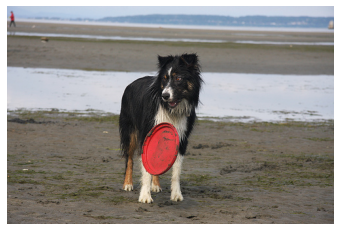

a black and white dog is jumping up to catch a ball


In [33]:
plot.imshow(plot.imread(test_image_path))
plot.axis('off')
plot.show()
print(cap1)

In [ ]:
with open(TEST_RESULTS_PATH, "wb") as file:
    pickle.dump(res, file)